### Hybdid transfomer for image classification using time series data (one time stemps) 
To create a hybrid model combining Convolutional Neural Networks (CNN) and Transformers, we can leverage the spatial feature extraction capabilities of CNNs and the temporal sequence modeling capabilities of Transformers. Here is a detailed implementation of such a hybrid model using TensorFlow and Keras:



## Data Preparation
Assuming you have the data prepared as described in the document:

In [1]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# Define the image directory and file names
image_dir = "./Images"
years_of_interest = [2021]

# Load sample points for training, testing, and validation
train_samples = gpd.read_file('Samples_points/training/training_centroids.shp')
test_samples = gpd.read_file('Samples_points/testing/testing_centroids.shp')
val_samples = gpd.read_file('Samples_points/testing/testing_centroids.shp')
val_samples.head()

ID  ClassID ClassName                    geometry
0   1        1  Antropic  POINT (-55.20718 -7.71981)
1   2        1  Antropic  POINT (-55.85370 -6.68549)
2   3        1  Antropic  POINT (-55.25838 -7.39129)
3   4        1  Antropic  POINT (-56.20916 -7.33093)
4   5        1  Antropic  POINT (-56.30833 -6.52056)

### Function extracting relevant features for input model

In [4]:
# Define the image directory and a pattern for the file names
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

def extract_features(samples, image_paths):
    features = []
    images = [rasterio.open(image_path) for image_path in image_paths]
    for point in samples.itertuples(index=False):
        point_features = []
        for src in images:
            spectral_features = []
            for band_index in range(1, 6):  # Assuming band order starts at 1
                raster_value = list(src.sample([(point.geometry.x, point.geometry.y)], indexes=band_index))[0][0]
                spectral_features.append(raster_value)
            point_features.append(spectral_features)
        features.append(point_features)
    return np.array(features)

In [5]:
# Extract features for each dataset
train_features_array = extract_features(train_samples, image_paths)
test_features_array = extract_features(test_samples, image_paths)
val_features_array = extract_features(val_samples, image_paths)

In [6]:
# Load class labels for each dataset
train_labels = train_samples['ClassName']
test_labels = test_samples['ClassName']
val_labels = val_samples['ClassName']

# Binarize labels
label_binarizer = LabelBinarizer()
label_binarizer.fit(np.concatenate([train_labels, test_labels, val_labels]))
y_train = label_binarizer.transform(train_labels)
y_test = label_binarizer.transform(test_labels)
y_val = label_binarizer.transform(val_labels)

# Convert features and labels to NumPy arrays
X_train = np.array(train_features_array, dtype=np.float32)
X_test = np.array(test_features_array, dtype=np.float32)
X_val = np.array(val_features_array, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

In [7]:
X_train = X_train.reshape((-1, 5, 1))  # Add an extra dimension for feature
X_test = X_test.reshape((-1, 5, 1))
X_val = X_val.reshape((-1, 5, 1))

# # Convert labels to one-hot encoding if they are not already
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
# y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
# Optionally, print the classes to verify
print("Classes:", label_binarizer.classes_)


X_train shape: (10000, 5, 1)
y_train shape: (10000, 5)
X_test shape: (5000, 5, 1)
y_test shape: (5000, 5)
X_val shape: (5000, 5, 1)
y_val shape: (5000, 5)
Classes: ['Antropic' 'Deforestation' 'Primary forest' 'Secondary forest' 'Water']


### Model Definition with Learning Rate, Dropout, and Regularization
We will create a CNN for spatial feature extraction and a Transformer for temporal feature extraction.

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Model configuration
# OPTIMIZER
LEARNING_RATE = 0.1
WEIGHT_DECAY = 0.0001

# ARCHITECTURE
seq_length = 1  # Number of steps per sequence
num_features = 5  # Number of features per step
num_classes = 5  # Number of output classes
embed_dim = 64  # Embedding size for each feature
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
num_transformer_blocks = 2  # Number of transformer blocks

def build_hybrid_model(num_features, seq_length, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks):
    """Builds a hybrid CNN-Transformer model for sequence data with multiple features."""
    
    inputs = layers.Input(shape=(num_features, seq_length))
    
    # Initial convolutional layer
    x = layers.Conv1D(filters=128, kernel_size=1, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=1)(x)
    x = layers.Conv1D(filters=256, kernel_size=1, activation='relu')(x)
    
    # Embed each step into a higher dimensional space
    x = layers.Dense(embed_dim, activation='relu')(x)
    
    # Transformer Encoder
    for _ in range(num_transformer_blocks):
        # Attention and normalization
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Feed-forward network
        ffn_output = layers.Dense(ff_dim, activation='relu')(x)
        ffn_output = layers.Dense(embed_dim)(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Pooling layer to aggregate sequence information
    x = layers.GlobalAveragePooling1D()(x)
    
    # Final classification layer
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
model = build_hybrid_model(num_features, seq_length, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model's architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 128)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 5, 128)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 256)    │     33,024 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5, 64)     │     16,448 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 64)     │     66,368 │ dense[0][0],      │
│ (MultiHeadAttentio… │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 64)     │          0 │ dense[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 64)     │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5, 32)     │      2,080 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5, 64)     │      2,112 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5, 64)     │          0 │ layer_normalizat… │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 64)     │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 64)     │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 5, 64)     │          0 │ layer_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 64)     │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5, 32)     │      2,080 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 5, 64)     │      2,112 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 5, 64)     │          0 │ layer_normalizat… │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 64)     │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 195,845 (765.02 KB)

 Trainable params: 195,845 (765.02 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import numpy as np

# Assuming X_train, X_val, X_test are your datasets with shapes (2000, 5, 5)
# Since the model expects the shape (seq_length, num_features), we can directly use the data as it is.

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4096 - loss: 1.3262 - val_accuracy: 0.6610 - val_loss: 0.8424
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6793 - loss: 0.7854 - val_accuracy: 0.6936 - val_loss: 0.7915
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6856 - loss: 0.7775 - val_accuracy: 0.7006 - val_loss: 0.7626
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6966 - loss: 0.7469 - val_accuracy: 0.6894 - val_loss: 0.7670
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6985 - loss: 0.7411 - val_accuracy: 0.7078 - val_loss: 0.7369
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6973 - loss: 0.7338 - val_accuracy: 0.7040 - val_loss: 0.7442
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7084 - loss: 0.7161 - val_accuracy: 0.6880 - val_loss: 0.8235
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6958 - loss: 0.7508 - val_accu

In [1]:
# import pandas as pd

# # Convert the history object's dictionary to a pandas DataFrame
# history_df = pd.DataFrame(history.history)

# # Save the DataFrame to a CSV file
# history_df.to_csv('Results_models/CNN_transfomer_5images/training_history.csv', index=False)

# print("Training history saved to training_history.csv.")

In [10]:
# import pandas as pd 
# tr_file = 'training_history.csv'

# df = pd.read_csv(tr_file)
# df

## Model Evaluation 

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


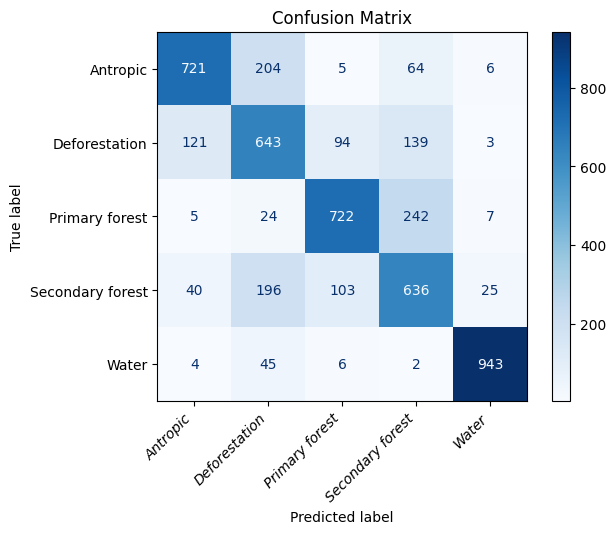

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assume 'model' and 'X_test' are defined, and 'y_test' is available and one-hot encoded
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Define class names for the confusion matrix
class_names = ['Antropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])  # Ensure labels are correctly aligned with class names

# Create the confusion matrix display object with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Italicize class names on the x-axis
ax = plt.gca()  # Get the current Axes instance on the current figure
labels = ax.get_xticklabels()  # Get the x-axis tick labels (which are the class names)
plt.setp(labels, rotation=45, horizontalalignment='right', fontstyle='italic')  # Set the properties for the labels
plt.savefig('Hybrid_transfomer/1_time_stet_results/CNN_Confusion_Matrix1.png')
plt.show()

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names =[0, 1, 2, 3, 4]

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column

# Append a total predictions row and recall row
metrics_df.loc['Total'] = metrics_df.sum(axis=0)
metrics_df.loc['Total', 'Precision (user)'] = ''  # Set to empty for clarity

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = metrics_df.append(recall_row)

# Add overall accuracy to the DataFrame
metrics_df.loc['Overall Accuracy'] = ['', '', '', '', '', '', overall_accuracy]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df


# Save the DataFrame to a CSV file
# metrics_df.to_csv('Hybrid_transfomer/1_time_stet_results/model_performance_metrics.csv', index=True)

# print("Metrics table saved to 'model_performance_metrics.csv'.")


ValueError: as_list() is not defined on an unknown TensorShape.

In [15]:
import numpy as np

# Convert one-hot encoded labels to integer labels
y_train_int = np.argmax(y_train, axis=1)

# Check the distribution of classes
print(np.unique(y_train_int, return_counts=True))


(array([0, 1, 2, 3, 4], dtype=int64), array([2000, 2000, 2000, 2000, 2000], dtype=int64))


In [314]:
# # Assuming model has been trained and you're evaluating on x_test or x_val
# predictions = model.predict(X_val)
# predicted_classes = np.argmax(predictions, axis=1)
# print(np.unique(predicted_classes, return_counts=True))


In [315]:
# from sklearn.metrics import confusion_matrix, accuracy_score

# # True labels in integer form
# y_val_int = np.argmax(y_val, axis=1)

# # Predictions
# predictions = model.predict(X_val)
# predicted_classes = np.argmax(predictions, axis=1)

# # Accuracy
# print("Accuracy:", accuracy_score(y_val_int, predicted_classes))

# # Confusion Matrix
# print("Confusion Matrix:\n", confusion_matrix(y_val_int, predicted_classes))


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate IoU (Jaccard Score)
iou = jaccard_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'IoU (Jaccard Score): {iou}')


Precision: 0.7418751179383578
Recall: 0.733
F1-score: 0.7361820159847077
IoU (Jaccard Score): 0.5994047955261093


In [17]:
# Print the complete metrics table including totals and recall
metrics_df

# Save the DataFrame to a CSV file
metrics_df.to_csv('Hybrid_transfomer/1_time_stet_results/CNN_performance_metrics_1.csv', index=True)

print("Metrics table saved to 'model_performance_metrics.csv'.")


Metrics table saved to 'model_performance_metrics.csv'.


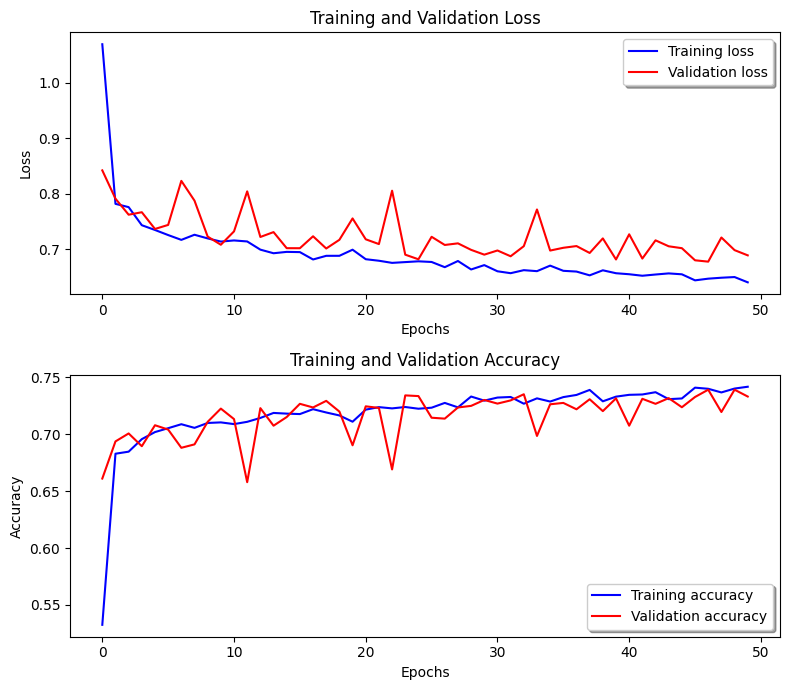

In [22]:
import matplotlib.pyplot as plt

# Assuming 'history.history' contains your training history data
fig, ax = plt.subplots(2, 1, figsize=(8, 7))

# Plot for training and validation loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title('Training and Validation Loss')  # Add a title to the first subplot
ax[0].set_xlabel('Epochs')  # Optional: Add x-axis label if needed
ax[0].set_ylabel('Loss')    # Add y-axis label

# Plot for training and validation accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title('Training and Validation Accuracy')  # Add a title to the second subplot
ax[1].set_xlabel('Epochs')  # Add x-axis label
ax[1].set_ylabel('Accuracy')  # Add y-axis label

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('Hybrid_transfomer/1_time_stet_results/training_history1.png')  # Save the figure to a file
plt.show()  # Display the figure


In [20]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


157/157 - 1s - 8ms/step - accuracy: 0.7330 - loss: 0.6894
Test Loss: 0.6893815994262695
Test Accuracy: 0.7329999804496765


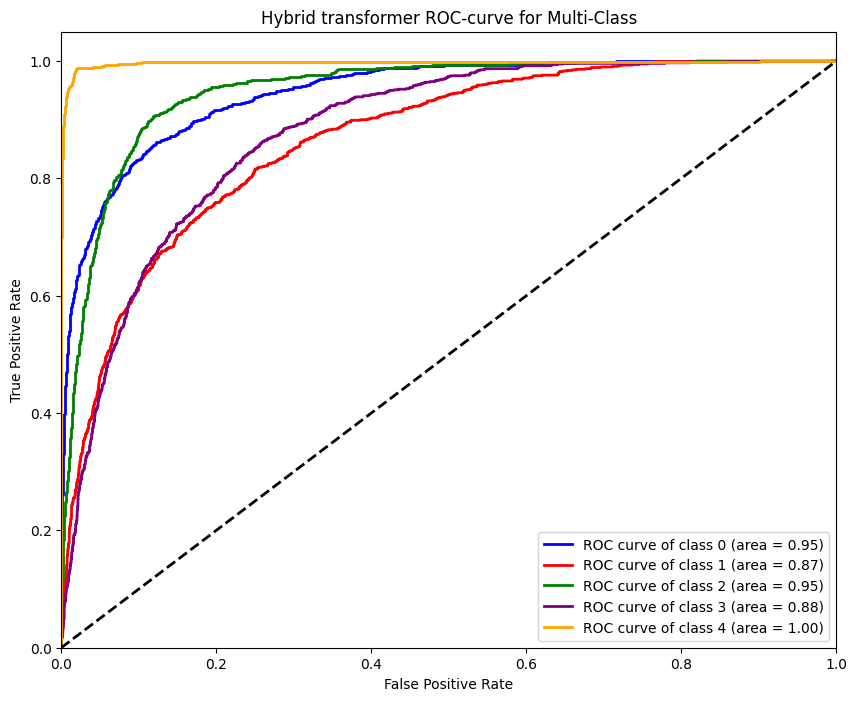

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid transformer ROC-curve for Multi-Class')
plt.legend(loc="lower right")
plt.savefig('Hybrid_transfomer/1_time_stet_results/ROC_curves1.png')
plt.show()


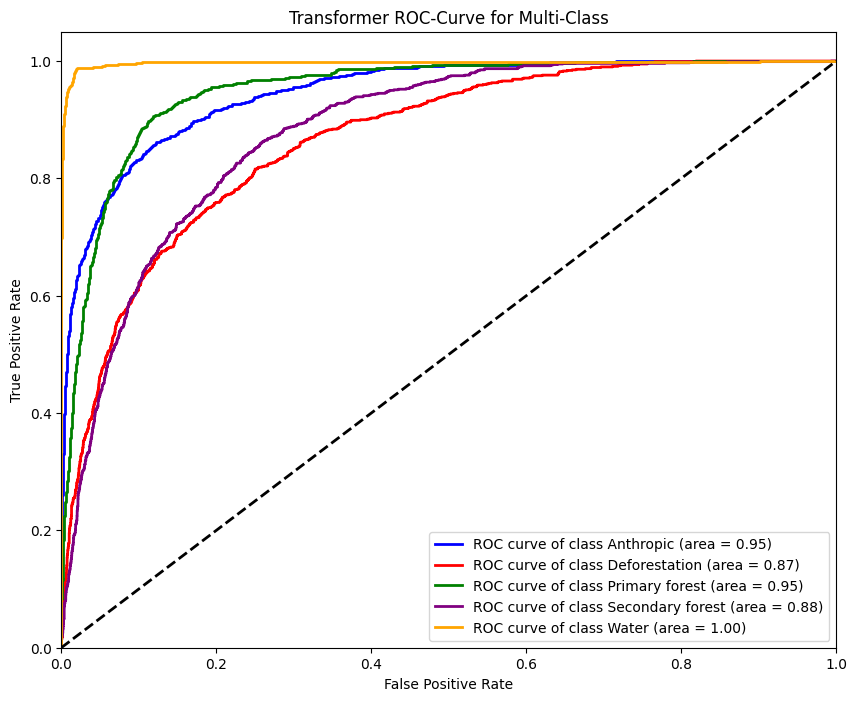

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC-Curve for Multi-Class')
plt.legend(loc="lower right")
plt.savefig('Hybrid_transfomer/1_time_stet_results/ROC_curves_1.png')
plt.show()


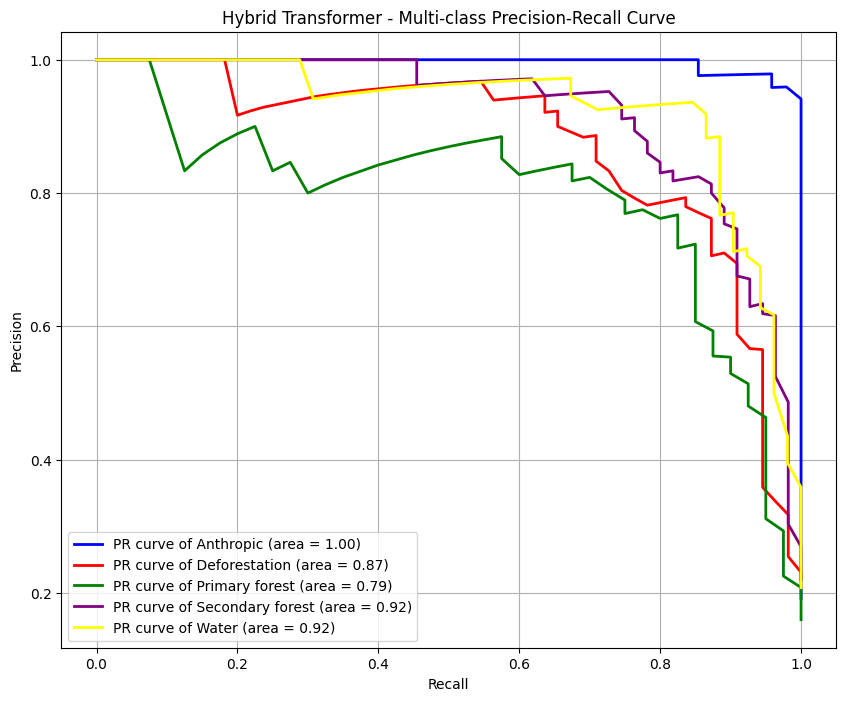

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Generate a synthetic multi-class classification dataset
X, y = make_classification(n_samples=1000, n_features=20,
                           n_classes=5, random_state=42, n_informative=3,
                           n_clusters_per_class=1)

# Binarize the labels for a multi-class setup
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a model using OneVsRestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train, y_train)

# Predict probabilities
y_scores = classifier.predict_proba(X_test)

# Define class names for the legend
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Setup plot details
colors = ['blue', 'red', 'green', 'purple', 'yellow']
plt.figure(figsize=(10, 8))

# Compute Precision-Recall curve and area for each class
for i, color, class_name in zip(range(n_classes), colors, class_names):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_scores[:, i])
    average_precision = average_precision_score(y_test[:, i], y_scores[:, i])
    
    plt.plot(recall, precision, color=color, lw=2,
             label='PR curve of {0} (area = {1:0.2f})'.format(class_name, average_precision))

plt.title('Hybrid Transformer - Multi-class Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('Hybrid_transfomer/1_time_stet_results/PR_Curve_classes_1.png')
plt.show()


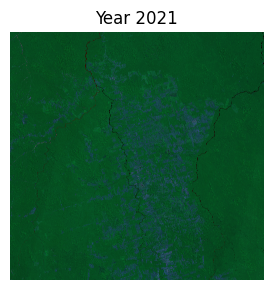

In [29]:
import rasterio
import os
import numpy as np
from matplotlib import pyplot as plt

# Define the directory containing the satellite images
image_dir = './Images'

# Define the years of interest
years_of_interest = [2021]  # Example list; add more years if needed

# Define band indices for Landsat 5 and Landsat 8
landsat5_bands = [1, 2, 3, 4, 5]  # Example bands; adjust as per your data specifics
landsat8_bands = [1, 2, 3, 4, 5]  # Example bands; adjust as per your data specifics

# Generate image paths for the specified years
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

# Set up a matplotlib subplot grid, with images in a single row
fig, axes = plt.subplots(1, len(years_of_interest), figsize=(15, 3))

# Ensure axes is always iterable
if len(years_of_interest) == 1:
    axes = [axes]  # Make it a list if only one subplot

# Iterate over each image path and subplot axis
for ax, image_path in zip(axes, image_paths):
    with rasterio.open(image_path) as src:
        # Extract the year from the image path
        year = int(os.path.basename(image_path).split('_')[1].split('.')[0])
        bands_to_read = landsat5_bands if year < 2013 else landsat8_bands
        image = np.stack([src.read(band) for band in bands_to_read], axis=0)

        # Assuming Red, Green, and Blue channels are the last three bands
        rgb = np.dstack((image[-3], image[-2], image[-1]))

        # Display the image on the corresponding subplot axis
        ax.imshow(rgb)
        ax.axis('off')  # Turn off the axis
        ax.set_title(f"Year {year}")  # Set title with the year

plt.tight_layout()  # Adjust layout
plt.show()  # Display all sub


In [43]:
# import tensorflow as tf

# # Load the saved model
# loaded_model = tf.keras.models.load_model("Hybrid_transfomer/1_time_stet_results/hy_model_model.h5")
# # 
# # Display the model's architecture to verify it was loaded correctly
# # loaded_model.summary()

TypeError: Error when deserializing class 'MultiHeadAttention' using config={'name': 'multi_head_attention_8', 'trainable': True, 'dtype': 'float32', 'num_heads': 2, 'key_dim': 64, 'value_dim': 64, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'query_shape': [None, None, 64], 'key_shape': [None, None, 64], 'value_shape': [None, None, 64]}.

Exception encountered: Unrecognized keyword arguments passed to MultiHeadAttention: {'query_shape': [None, None, 64], 'key_shape': [None, None, 64], 'value_shape': [None, None, 64]}

In [38]:
import rasterio
import os
import numpy as np
from matplotlib import pyplot as plt

# Define the image directory
image_dir = './Images'

# Define the years of interest
years_of_interest = [2021]

# Generate the paths for Landsat images for the specified years
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

# Define the Landsat bands
landsat_bands = [1, 2, 3, 4, 5]  # Band indices for Landsat 5, 8, etc.

# Initialize an empty list to store the stacked images
stacked_images = []

# Process each image
for image_path in image_paths:
    with rasterio.open(image_path) as src:
        # Extract the year from the image path
        year = int(os.path.basename(image_path).split('_')[1].split('.')[0])

        # Stack the bands without normalization
        image = np.stack([src.read(band) for band in landsat_bands], axis=0)

        # Append the raw bands to the list
        stacked_images.append(image)

# Stack the images along the first axis to create a single array
stacked_images_array = np.stack(stacked_images, axis=0)

# Check the shape of the stacked images array
print("Shape of stacked images array:", stacked_images_array.shape)


Shape of stacked images array: (1, 5, 7046, 7206)


In [40]:
# Transpose the dimensions to bring the last two dimensions together
transposed_array = np.transpose(stacked_images_array, (2, 3, 0, 1))

# Reshape the transposed array
reshaped_array = transposed_array.reshape(-1, transposed_array.shape[2], transposed_array.shape[3])

# Check the shape of the reshaped array
print("Shape of reshaped array:", reshaped_array.shape)

Shape of reshaped array: (50773476, 1, 5)


In [41]:
# Reshape the array to the desired shape
new_reshaped_array = reshaped_array.reshape(-1, 5, 1)

# Check the shape of the new reshaped array
print("Shape of newly reshaped array:", new_reshaped_array.shape)


Shape of newly reshaped array: (50773476, 5, 1)


In [42]:
flat_predicted = loaded_model.predict(new_reshaped_array, batch_size=32)
flat_predicted.shape

NameError: name 'loaded_model' is not defined

In [39]:
# import tensorflow as tf

# # Limit GPU memory growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# # Run prediction on CPU
# with tf.device('/CPU:0'):
#     flat_predicted = loaded_model.predict(new_reshaped_array, batch_size=32)
#     flat_predicted.shape


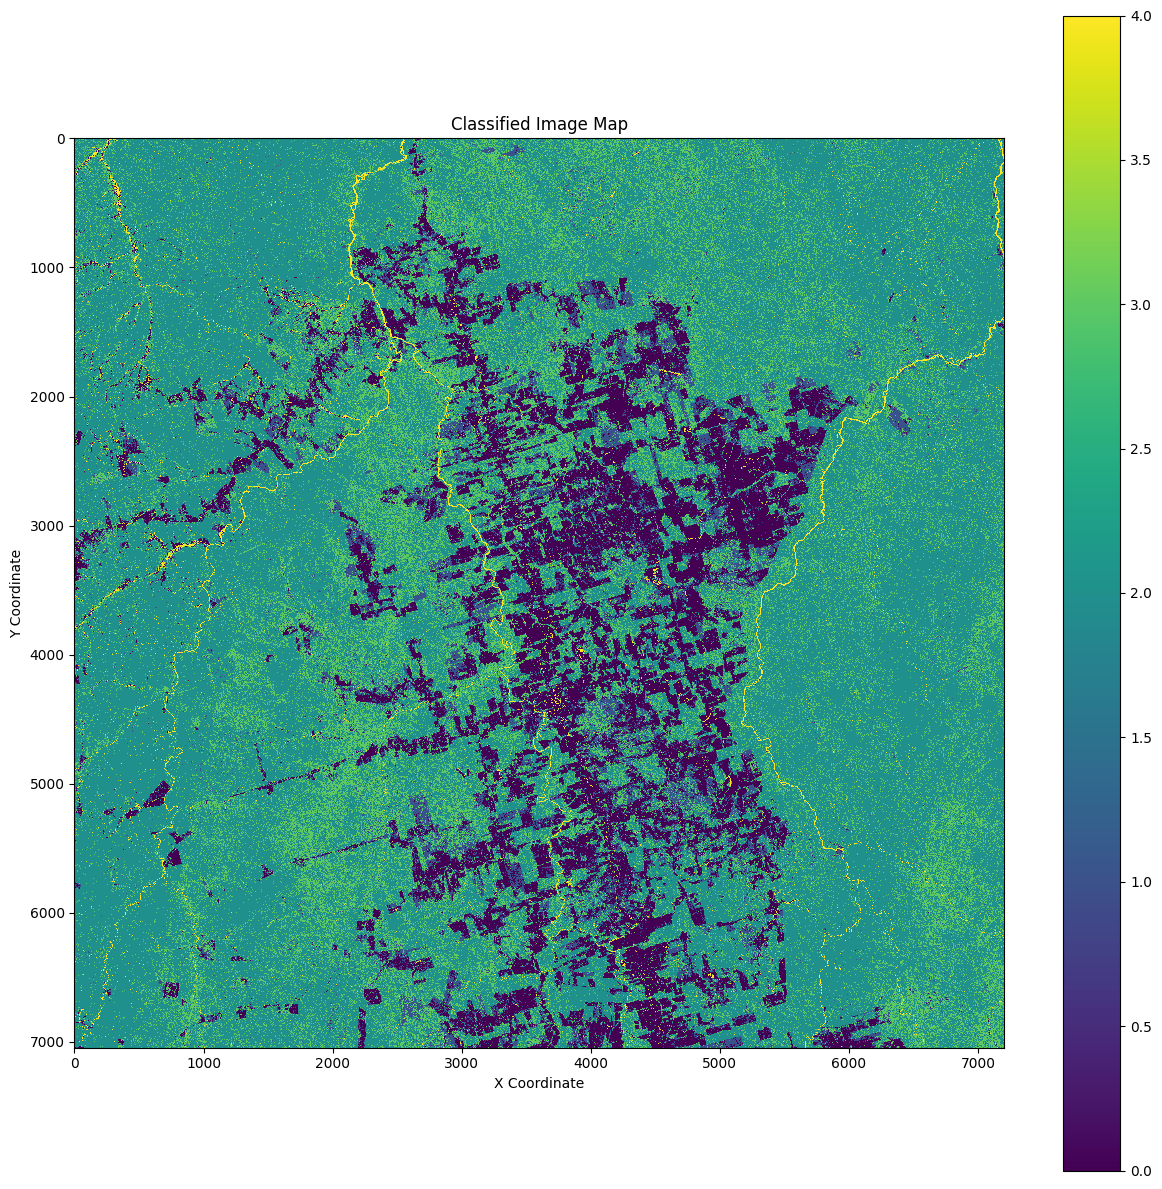

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you've already computed predicted_classes from flat_predicted
predicted_classes = np.argmax(flat_predicted, axis=1)

# Reshape to the chosen dimensions
try:
    dimensions = (7046, 7206)  # Chosen from your provided possible dimensions
    classified_image = predicted_classes.reshape(dimensions)

    # Plot the reshaped array as an image
    plt.figure(figsize=(15, 15))  # Set figure size to something large for better visibility
    plt.imshow(classified_image, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Classified Image Map')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
except Exception as e:
    print("Error in reshaping or plotting:", str(e))


In [41]:
  import rasterio
import os

# Define the image directory and file names
image_dir = "./Images"
image_path_2021 = os.path.join(image_dir, "Landsat_2021.tif")

# Load the image using rasterio and keep it open
with rasterio.open(image_path_2021) as src:
    # Read the image data
    image_data = src.read()
    
    # Assuming 'classified_image' is your classified map with shape (height, width)
    
    # Reshape the classified image to (height, width)
    classified_image_reshaped = classified_image.reshape(1, *classified_image.shape)
    
    # Save the prediction results
    with rasterio.open("Results_models/CNN_transfomer_5images/Final_CNN_predicted2021_1.tif", 'w', **src.profile) as dst:
        # Write the classified map to the output raster file
        dst.write(classified_image_reshaped[0], 1)
  

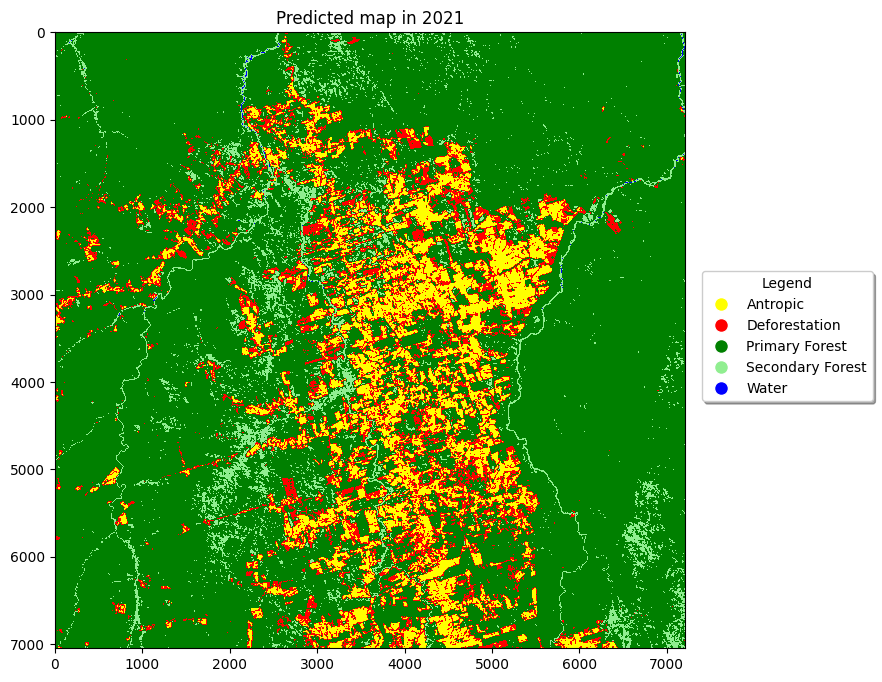

In [42]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the path to the classified image
classified_image_path = "Results_models/CNN_transfomer_5images/Final_CNN_predicted2021_1.tif"

# Load the classified image using rasterio
with rasterio.open(classified_image_path) as src:
    # Read the image data (assuming the classification results are in the first band)
    classified_image = src.read(1)  # Reading the first band

# Class mapping dictionary
# Define class names for the confusion matrix
class_mapping = {0: "Antropic", 1: "Deforestation", 2: "Primary Forest", 3: "Secondary Forest", 4: "Water"}

# Define colors for each class
colors = ['yellow', 'red', 'green', 'lightgreen', 'blue']  # Example colors for each class
cmap = mcolors.ListedColormap(colors)

# Create a normalized colorbar
bounds = np.arange(-0.5, len(class_mapping) + 0.5)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the image
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize as needed

# Plot the image
im = ax.imshow(classified_image, cmap=cmap, norm=norm)
ax.set_title('Predicted map in 2021')

# Place grid values on left and bottom edges
ax.tick_params(axis='both', which='both', bottom=True, left=True)

# Add legend beside the map
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=colors[index], markersize=10) 
                   for index, label in class_mapping.items()]
ax_legend = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust position and size of the legend axis
ax_legend.legend(handles=legend_elements, loc='center', shadow=True, fancybox=True, title='Legend')
ax_legend.axis('off')  # Hide the axis for the legend

# Save the plot as a JPEG image
plt.savefig('classified_map2021.png', format='png')
plt.show()


Unique class values in the image: [0. 1. 2. 3. 4.]


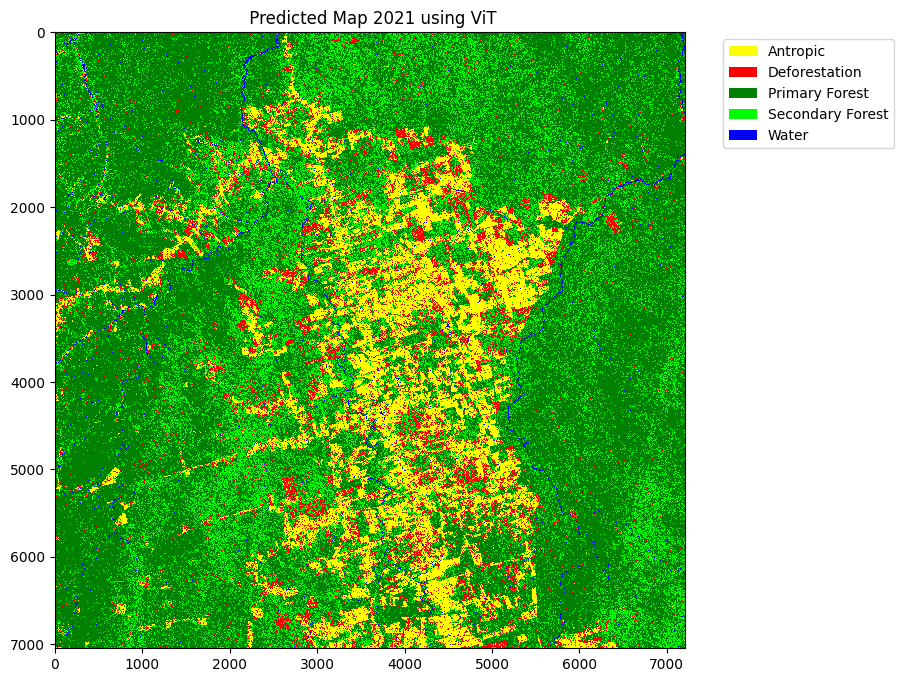

In [43]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def debug_unique_values(image):
    # This function will print the unique values found in the image
    unique_values = np.unique(image)
    print("Unique class values in the image:", unique_values)

# Load the classified image
with rasterio.open("Results_models/CNN_transfomer_5images/Final_CNN_predicted2021_1.tif") as src:
    classified_image = src.read(1)

# Debug to check unique values in the classified image
debug_unique_values(classified_image)

# Define colors assuming indices are correct: 0 - Antropic, 1 - Deforestation, 2 - Primary Forest, 
# 3 - Secondary Forest, 4 - Water
colors = ['#FFFF00', '#FF0000', '#008000', '#00FF00', '#0000FF']  # Yellow, Red, Green, Lime, Blue
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(np.arange(-0.5, 5, 1), cmap.N)

# Plot the image
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(classified_image, cmap=cmap, norm=norm, interpolation='nearest')
ax.set_title(' Predicted Map 2021 using ViT')

# Define legend with custom colored patches
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FFFF00', label='Antropic'),
    Patch(facecolor='#FF0000', label='Deforestation'),
    Patch(facecolor='#008000', label='Primary Forest'),
    Patch(facecolor='#00FF00', label='Secondary Forest'),
    Patch(facecolor='#0000FF', label='Water')
]

# Add the legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('Vit_classified_map2021.png', format='png')
plt.show()


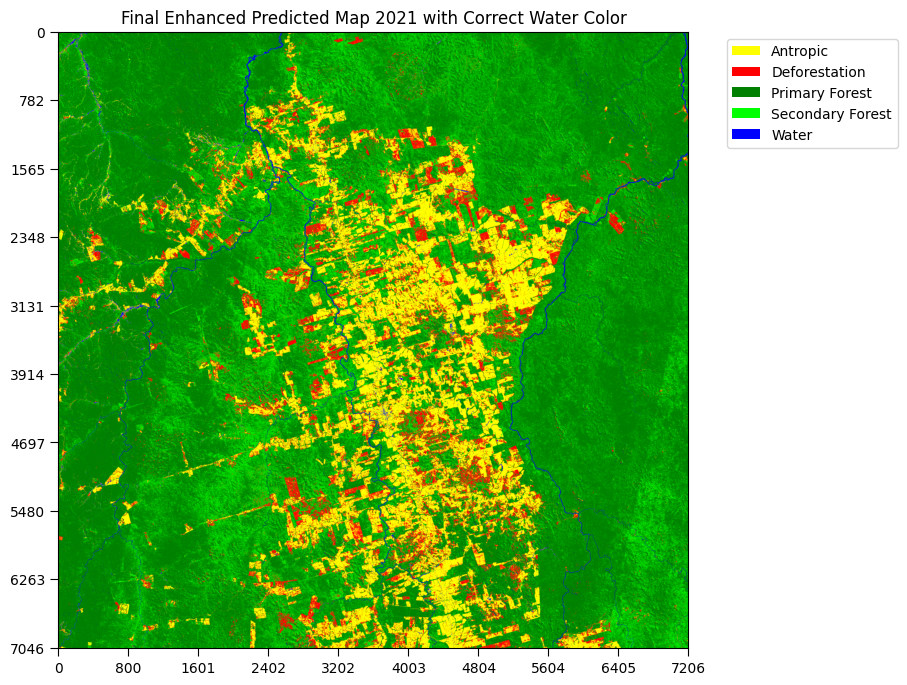

In [44]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the classified image
with rasterio.open("Results_models/CNN_transfomer_5images/Final_CNN_predicted2021_1.tif") as src:
    classified_image = src.read(1)

# Define your specific color mapping and class names
color_mapping = {
    0: ('Antropic', '#FFFF00'),  # Antropic - Yellow
    1: ('Deforestation', '#FF0000'),  # Deforestation - Red
    2: ('Primary Forest', '#008000'),  # Primary Forest - Green
    3: ('Secondary Forest', '#00FF00'),  # Secondary Forest - Lime
    4: ('Water', '#0000FF')  # Water - Blue
}

# Convert class indices to RGB values
rgb_image = np.zeros((*classified_image.shape, 3), dtype=float)
for k, (name, hex_color) in color_mapping.items():
    rgb_color = np.array([int(hex_color[i:i+2], 16) for i in (1, 3, 5)]) / 255.0
    mask = classified_image == k
    rgb_image[mask] = rgb_color

# Plot the RGB image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(rgb_image)
ax.set_title('Final Enhanced Predicted Map 2021 with Correct Water Color')

# Enable axes to set ticks and grid lines on borders
ax.axis('on')  # Enable axis

# Set more frequent ticks along the borders by dividing the image dimensions into more segments
num_ticks = 10  # Increase this number for more frequent ticks
ax.set_xticks(np.linspace(0, classified_image.shape[1], num_ticks, endpoint=True))
ax.set_yticks(np.linspace(0, classified_image.shape[0], num_ticks, endpoint=True))

ax.set_xticklabels([str(int(i)) for i in np.linspace(0, classified_image.shape[1], num_ticks, endpoint=True)])
ax.set_yticklabels([str(int(i)) for i in np.linspace(0, classified_image.shape[0], num_ticks, endpoint=True)])

ax.tick_params(axis='both', which='both', direction='out', length=6, labelsize=10)
ax.grid(False)  # Disable internal grid lines for cleaner look

# Create a legend with custom colored patches
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=hex_color, label=name) for name, hex_color in color_mapping.values()]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [45]:
import rasterio
import numpy as np
import pandas as pd

# Define the path to the classified image
classified_image_path = "Results_models/CNN_transfomer_5images/Final_CNN_predicted2021_1.tif"

# Load the classified image using rasterio
with rasterio.open(classified_image_path) as src:
    # Read the image data (assuming the classification results are in the first band)
    classified_image = src.read(1)  # Reading the first band

    # Convert float64 image data to int64 if necessary
    if classified_image.dtype == np.float64:
        classified_image = classified_image.astype(np.int64)

    # Calculate pixel size in hectares (assuming square pixels)
    pixel_size_m = src.res[0] * src.res[1]  # pixel width * pixel height in square meters
    pixel_size_ha = pixel_size_m / 10000  # convert square meters to hectares

    # Count each class occurrence
    class_counts = np.bincount(classified_image.flatten(), minlength=len(class_mapping))

    # Calculate area for each class in hectares
    class_areas_ha = class_counts * pixel_size_ha

    # Calculate total area and percentages
    total_area_ha = class_areas_ha.sum()
    class_percentages = (class_areas_ha / total_area_ha) * 100

    # Format the table
    table_header = ["Class", "No of Pixel", "Area (ha)", "Area (%)"]
    table_rows = [[class_mapping[i], class_counts[i], class_areas_ha[i], class_percentages[i]] for i in range(len(class_counts))]

    # Print table using pandas for a nicer format
    df = pd.DataFrame(table_rows, columns=table_header)
    print(df)

    # Save the DataFrame to a CSV file
    df.to_csv('Results_models/CNN_transfomer_5images/hy_class_statistics.csv', index=False)


              Class  No of Pixel  Area (ha)   Area (%)
0          Antropic      6384568   0.000046  12.574613
1     Deforestation      3691233   0.000027   7.270003
2    Primary Forest     30518588   0.000222  60.107344
3  Secondary Forest      9687762   0.000070  19.080360
4             Water       491325   0.000004   0.967680


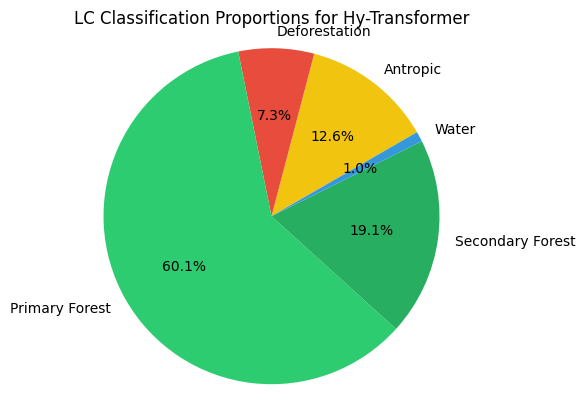

In [46]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the classified image
classified_image_path = "Results_models/CNN_transfomer_5images/Final_CNN_predicted2021_1.tif"

# Load the classified image using rasterio
with rasterio.open(classified_image_path) as src:
    # Read the image data (assuming the classification results are in the first band)
    classified_image = src.read(1)  # Reading the first band

    # Convert float64 image data to int64 if necessary
    if classified_image.dtype == np.float64:
        classified_image = classified_image.astype(np.int64)

    # Calculate pixel size in hectares (assuming square pixels)
    pixel_size_m = src.res[0] * src.res[1]  # pixel width * pixel height in square meters
    pixel_size_ha = pixel_size_m / 10000  # convert square meters to hectares

    # Count each class occurrence
    class_counts = np.bincount(classified_image.flatten(), minlength=5)

    # Calculate area for each class in hectares
    class_areas_ha = class_counts * pixel_size_ha

    # Calculate total area and percentages
    total_area_ha = class_areas_ha.sum()
    class_percentages = (class_areas_ha / total_area_ha) * 100

    # Class labels
    class_labels = ["Antropic", "Deforestation", "Primary Forest", "Secondary Forest", "Water"]

# Create DataFrame for visualization
df = pd.DataFrame({
    'Class': class_labels,
    'Area (%)': class_percentages
})

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(df['Area (%)'], labels=df['Class'], autopct='%1.1f%%', startangle=30, colors=['#f1c40f', '#e74c3c', '#2ecc71', '#27ae60', '#3498db'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('LC Classification Proportions for Hy-Transformer')
# Save the pie chart as a PNG file
plt.savefig('Results_models/CNN_transfomer_5images/Hy_LC_classification2021_1.png', format='png')
plt.show()


In [1]:
import numpy as np

def compute_c_min_and_c_diff(probabilities):
    c_min = np.min(probabilities, axis=1)
    sorted_probs = np.sort(probabilities, axis=1)
    c_diff = sorted_probs[:, -1] - sorted_probs[:, -2]
    return c_min, c_diff

# Example usage
# Suppose probabilities is an array where each row represents softmax outputs for an image
probabilities = np.array([
    [0.1, 0.2, 0.7],
    [0.3, 0.4, 0.3],
    [0.33, 0.33, 0.34]
])
c_min, c_diff = compute_c_min_and_c_diff(probabilities)
print("C_min:", c_min)
print("C_diff:", c_diff)

C_min: [0.1  0.3  0.33]
C_diff: [0.5  0.1  0.01]


# Code for Hybrid trasnfomer for three time steps

## Data Preparation
Assuming you have the data prepared as described in the document:

In [45]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# Define the image directory and file names
image_dir = "./Images"
years_of_interest = [2017, 2019, 2021]

# Load sample points for training, testing, and validation
# Load sample points for training, testing, and validation
train_samples = gpd.read_file('Results/training_centroids.shp')
test_samples = gpd.read_file('Results/testing_centroids.shp')
val_samples = gpd.read_file('Results/validation_centroids.shp')
val_samples.head()

ERROR:fiona._env:Results/training_centroids.shp: No such file or directory


DriverError: Results/training_centroids.shp: No such file or directory

### Function extracting relevant features for input model

In [4]:
# Define the image directory and a pattern for the file names
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

def extract_features(samples, image_paths):
    features = []
    images = [rasterio.open(image_path) for image_path in image_paths]
    for point in samples.itertuples(index=False):
        point_features = []
        for src in images:
            spectral_features = []
            for band_index in range(1, 6):  # Assuming band order starts at 1
                raster_value = list(src.sample([(point.geometry.x, point.geometry.y)], indexes=band_index))[0][0]
                spectral_features.append(raster_value)
            point_features.append(spectral_features)
        features.append(point_features)
    return np.array(features)

In [5]:
# Extract features for each dataset
train_features_array = extract_features(train_samples, image_paths)
test_features_array = extract_features(test_samples, image_paths)
val_features_array = extract_features(val_samples, image_paths)

In [6]:
# Load class labels for each dataset
train_labels = train_samples['ClassName']
test_labels = test_samples['ClassName']
val_labels = val_samples['ClassName']

# Binarize labels
label_binarizer = LabelBinarizer()
label_binarizer.fit(np.concatenate([train_labels, test_labels, val_labels]))
y_train = label_binarizer.transform(train_labels)
y_test = label_binarizer.transform(test_labels)
y_val = label_binarizer.transform(val_labels)

# Convert features and labels to NumPy arrays
X_train = np.array(train_features_array, dtype=np.float32)
X_test = np.array(test_features_array, dtype=np.float32)
X_val = np.array(val_features_array, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

In [ ]:
X_train = X_train.reshape((-1, 5, 3))  # Add an extra dimension for feature
X_test = X_test.reshape((-1, 5, 3))
X_val = X_val.reshape((-1, 5, 3))

# # Convert labels to one-hot encoding if they are not already
# y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)
# y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
# Optionally, print the classes to verify
print("Classes:", label_binarizer.classes_)


### Model Definition with Learning Rate, Dropout, and Regularization
We will create a CNN for spatial feature extraction and a Transformer for temporal feature extraction.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Model configuration
# OPTIMIZER
LEARNING_RATE = 0.1
WEIGHT_DECAY = 0.0001

# ARCHITECTURE
seq_length = 3  # Number of steps per sequence
num_features = 5  # Number of features per step
num_classes = 5  # Number of output classes
embed_dim = 64  # Embedding size for each feature
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
num_transformer_blocks = 2  # Number of transformer blocks

def build_hybrid_model(num_features, seq_length, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks):
    """Builds a hybrid CNN-Transformer model for sequence data with multiple features."""
    
    inputs = layers.Input(shape=(num_features, seq_length))
    
    # Initial convolutional layer
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=256, kernel_size=2, activation='relu')(x)
    
    # Embed each step into a higher dimensional space
    x = layers.Dense(embed_dim, activation='relu')(x)
    
    # Transformer Encoder
    for _ in range(num_transformer_blocks):
        # Attention and normalization
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Feed-forward network
        ffn_output = layers.Dense(ff_dim, activation='relu')(x)
        ffn_output = layers.Dense(embed_dim)(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Pooling layer to aggregate sequence information
    x = layers.GlobalAveragePooling1D()(x)
    
    # Final classification layer
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
model = build_hybrid_model(num_features, seq_length, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model's architecture
model.summary()


In [ ]:
import numpy as np

# Assuming X_train, X_val, X_test are your datasets with shapes (2000, 5, 5)
# Since the model expects the shape (seq_length, num_features), we can directly use the data as it is.

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


## Model Evaluation 

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Assume 'model' and 'X_test' are defined, and 'y_test' is available and one-hot encoded
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

# Define class names for the confusion matrix
class_names = ['Antropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])  # Ensure labels are correctly aligned with class names

# Create the confusion matrix display object with class names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Italicize class names on the x-axis
ax = plt.gca()  # Get the current Axes instance on the current figure
labels = ax.get_xticklabels()  # Get the x-axis tick labels (which are the class names)
plt.setp(labels, rotation=45, horizontalalignment='right', fontstyle='italic')  # Set the properties for the labels
plt.savefig('Results_models/CNN_transfomer_5images/CNN_Confusion_Matrix3.png')
plt.show()




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['0', '1', '2', '3','4']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column

# Append a total predictions row and recall row
metrics_df.loc['Total'] = metrics_df.sum(axis=0)
metrics_df.loc['Total', 'Precision (user)'] = ''  # Set to empty for clarity

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = metrics_df.append(recall_row)

# Add overall accuracy to the DataFrame
metrics_df.loc['Overall Accuracy'] = ['', '', '', '', '', '', overall_accuracy]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df

# Save the DataFrame to a CSV file
# metrics_df.to_csv('model_performance_metrics.csv', index=True)

# print("Metrics table saved to 'model_performance_metrics.csv'.")


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate IoU (Jaccard Score)
iou = jaccard_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'IoU (Jaccard Score): {iou}')


In [ ]:
# Print the complete metrics table including totals and recall
metrics_df

# Save the DataFrame to a CSV file
metrics_df.to_csv('Results_models/CNN_transfomer_5images/model_performance_metrics_3.csv', index=True)

print("Metrics table saved to 'model_performance_metrics.csv'.")


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history.history' contains your training history data
fig, ax = plt.subplots(2, 1, figsize=(8, 7))

# Plot for training and validation loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title('Training and Validation Loss')  # Add a title to the first subplot
ax[0].set_xlabel('Epochs')  # Optional: Add x-axis label if needed
ax[0].set_ylabel('Loss')    # Add y-axis label

# Plot for training and validation accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title('Training and Validation Accuracy')  # Add a title to the second subplot
ax[1].set_xlabel('Epochs')  # Add x-axis label
ax[1].set_ylabel('Accuracy')  # Add y-axis label

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('Results_models/CNN_transfomer_5images/Fianl_training_history_3.png')  # Save the figure to a file
plt.show()  # Display the figure


In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid transformer ROC-curve for Multi-Class')
plt.legend(loc="lower right")
plt.savefig('Results_models/CNN_transfomer_5images/Fianl_ROC_curves_3.png')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Generate a synthetic multi-class classification dataset
X, y = make_classification(n_samples=1000, n_features=20,
                           n_classes=5, random_state=42, n_informative=3,
                           n_clusters_per_class=1)

# Binarize the labels for a multi-class setup
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a model using OneVsRestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train, y_train)

# Predict probabilities
y_scores = classifier.predict_proba(X_test)

# Setup plot details
colors = ['blue', 'red', 'green', 'purple', 'yellow']
plt.figure(figsize=(10, 8))

# Compute Precision-Recall curve and area for each class
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_scores[:, i])
    average_precision = average_precision_score(y_test[:, i], y_scores[:, i])
    
    plt.plot(recall, precision, color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision))

plt.title('Multi-class Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('Results_models/CNN_transfomer_5images/Final_curve_classes_3.png')
plt.show()


In [ ]:
import rasterio
import os
import numpy as np
from matplotlib import pyplot as plt

# Define the directory containing the satellite images
image_dir = './Images'

# Define the years of interest
years_of_interest = [2017, 2019, 2021]

# Define band indices for Landsat 5 and Landsat 8
landsat5_bands = [1, 2, 3, 4, 5]
landsat8_bands = [1, 2, 3, 4, 5]

# Generate image paths for the specified years
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

# Set up a matplotlib subplot grid, with images in a single row
fig, axes = plt.subplots(1, len(years_of_interest), figsize=(15, 8))

# Iterate over each image path and subplot axis
for ax, image_path in zip(axes, image_paths):
    with rasterio.open(image_path) as src:
        # Extract the year from the image path
        year = int(os.path.basename(image_path).split('_')[1].split('.')[0])
        bands_to_read = landsat5_bands if year < 2013 else landsat8_bands
        image = np.stack([src.read(band) for band in bands_to_read], axis=0)

        # Assuming Red, Green, and Blue channels are the last three bands
        rgb = np.dstack((image[-3], image[-2], image[-1]))

        # Display the image on the corresponding subplot axis
        ax.imshow(rgb)
        ax.axis('off')  # Turn off the axis
        ax.grid(True)  # Enable grid
        ax.set_title(f"Year {year}")  # Set title with the year

plt.tight_layout()  # Adjust layout
plt.show()  # Display all subplots


In [ ]:
# Correctly saving the model
model.save("Results_models/CNN_transfomer_5images/Final_CNN_transformer_model_3.h5")

In [ ]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model("Results_models/CNN_transfomer_5images/Final_CNN_transformer_model_3.h5")

# Display the model's architecture to verify it was loaded correctly
# loaded_model.summary()

In [ ]:
import rasterio
import os
import numpy as np
from matplotlib import pyplot as plt

# Define the image directory
image_dir = './Images'

# Define the years of interest
years_of_interest = [2017, 2019, 2021]

# Generate the paths for Landsat images for the specified years
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

# Define the Landsat bands
landsat_bands = [1, 2, 3, 4, 5]  # Band indices for Landsat 5, 8, etc.

# Initialize an empty list to store the stacked images
stacked_images = []

# Process each image
for image_path in image_paths:
    with rasterio.open(image_path) as src:
        # Extract the year from the image path
        year = int(os.path.basename(image_path).split('_')[1].split('.')[0])

        # Stack the bands without normalization
        image = np.stack([src.read(band) for band in landsat_bands], axis=0)

        # Append the raw bands to the list
        stacked_images.append(image)

# Stack the images along the first axis to create a single array
stacked_images_array = np.stack(stacked_images, axis=0)

# Check the shape of the stacked images array
print("Shape of stacked images array:", stacked_images_array.shape)


In [ ]:
# Transpose the dimensions to bring the last two dimensions together
transposed_array = np.transpose(stacked_images_array, (2, 3, 0, 1))

# Reshape the transposed array
reshaped_array = transposed_array.reshape(-1, transposed_array.shape[2], transposed_array.shape[3])

# Check the shape of the reshaped array
print("Shape of reshaped array:", reshaped_array.shape)

In [ ]:
# Reshape the array to the desired shape
new_reshaped_array = reshaped_array.reshape(-1,5 , 3)

# Check the shape of the new reshaped array
print("Shape of newly reshaped array:", new_reshaped_array.shape)

In [ ]:
import tensorflow as tf

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Run prediction on CPU
with tf.device('/CPU:0'):
    flat_predicted = loaded_model.predict(new_reshaped_array, batch_size=32)
    flat_predicted.shape


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you've already computed predicted_classes from flat_predicted
predicted_classes = np.argmax(flat_predicted, axis=1)

# Reshape to the chosen dimensions
try:
    dimensions = (7046, 7206)  # Chosen from your provided possible dimensions
    classified_image = predicted_classes.reshape(dimensions)

    # Plot the reshaped array as an image
    plt.figure(figsize=(15, 15))  # Set figure size to something large for better visibility
    plt.imshow(classified_image, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Classified Image Map')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
except Exception as e:
    print("Error in reshaping or plotting:", str(e))


In [ ]:
  import rasterio
import os

# Define the image directory and file names
image_dir = "./Images"
image_path_2021 = os.path.join(image_dir, "Landsat_2021.tif")

# Load the image using rasterio and keep it open
with rasterio.open(image_path_2021) as src:
    # Read the image data
    image_data = src.read()
    
    # Assuming 'classified_image' is your classified map with shape (height, width)
    
    # Reshape the classified image to (height, width)
    classified_image_reshaped = classified_image.reshape(1, *classified_image.shape)
    
    # Save the prediction results
    with rasterio.open("Results_models/CNN_transfomer_5images/Finalcnn_predicted2021_3.tif", 'w', **src.profile) as dst:
        # Write the classified map to the output raster file
        dst.write(classified_image_reshaped[0], 1)
  

In [ ]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the classified image
classified_image_path = "Results_models/CNN_transfomer_5images/Finalcnn_predicted2021_3.tif"

# Load the classified image using rasterio
with rasterio.open(classified_image_path) as src:
    # Read the image data (assuming the classification results are in the first band)
    classified_image = src.read(1)  # Reading the first band

    # Convert float64 image data to int64 if necessary
    if classified_image.dtype == np.float64:
        classified_image = classified_image.astype(np.int64)

    # Calculate pixel size in hectares (assuming square pixels)
    pixel_size_m = src.res[0] * src.res[1]  # pixel width * pixel height in square meters
    pixel_size_ha = pixel_size_m / 10000  # convert square meters to hectares

    # Count each class occurrence
    class_counts = np.bincount(classified_image.flatten(), minlength=5)

    # Calculate area for each class in hectares
    class_areas_ha = class_counts * pixel_size_ha

    # Calculate total area and percentages
    total_area_ha = class_areas_ha.sum()
    class_percentages = (class_areas_ha / total_area_ha) * 100

    # Class labels
    class_labels = ["Antropic", "Deforestation", "Primary Forest", "Secondary Forest", "Water"]

# Create DataFrame for visualization
df = pd.DataFrame({
    'Class': class_labels,
    'Area (%)': class_percentages
})

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(df['Area (%)'], labels=df['Class'], autopct='%1.1f%%', startangle=30, colors=['#f1c40f', '#e74c3c', '#2ecc71', '#27ae60', '#3498db'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('LC Classification Proportions for Hy-Transformer')
# Save the pie chart as a PNG file
plt.savefig('Results_models/CNN_transfomer_5images/Hy_LC_classification2021_3.png', format='png')
plt.show()


### Hybrid transfomer for image classification using time series data (5 time stemps)

In [ ]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# Define the image directory and file names
image_dir = "./Images"
years_of_interest = [2013, 2015, 2017, 2019,2021]

# Load sample points for training, testing, and validation
# Load sample points for training, testing, and validation
train_samples = gpd.read_file('Results/training_centroids.shp')
test_samples = gpd.read_file('Results/testing_centroids.shp')
val_samples = gpd.read_file('Results/validation_centroids.shp')
val_samples.head()
len(train_samples)

### Function extracting relevant features for input model

In [ ]:
# Define the image directory and a pattern for the file names
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

def extract_features(samples, image_paths):
    features = []
    images = [rasterio.open(image_path) for image_path in image_paths]
    for point in samples.itertuples(index=False):
        point_features = []
        for src in images:
            spectral_features = []
            for band_index in range(1, 6):  # Assuming band order starts at 1
                raster_value = list(src.sample([(point.geometry.x, point.geometry.y)], indexes=band_index))[0][0]
                spectral_features.append(raster_value)
            point_features.append(spectral_features)
        features.append(point_features)
    return np.array(features)

In [ ]:
# Extract features for each dataset
train_features_array = extract_features(train_samples, image_paths)
test_features_array = extract_features(test_samples, image_paths)
val_features_array = extract_features(val_samples, image_paths)

In [ ]:
# Load class labels for each dataset
train_labels = train_samples['ClassName']
test_labels = test_samples['ClassName']
val_labels = val_samples['ClassName']

# Binarize labels
label_binarizer = LabelBinarizer()
label_binarizer.fit(np.concatenate([train_labels, test_labels, val_labels]))
y_train = label_binarizer.transform(train_labels)
y_test = label_binarizer.transform(test_labels)
y_val = label_binarizer.transform(val_labels)

# Convert features and labels to NumPy arrays
X_train = np.array(train_features_array, dtype=np.float32)
X_test = np.array(test_features_array, dtype=np.float32)
X_val = np.array(val_features_array, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

In [ ]:
# Print the shapes of X and y to verify their dimensions
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
# 
# Optionally, print the classes to verify
print("Classes:", label_binarizer.classes_)


In [ ]:
# Reshape X_train and X_val to (10000, 5, 10) and (5000, 5, 10)
X_train = X_train.reshape(-1, 5, 10)
X_val = X_val.reshape(-1, 5, 10)
X_test = X_test.reshape(-1, 5, 10)
# Print the new shapes to verify
print(f"X_train shape after reshaping: {X_train.shape}")
print(f"X_val shape after reshaping: {X_val.shape}")
print(f"X_val shape after reshaping: {X_test.shape}")

### Model Definition with Learning Rate, Dropout, and Regularization
We will create a CNN for spatial feature extraction and a Transformer for temporal feature extraction.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Model configuration
# OPTIMIZER
LEARNING_RATE = 0.1
WEIGHT_DECAY = 0.01

# ARCHITECTURE
seq_length = 10  # Number of steps per sequence
num_features = 5  # Number of features per step
num_classes = 5  # Number of output classes
embed_dim = 64  # Embedding size for each feature
num_heads = 4  # Number of attention heads
ff_dim = 3072  # Hidden layer size in feed forward network inside transformer
num_transformer_blocks = 2  # Number of transformer blocks

def build_hybrid_model(num_features, seq_length, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks):
    """Builds a hybrid CNN-Transformer model for sequence data with multiple features."""
    
    inputs = layers.Input(shape=(num_features, seq_length))
    
    # Initial convolutional layer
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=256, kernel_size=2, activation='relu')(x)
    
    # Embed each step into a higher dimensional space
    x = layers.Dense(embed_dim, activation='relu')(x)
    
    # Transformer Encoder
    for _ in range(num_transformer_blocks):
        # Attention and normalization
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Feed-forward network
        ffn_output = layers.Dense(ff_dim, activation='relu')(x)
        ffn_output = layers.Dense(embed_dim)(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Pooling layer to aggregate sequence information
    x = layers.GlobalAveragePooling1D()(x)
    
    # Final classification layer
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
model = build_hybrid_model(num_features, seq_length, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model's architecture
model.summary()


In [ ]:
import numpy as np

# Assuming X_train, X_val, X_test are your datasets with shapes (2000, 5, 5)
# Since the model expects the shape (seq_length, num_features), we can directly use the data as it is.

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)  # Predictions are probabilities from the softmax layer
y_true = np.argmax(y_test, axis=1)   # Convert one-hot encoded labels to class indices

# Define class names and thresholds for each class
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']
thresholds =[0.75, 0.75, 0.75, 0.75, 0.75]  # Set your desired thresholds for each class

# Apply thresholds to predictions
adjusted_predictions = np.zeros_like(predictions)
for i in range(predictions.shape[1]):
    adjusted_predictions[:, i] = (predictions[:, i] > thresholds[i]).astype(int)

# Convert adjusted probabilities to class predictions
y_pred = np.argmax(adjusted_predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, labels=range(len(class_names)), average=None)
recall = recall_score(y_true, y_pred, labels=range(len(class_names)), average=None)
f1_scores = f1_score(y_true, y_pred, labels=range(len(class_names)), average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column
metrics_df['F1-Score'] = np.round(f1_scores * 100, 2)  # Add F1 score as a column

# Append a total predictions row
total_row = pd.Series(metrics_df.sum(axis=0), name='Total')
total_row['Precision (user)'] = ''
total_row['F1-Score'] = ''
metrics_df = pd.concat([metrics_df, pd.DataFrame([total_row])])

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([recall_row])])

# Append precision (user) row at the bottom
precision_row = pd.Series(np.round(precision * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Precision (user)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([precision_row])])

# Add overall accuracy to the DataFrame
overall_accuracy_row = pd.Series([''] * (metrics_df.shape[1] - 2) + [overall_accuracy, ''], index=metrics_df.columns, name='Overall Accuracy')
metrics_df = pd.concat([metrics_df, pd.DataFrame([overall_accuracy_row])])

# Reorder the columns to match the desired structure
columns_order = class_names + ['Total', 'Precision (user)', 'F1-Score']
metrics_df = metrics_df[columns_order]

# Display the DataFrame
metrics_df

# Save the DataFrame to a CSV file if needed
# metrics_df.to_csv('predicted_map_accuracy_metrics.csv', index=True)
# print("Metrics table saved to 'predicted_map_accuracy_metrics.csv'.")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)  # Predictions are probabilities from the softmax layer
y_true = np.argmax(y_test, axis=1)   # Convert one-hot encoded labels to class indices

# Define class names and thresholds for each class
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']
thresholds = [0.75, 0.75, 0.75, 0.75, 0.75]  # Set your desired thresholds for each class

# Apply thresholds to predictions
adjusted_predictions = np.zeros_like(predictions)
for i in range(predictions.shape[1]):
    adjusted_predictions[:, i] = (predictions[:, i] > thresholds[i]).astype(int)

# Convert adjusted probabilities to class predictions
y_pred = np.argmax(adjusted_predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, labels=range(len(class_names)), average=None)
recall = recall_score(y_true, y_pred, labels=range(len(class_names)), average=None)
f1_scores = f1_score(y_true, y_pred, labels=range(len(class_names)), average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column
metrics_df['F1-Score'] = np.round(f1_scores * 100, 2)  # Add F1 score as a column

# Append a total predictions row
total_row = pd.Series(metrics_df.sum(axis=0), name='Total')
total_row['Precision (user)'] = ''
total_row['F1-Score'] = ''
metrics_df = pd.concat([metrics_df, pd.DataFrame([total_row])])

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([recall_row])])

# Add overall accuracy to the DataFrame
overall_accuracy_row = pd.Series([''] * (metrics_df.shape[1] - 2) + [overall_accuracy, ''], index=metrics_df.columns, name='Overall Accuracy')
metrics_df = pd.concat([metrics_df, pd.DataFrame([overall_accuracy_row])])

# Reorder the columns to match the desired structure
columns_order = class_names + ['Total', 'Precision (user)', 'F1-Score']
metrics_df = metrics_df[columns_order]

# Display the DataFrame
metrics_df

# Save the DataFrame to a CSV file if needed
# metrics_df.to_csv('predicted_map_accuracy_metrics.csv', index=True)
# print("Metrics table saved to 'predicted_map_accuracy_metrics.csv'.")


## Model Evaluation 

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display

class_names = ['0', '1', '2', '3','4']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column

# Append a total predictions row and recall row
metrics_df.loc['Total'] = metrics_df.sum(axis=0)
metrics_df.loc['Total', 'Precision (user)'] = ''  # Set to empty for clarity

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = metrics_df.append(recall_row)

# Add overall accuracy to the DataFrame
metrics_df.loc['Overall Accuracy'] = ['', '', '', '', '', '', overall_accuracy]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df

# Save the DataFrame to a CSV file
# metrics_df.to_csv('Results_models/ViT_transfomer/st_model_performance_metrics10.csv', index=True)

# print("Metrics table saved to 'model_performance_metrics.csv'.")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column
metrics_df['F1-Score'] = np.round(f1_scores * 100, 2)  # Add F1 score as a column

# Append a total predictions row
total_row = pd.Series(metrics_df.sum(axis=0), name='Total')
total_row['Precision (user)'] = ''
total_row['F1-Score'] = ''
metrics_df = metrics_df.append(total_row)

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([recall_row])])

# Add overall accuracy to the DataFrame
overall_accuracy_row = pd.Series([''] * (metrics_df.shape[1] - 1) + [overall_accuracy], index=metrics_df.columns, name='Overall Accuracy')
metrics_df = pd.concat([metrics_df, pd.DataFrame([overall_accuracy_row])])

# Reorder the columns to match the desired structure
columns_order = class_names + ['Total', 'Precision (user)', 'F1-Score']
metrics_df = metrics_df[columns_order]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
print(metrics_df)

# Save the DataFrame to a CSV file
# metrics_df.to_csv('Results_models/ViT_transfomer/st_model_performance_metrics10.csv', index=True)
# print("Metrics table saved to 'model_performance_metrics.csv'.")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column
metrics_df['F1-Score'] = np.round(f1_scores * 100, 2)  # Add F1 score as a column

# Append a total predictions row
total_row = pd.Series(metrics_df.sum(axis=0), name='Total')
total_row['Precision (user)'] = ''
total_row['F1-Score'] = ''
metrics_df = metrics_df.append(total_row)

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 3).tolist() + ['', '', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([recall_row])])

# Add overall accuracy to the DataFrame
overall_accuracy_row = pd.Series([''] * (metrics_df.shape[1] - 1) + [overall_accuracy], index=metrics_df.columns, name='Overall Accuracy')
metrics_df = pd.concat([metrics_df, pd.DataFrame([overall_accuracy_row])])

# Reorder the columns to match the desired structure
columns_order = class_names + ['Total', 'Precision (user)', 'F1-Score']
metrics_df = metrics_df[columns_order]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df.head()

# Save the DataFrame to a CSV file
metrics_df.to_csv('Results_models/ViT_transfomer/st_model_performance_metrics10_2.csv', index=True)
# print("Metrics table saved to 'model_performance_metrics.csv'.")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column
metrics_df['F1-Score'] = np.round(f1_scores * 100, 2)  # Add F1 score as a column

# Append a total predictions row
total_row = pd.Series(metrics_df.sum(axis=0), name='Total')
total_row['Precision (user)'] = ''
total_row['F1-Score'] = ''
metrics_df = pd.concat([metrics_df, pd.DataFrame([total_row])])

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([recall_row])])

# Append precision (user) row at the bottom
precision_row = pd.Series(np.round(precision * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Precision (user)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([precision_row])])

# Add overall accuracy to the DataFrame
overall_accuracy_row = pd.Series([''] * (metrics_df.shape[1] - 2) + [overall_accuracy, ''], index=metrics_df.columns, name='Overall Accuracy')
metrics_df = pd.concat([metrics_df, pd.DataFrame([overall_accuracy_row])])

# Reorder the columns to match the desired structure
columns_order = class_names + ['Total', 'Precision (user)', 'F1-Score']
metrics_df = metrics_df[columns_order]

# Display the confusion matrix with rotated labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 7))  # Adjust the size as needed
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to 45 degrees
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df

# Save the DataFrame to a CSV file
metrics_df.to_csv('Results_models/ViT_transfomer/st_model_performance_metrics10.csv', index=True)
# print("Metrics table saved to 'model_performance_metrics.csv'.")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['0', '1', '2', '3', '4']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column
metrics_df['F1 Score'] = np.round(f1_scores * 100, 2)  # Add F1 score as a column

# Append a total predictions row and recall row
metrics_df.loc['Total'] = metrics_df.sum(axis=0)
metrics_df.loc['Total', ['Precision (user)', 'F1 Score']] = ''  # Set to empty for clarity

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = metrics_df.append(recall_row)

# Add overall accuracy to the DataFrame
metrics_df.loc['Overall Accuracy'] = ['', '', '', '', '', '', '', overall_accuracy]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df.head()

# Save the DataFrame to a CSV file
# metrics_df.to_csv('Results_models/CNN_transfomer_5images/st_model_performance_metrics10_2.csv', index=True)
# print("Metrics table saved to 'model_performance_metrics.csv'.")


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Transformer ROC-Curve for Multi-Class')
plt.legend(loc="lower right")
plt.savefig('Results_models/CNN_transfomer_5images/CNN_ROC_curves.png')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Transformer ROC-Curve for Multi-Class')
plt.legend(loc="lower right")
# plt.savefig('Results_models/CNN_transfomer_5images/CNN_ROC_curves.png')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Transformer ROC-Curve for Multi-Class')
plt.legend(loc="lower right")
# plt.savefig('Results_models/CNN_transfomer_5images/CNN_ROC_curves.png')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Function to compute AUC with bootstrapping
def bootstrap_auc(y_true, y_pred, n_bootstraps=1000, seed=42):
    bootstrapped_aucs = []
    rng = np.random.RandomState(seed)
    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_aucs.append(score)
    
    sorted_scores = np.array(bootstrapped_aucs)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return confidence_lower, confidence_upper

# Calculate bootstrap confidence intervals for ROC-AUC
ci = dict()
for i in range(n_classes):
    ci[i] = bootstrap_auc(y_test_binarized[:, i], predictions[:, i])

# Plot all ROC curves with confidence intervals
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (AUC = {1:0.2f}, 95% CI = [{2:0.2f} - {3:0.2f}])'.format(i, roc_auc[i], ci[i][0], ci[i][1]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Transformer ROC-Curve for Multi-Class with Confidence Intervals')
plt.legend(loc="lower right")
# plt.savefig('Results_models/CNN_transfomer_5images/CNN_ROC_curves_with_CI.png')
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' and 'y_test' are available
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Function to compute AUC with bootstrapping
def bootstrap_auc(y_true, y_pred, n_bootstraps=1000, seed=42):
    bootstrapped_aucs = []
    rng = np.random.RandomState(seed)
    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_aucs.append(score)
    
    sorted_scores = np.array(bootstrapped_aucs)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return confidence_lower, confidence_upper

# Function to compute AUC with cross-validation
def cross_val_auc(y_true, y_pred, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    aucs = []
    for train_index, test_index in skf.split(y_pred, y_true):
        auc_score = roc_auc_score(y_true[test_index], y_pred[test_index])
        aucs.append(auc_score)
    
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    return mean_auc, std_auc

# Calculate bootstrap confidence intervals for ROC-AUC
ci_bootstrap = dict()
for i in range(n_classes):
    ci_bootstrap[i] = bootstrap_auc(y_test_binarized[:, i], predictions[:, i])

# Calculate cross-validation mean and standard deviation for ROC-AUC
cv_results = dict()
for i in range(n_classes):
    cv_results[i] = cross_val_auc(y_test_binarized[:, i], predictions[:, i])

# Plot all ROC curves with confidence intervals and cross-validation results
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (AUC = {1:0.2f}, 95% CI = [{2:0.2f} - {3:0.2f}], CV AUC = {4:0.2f} ± {5:0.2f})'.format(
                 i, roc_auc[i], ci_bootstrap[i][0], ci_bootstrap[i][1], cv_results[i][0], cv_results[i][1]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Transformer ROC-Curve for Multi-Class with Confidence Intervals and Cross-Validation')
plt.legend(loc="lower right")
# plt.savefig('Results_models/CNN_transfomer_5images/CNN_ROC_curves_with_CI_and_CV.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history.history' contains your training history data
fig, ax = plt.subplots(2, 1, figsize=(8, 7))

# Plot for training and validation loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title('Training and Validation Loss for hybrid transformer')  # Add a title to the first subplot
ax[0].set_xlabel('Epochs')  # Optional: Add x-axis label if needed
ax[0].set_ylabel('Loss')    # Add y-axis label

# Plot for training and validation accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title('Training and Validation Accuracy for hybrid transformer')  # Add a title to the second subplot
ax[1].set_xlabel('Epochs')  # Add x-axis label
ax[1].set_ylabel('Accuracy')  # Add y-axis label

plt.tight_layout()  # Adjust layout to prevent overlap
# plt.savefig('Results_models/CNN_transfomer_5images/hy10_training_history.png')
plt.show()  # Display the figure


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Generate a synthetic multi-class classification dataset
X, y = make_classification(n_samples=1000, n_features=20,
                           n_classes=5, random_state=42, n_informative=3,
                           n_clusters_per_class=1)

# Binarize the labels for a multi-class setup
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a model using OneVsRestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train, y_train)

# Predict probabilities
y_scores = classifier.predict_proba(X_test)

# Define class names for the legend
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Setup plot details
colors = ['blue', 'red', 'green', 'purple', 'yellow']
plt.figure(figsize=(10, 8))

# Compute Precision-Recall curve and area for each class
for i, color, class_name in zip(range(n_classes), colors, class_names):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_scores[:, i])
    average_precision = average_precision_score(y_test[:, i], y_scores[:, i])
    
    plt.plot(recall, precision, color=color, lw=2,
             label='PR curve of {0} (area = {1:0.2f})'.format(class_name, average_precision))

plt.title('Hybrid Transformer - Multi-class Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('Results_models/CNN_transfomer_5images/PR_curve_classes.png')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd

# Generate a synthetic multi-class classification dataset
X, y = make_classification(n_samples=1000, n_features=20,
                           n_classes=5, random_state=42, n_informative=3,
                           n_clusters_per_class=1)

# Binarize the labels for a multi-class setup
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a model using OneVsRestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train, y_train)

# Predict probabilities
y_scores = classifier.predict_proba(X_test)

# Setup plot details
colors = ['blue', 'red', 'green', 'purple', 'yellow']
plt.figure(figsize=(10, 8))

# Compute Precision-Recall curve and area for each class
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_scores[:, i])
    average_precision = average_precision_score(y_test[:, i], y_scores[:, i])
    
    plt.plot(recall, precision, color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision))

plt.title('Transformer-Multi-class Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('Results_models/CNN_transfomer_5images/st_PR_curve_classes.png')
plt.show()

# Quantify uncertainties using Bootstrap
def bootstrap_pr_auc(y_test, y_scores, n_classes, n_bootstraps=1000, random_seed=42):
    rng = np.random.RandomState(random_seed)
    pr_aucs = np.zeros((n_classes, n_bootstraps))

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_scores), len(y_scores))
        for j in range(n_classes):
            if len(np.unique(y_test[indices, j])) < 2:
                continue
            precision, recall, _ = precision_recall_curve(y_test[indices, j], y_scores[indices, j])
            pr_aucs[j, i] = auc(recall, precision)

    ci_lower = np.percentile(pr_aucs, 2.5, axis=1)
    ci_upper = np.percentile(pr_aucs, 97.5, axis=1)
    return ci_lower, ci_upper

ci_lower, ci_upper = bootstrap_pr_auc(y_test, y_scores, n_classes)
print("Bootstrap 95% CI for PR AUC:")
for i in range(n_classes):
    print(f"Class {i}: [{ci_lower[i]:.4f} - {ci_upper[i]:.4f}]")

# Quantify uncertainties using Cross-Validation
def cross_val_pr_auc(model, X, y, cv=5):
    cv = StratifiedKFold(n_splits=cv)
    pr_aucs = np.zeros((n_classes, cv.n_splits))

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, np.argmax(y, axis=1))):
        model.fit(X[train_idx], y[train_idx])
        y_scores = model.predict_proba(X[test_idx])
        for j in range(n_classes):
            precision, recall, _ = precision_recall_curve(y[test_idx][:, j], y_scores[:, j])
            pr_aucs[j, fold_idx] = auc(recall, precision)

    mean_pr_auc = np.mean(pr_aucs, axis=1)
    std_pr_auc = np.std(pr_aucs, axis=1)
    return mean_pr_auc, std_pr_auc

mean_pr_auc, std_pr_auc = cross_val_pr_auc(classifier, X, y)
print("Cross-Validation Mean and Std for PR AUC:")
for i in range(n_classes):
    print(f"Class {i}: Mean PR AUC = {mean_pr_auc[i]:.4f}, Std PR AUC = {std_pr_auc[i]:.4f}")

# Create a DataFrame to store results
results = {
    'Class': range(n_classes),
    'Bootstrap Lower CI': ci_lower,
    'Bootstrap Upper CI': ci_upper,
    'CV Mean PR AUC': mean_pr_auc,
    'CV Std PR AUC': std_pr_auc
}

df_results = pd.DataFrame(results)
print(df_results)

# Save results to CSV
df_results.to_csv('Results_models/CNN_transfomer_5images/pr_auc_uncertainties.csv', index=False)


In [ ]:
import rasterio
import os
import numpy as np
from matplotlib import pyplot as plt

# Define the directory containing the satellite images
image_dir = './Images'

# Define the years of interest
years_of_interest = [2012, 2013,2014, 2015,2016, 2017,2018, 2019,2020, 2021]

# Define band indices for Landsat 5 and Landsat 8
landsat5_bands = [1, 2, 3, 4, 5]
landsat8_bands = [1, 2, 3, 4, 5]

# Generate image paths for the specified years
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

# Set up a matplotlib subplot grid, with images in a single row
fig, axes = plt.subplots(1, len(years_of_interest), figsize=(15, 3))

# Iterate over each image path and subplot axis
for ax, image_path in zip(axes, image_paths):
    with rasterio.open(image_path) as src:
        # Extract the year from the image path
        year = int(os.path.basename(image_path).split('_')[1].split('.')[0])
        bands_to_read = landsat5_bands if year < 2013 else landsat8_bands
        image = np.stack([src.read(band) for band in bands_to_read], axis=0)

        # Assuming Red, Green, and Blue channels are the last three bands
        rgb = np.dstack((image[-3], image[-2], image[-1]))

        # Display the image on the corresponding subplot axis
        ax.imshow(rgb)
        ax.axis('off')  # Turn off the axis
        ax.grid(True)  # Enable grid
        ax.set_title(f"Year {year}")  # Set title with the year

plt.tight_layout()  # Adjust layout
plt.show()  # Display all subplots


In [ ]:
import rasterio
import os
import numpy as np
from matplotlib import pyplot as plt

# Define the image directory
image_dir = './Images'

# Define the years of interest
years_of_interest = [2012, 2013,2014, 2015,2016, 2017,2018, 2019,2020, 2021]

# Generate the paths for Landsat images for the specified years
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

# Define the Landsat bands
landsat_bands = [1, 2, 3, 4, 5]  # Band indices for Landsat 5, 8, etc.

# Initialize an empty list to store the stacked images
stacked_images = []

# Process each image
for image_path in image_paths:
    with rasterio.open(image_path) as src:
        # Extract the year from the image path
        year = int(os.path.basename(image_path).split('_')[1].split('.')[0])

        # Stack the bands without normalization
        image = np.stack([src.read(band) for band in landsat_bands], axis=0)

        # Append the raw bands to the list
        stacked_images.append(image)

# Stack the images along the first axis to create a single array
stacked_images_array = np.stack(stacked_images, axis=0)

# Check the shape of the stacked images array
print("Shape of stacked images array:", stacked_images_array.shape)


In [ ]:
# Transpose the dimensions to bring the last two dimensions together
transposed_array = np.transpose(stacked_images_array, (2, 3, 0, 1))

# Reshape the transposed array
reshaped_array = transposed_array.reshape(-1, transposed_array.shape[3], transposed_array.shape[2])

# Check the shape of the reshaped array
print("Shape of reshaped array:", reshaped_array.shape)


In [ ]:
# # Reshape the array to the desired shape
# new_reshaped_array = reshaped_array.reshape(-1, 5, 10)

# # Check the shape of the new reshaped array
# print("Shape of newly reshaped array:", new_reshaped_array.shape)

In [ ]:
# flat_predicted = loaded_model.predict(reshaped_array, batch_size=30)
# flat_predicted.shape

In [ ]:
import tensorflow as tf

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Run prediction on CPU
with tf.device('/CPU:0'):
    flat_predicted = loaded_model.predict(reshaped_array, batch_size=32)
    flat_predicted.shape


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you've already computed predicted_classes from flat_predicted
predicted_classes = np.argmax(flat_predicted, axis=1)

# Reshape to the chosen dimensions
try:
    dimensions = (7046, 7206)  # Chosen from your provided possible dimensions
    classified_image = predicted_classes.reshape(dimensions)

    # Plot the reshaped array as an image
    plt.figure(figsize=(15, 15))  # Set figure size to something large for better visibility
    plt.imshow(classified_image, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Classified Image Map')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
except Exception as e:
    print("Error in reshaping or plotting:", str(e))


In [ ]:
  import rasterio
import os

# Define the image directory and file names
image_dir = "./Images"
image_path_2021 = os.path.join(image_dir, "Landsat_2021.tif")

# Load the image using rasterio and keep it open
with rasterio.open(image_path_2021) as src:
    # Read the image data
    image_data = src.read()
    
    # Assuming 'classified_image' is your classified map with shape (height, width)
    
    # Reshape the classified image to (height, width)
    classified_image_reshaped = classified_image.reshape(1, *classified_image.shape)
    
    # Save the prediction results
    with rasterio.open("Results_models/CNN_transfomer_5images/NEW_st_10_predicted2021.tif", 'w', **src.profile) as dst:
        # Write the classified map to the output raster file
        dst.write(classified_image_reshaped[0], 1)
  

In [1]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the classified image
classified_image_path = "Results_models/CNN_transfomer_5images/Final_CNN_predicted2021.tif"

# Load the classified image using rasterio
with rasterio.open(classified_image_path) as src:
    # Read the image data (assuming the classification results are in the first band)
    classified_image = src.read(1)  # Reading the first band

    # Convert float64 image data to int64 if necessary
    if classified_image.dtype == np.float64:
        classified_image = classified_image.astype(np.int64)

    # Calculate pixel size in hectares (assuming square pixels)
    pixel_size_m = src.res[0] * src.res[1]  # pixel width * pixel height in square meters
    pixel_size_ha = pixel_size_m / 10000  # convert square meters to hectares

    # Count each class occurrence
    class_counts = np.bincount(classified_image.flatten(), minlength=5)

    # Calculate area for each class in hectares
    class_areas_ha = class_counts * pixel_size_ha

    # Calculate total area and percentages
    total_area_ha = class_areas_ha.sum()
    class_percentages = (class_areas_ha / total_area_ha) * 100

    # Class labels
    class_labels = ["Antropic", "Deforestation", "Primary Forest", "Secondary Forest", "Water"]

# Create DataFrame for visualization
df = pd.DataFrame({
    'Class': class_labels,
    'Area (%)': class_percentages
})

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(df['Area (%)'], labels=df['Class'], autopct='%1.1f%%', startangle=30, colors=['#f1c40f', '#e74c3c', '#2ecc71', '#27ae60', '#3498db'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('LC Classification Proportions for Hy-Transformer')
# Save the pie chart as a PNG file
plt.savefig('Results_models/CNN_transfomer_5images/Hy_LC_classification2021.png', format='png')
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_24820\2022884008.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


RasterioIOError: Results_models/CNN_transfomer_5images/Final_CNN_predicted2021.tif: No such file or directory

### Hybrid transfomer for image classification using time series data (10 time stemps) 
To create a hybrid model combining Convolutional Neural Networks (CNN) and Transformers, we can leverage the spatial feature extraction capabilities of CNNs and the temporal sequence modeling capabilities of Transformers. Here is a detailed implementation of such a hybrid model using TensorFlow and Keras:



## Data Preparation
Assuming you have the data prepared as described in the document:

In [46]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# Define the image directory and file names
image_dir = "./Images"
years_of_interest = [2012, 2013 ,2014, 2015,2016, 2017,2018, 2019,2020,2021]

# Load sample points for training, testing, and validation
train_samples = gpd.read_file('Samples_points/training/training_centroids.shp')
test_samples = gpd.read_file('Samples_points/testing/testing_centroids.shp')
val_samples = gpd.read_file('Samples_points/testing/testing_centroids.shp')
val_samples.head()

ID  ClassID ClassName                    geometry
0   1        1  Antropic  POINT (-55.20718 -7.71981)
1   2        1  Antropic  POINT (-55.85370 -6.68549)
2   3        1  Antropic  POINT (-55.25838 -7.39129)
3   4        1  Antropic  POINT (-56.20916 -7.33093)
4   5        1  Antropic  POINT (-56.30833 -6.52056)

### Function extracting relevant features for input model

In [47]:
# Define the image directory and a pattern for the file names
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

def extract_features(samples, image_paths):
    features = []
    images = [rasterio.open(image_path) for image_path in image_paths]
    for point in samples.itertuples(index=False):
        point_features = []
        for src in images:
            spectral_features = []
            for band_index in range(1, 6):  # Assuming band order starts at 1
                raster_value = list(src.sample([(point.geometry.x, point.geometry.y)], indexes=band_index))[0][0]
                spectral_features.append(raster_value)
            point_features.append(spectral_features)
        features.append(point_features)
    return np.array(features)

In [ ]:
# Extract features for each dataset
train_features_array = extract_features(train_samples, image_paths)
test_features_array = extract_features(test_samples, image_paths)
val_features_array = extract_features(val_samples, image_paths)

In [ ]:
# Load class labels for each dataset
train_labels = train_samples['ClassName']
test_labels = test_samples['ClassName']
val_labels = val_samples['ClassName']

# Binarize labels
label_binarizer = LabelBinarizer()
label_binarizer.fit(np.concatenate([train_labels, test_labels, val_labels]))
y_train = label_binarizer.transform(train_labels)
y_test = label_binarizer.transform(test_labels)
y_val = label_binarizer.transform(val_labels)

# Convert features and labels to NumPy arrays
X_train = np.array(train_features_array, dtype=np.float32)
X_test = np.array(test_features_array, dtype=np.float32)
X_val = np.array(val_features_array, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

In [ ]:
# Print the shapes of X and y to verify their dimensions
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
# 
# Optionally, print the classes to verify
print("Classes:", label_binarizer.classes_)


X_train shape: (5000, 5, 10)
y_train shape: (5000, 5)
X_test shape: (5000, 5, 10)
y_test shape: (5000, 5)
X_val shape: (5000, 5, 10)
y_val shape: (5000, 5)
Classes: ['Antropic' 'Deforestation' 'Primary forest' 'Secondary forest' 'Water']


In [ ]:
# Reshape X_train and X_val to (10000, 5, 10) and (5000, 5, 10)
X_train = X_train.reshape(-1, 5, 10)
X_val = X_val.reshape(-1, 5, 10)
X_test = X_test.reshape(-1, 5, 10)
# Print the new shapes to verify
print(f"X_train shape after reshaping: {X_train.shape}")
print(f"X_val shape after reshaping: {X_val.shape}")
print(f"X_val shape after reshaping: {X_test.shape}")

X_train shape after reshaping: (5000, 5, 10)
X_val shape after reshaping: (5000, 5, 10)
X_val shape after reshaping: (5000, 5, 10)


### Model Definition with Learning Rate, Dropout, and Regularization
We will create a CNN for spatial feature extraction and a Transformer for temporal feature extraction.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Model configuration
# OPTIMIZER
LEARNING_RATE = 0.1
WEIGHT_DECAY = 0.01

# ARCHITECTURE
seq_length = 10  # Number of steps per sequence
num_features = 5  # Number of features per step
num_classes = 5  # Number of output classes
embed_dim = 64  # Embedding size for each feature
num_heads = 4  # Number of attention heads
ff_dim = 3072  # Hidden layer size in feed forward network inside transformer
num_transformer_blocks = 2  # Number of transformer blocks

def build_hybrid_model(num_features, seq_length, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks):
    """Builds a hybrid CNN-Transformer model for sequence data with multiple features."""
    
    inputs = layers.Input(shape=(num_features, seq_length))
    
    # Initial convolutional layer
    x = layers.Conv1D(filters=128, kernel_size=2, activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(filters=256, kernel_size=2, activation='relu')(x)
    
    # Embed each step into a higher dimensional space
    x = layers.Dense(embed_dim, activation='relu')(x)
    
    # Transformer Encoder
    for _ in range(num_transformer_blocks):
        # Attention and normalization
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Feed-forward network
        ffn_output = layers.Dense(ff_dim, activation='relu')(x)
        ffn_output = layers.Dense(embed_dim)(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Pooling layer to aggregate sequence information
    x = layers.GlobalAveragePooling1D()(x)
    
    # Final classification layer
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Build the model
model = build_hybrid_model(num_features, seq_length, num_classes, embed_dim, num_heads, ff_dim, num_transformer_blocks)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model's architecture
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 5, 10)]      0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 4, 128)       2688        ['input_4[0][0]']                
                                                                                                  
 max_pooling1d_3 (MaxPooling1D)  (None, 2, 128)      0           ['conv1d_6[0][0]']               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 1, 256)       65792       ['max_pooling1d_3[0][0]']        
                                                                                            

In [ ]:
import numpy as np

# Assuming X_train, X_val, X_test are your datasets with shapes (2000, 5, 5)
# Since the model expects the shape (seq_length, num_features), we can directly use the data as it is.

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")


Epoch 1/50
157/157 [==============================] - 12s 53ms/step - loss: 0.9906 - accuracy: 0.5642 - val_loss: 1.0213 - val_accuracy: 0.5594
Epoch 2/50
157/157 [==============================] - 8s 48ms/step - loss: 0.7799 - accuracy: 0.6746 - val_loss: 0.7320 - val_accuracy: 0.7192
Epoch 3/50
157/157 [==============================] - 8s 52ms/step - loss: 0.6483 - accuracy: 0.7602 - val_loss: 0.6108 - val_accuracy: 0.7842
Epoch 4/50
157/157 [==============================] - 8s 52ms/step - loss: 0.5732 - accuracy: 0.7960 - val_loss: 0.5233 - val_accuracy: 0.8152
Epoch 5/50
157/157 [==============================] - 8s 48ms/step - loss: 0.5378 - accuracy: 0.8090 - val_loss: 0.4697 - val_accuracy: 0.8418
Epoch 6/50
157/157 [==============================] - 8s 53ms/step - loss: 0.5141 - accuracy: 0.8116 - val_loss: 0.5256 - val_accuracy: 0.8256
Epoch 7/50
157/157 [==============================] - 8s 49ms/step - loss: 0.4968 - accuracy: 0.8248 - val_loss: 0.4818 - val_accuracy: 0.837

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)  # Predictions are probabilities from the softmax layer
y_true = np.argmax(y_test, axis=1)   # Convert one-hot encoded labels to class indices

# Define class names and thresholds for each class
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']
thresholds =[0.75, 0.75, 0.75, 0.75, 0.75]  # Set your desired thresholds for each class

# Apply thresholds to predictions
adjusted_predictions = np.zeros_like(predictions)
for i in range(predictions.shape[1]):
    adjusted_predictions[:, i] = (predictions[:, i] > thresholds[i]).astype(int)

# Convert adjusted probabilities to class predictions
y_pred = np.argmax(adjusted_predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, labels=range(len(class_names)), average=None)
recall = recall_score(y_true, y_pred, labels=range(len(class_names)), average=None)
f1_scores = f1_score(y_true, y_pred, labels=range(len(class_names)), average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column
metrics_df['F1-Score'] = np.round(f1_scores * 100, 2)  # Add F1 score as a column

# Append a total predictions row
total_row = pd.Series(metrics_df.sum(axis=0), name='Total')
total_row['Precision (user)'] = ''
total_row['F1-Score'] = ''
metrics_df = pd.concat([metrics_df, pd.DataFrame([total_row])])

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([recall_row])])

# Append precision (user) row at the bottom
precision_row = pd.Series(np.round(precision * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Precision (user)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([precision_row])])

# Add overall accuracy to the DataFrame
overall_accuracy_row = pd.Series([''] * (metrics_df.shape[1] - 2) + [overall_accuracy, ''], index=metrics_df.columns, name='Overall Accuracy')
metrics_df = pd.concat([metrics_df, pd.DataFrame([overall_accuracy_row])])

# Reorder the columns to match the desired structure
columns_order = class_names + ['Total', 'Precision (user)', 'F1-Score']
metrics_df = metrics_df[columns_order]

# Display the DataFrame
metrics_df

# Save the DataFrame to a CSV file if needed
# metrics_df.to_csv('predicted_map_accuracy_metrics.csv', index=True)
# print("Metrics table saved to 'predicted_map_accuracy_metrics.csv'.")


157/157 [==============================] - 2s 9ms/step


Anthropic Deforestation Primary forest Secondary forest  \
Anthropic             918.0          47.0            7.0             24.0   
Deforestation         181.0         663.0          144.0              9.0   
Primary forest        152.0          12.0          829.0              6.0   
Secondary forest      385.0          20.0           44.0            547.0   
Water                  18.0           0.0            3.0             11.0   
Total                1654.0         742.0         1027.0            597.0   
Recall (producer)      91.8          66.3           82.9             54.7   
Precision (user)       55.5         89.35          80.72            91.62   
Overall Accuracy                                                            

                   Water   Total Precision (user) F1-Score  
Anthropic            4.0  1000.0             55.5    69.18  
Deforestation        3.0  1000.0            89.35    76.12  
Primary forest       1.0  1000.0            80.72     81.8  
Secondary forest     4.0  1000.0            91.62     68.5  
Water              968.0  1000.0            98.78    97.78  
Total              980.0  5000.0                            
Recall (producer)   96.8                                    
Precision (user)   98.78                                    
Overall Accuracy                             78.5

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)  # Predictions are probabilities from the softmax layer
y_true = np.argmax(y_test, axis=1)   # Convert one-hot encoded labels to class indices

# Define class names and thresholds for each class
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']
thresholds = [0.75, 0.75, 0.75, 0.75, 0.75]  # Set your desired thresholds for each class

# Apply thresholds to predictions
adjusted_predictions = np.zeros_like(predictions)
for i in range(predictions.shape[1]):
    adjusted_predictions[:, i] = (predictions[:, i] > thresholds[i]).astype(int)

# Convert adjusted probabilities to class predictions
y_pred = np.argmax(adjusted_predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, labels=range(len(class_names)), average=None)
recall = recall_score(y_true, y_pred, labels=range(len(class_names)), average=None)
f1_scores = f1_score(y_true, y_pred, labels=range(len(class_names)), average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column
metrics_df['F1-Score'] = np.round(f1_scores * 100, 2)  # Add F1 score as a column

# Append a total predictions row
total_row = pd.Series(metrics_df.sum(axis=0), name='Total')
total_row['Precision (user)'] = ''
total_row['F1-Score'] = ''
metrics_df = pd.concat([metrics_df, pd.DataFrame([total_row])])

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([recall_row])])

# Add overall accuracy to the DataFrame
overall_accuracy_row = pd.Series([''] * (metrics_df.shape[1] - 2) + [overall_accuracy, ''], index=metrics_df.columns, name='Overall Accuracy')
metrics_df = pd.concat([metrics_df, pd.DataFrame([overall_accuracy_row])])

# Reorder the columns to match the desired structure
columns_order = class_names + ['Total', 'Precision (user)', 'F1-Score']
metrics_df = metrics_df[columns_order]

# Display the DataFrame
metrics_df

# Save the DataFrame to a CSV file if needed
# metrics_df.to_csv('predicted_map_accuracy_metrics.csv', index=True)
# print("Metrics table saved to 'predicted_map_accuracy_metrics.csv'.")


157/157 [==============================] - 1s 9ms/step


Anthropic Deforestation Primary forest Secondary forest  \
Anthropic             933.0          30.0            5.0             32.0   
Deforestation         167.0         713.0          111.0              6.0   
Primary forest        234.0          21.0          737.0              7.0   
Secondary forest      381.0          22.0           35.0            559.0   
Water                  29.0           0.0            4.0             31.0   
Total                1744.0         786.0          892.0            635.0   
Recall (producer)      93.3          71.3           73.7             55.9   
Overall Accuracy                                                            

                   Water   Total Precision (user) F1-Score  
Anthropic            0.0  1000.0             53.5     68.0  
Deforestation        3.0  1000.0            90.71    79.84  
Primary forest       1.0  1000.0            82.62    77.91  
Secondary forest     3.0  1000.0            88.03    68.38  
Water              936.0  1000.0            99.26    96.35  
Total              943.0  5000.0                            
Recall (producer)   93.6                                    
Overall Accuracy                            77.56

## Model Evaluation 

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

157/157 - 2s - loss: 0.4849 - accuracy: 0.8478 - 2s/epoch - 10ms/step
Test accuracy: 0.8478000164031982


157/157 [==============================] - 1s 9ms/step


/tmp/ipykernel_446/4291980869.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(recall_row)


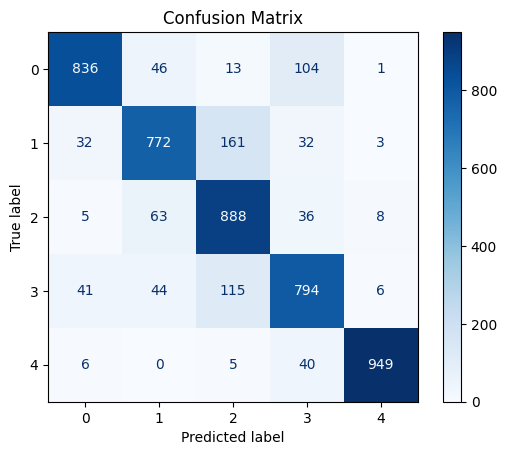

Precision: 0.85
Recall: 0.85
F1-score: 0.85
IoU (Jaccard Score): 0.74


0      1       2       3      4   Total  \
0                  836.0   46.0    13.0   104.0    1.0  1000.0   
1                   32.0  772.0   161.0    32.0    3.0  1000.0   
2                    5.0   63.0   888.0    36.0    8.0  1000.0   
3                   41.0   44.0   115.0   794.0    6.0  1000.0   
4                    6.0    0.0     5.0    40.0  949.0  1000.0   
Total              920.0  925.0  1182.0  1006.0  967.0  5000.0   
Recall (producer)   83.6   77.2    88.8    79.4   94.9           
Overall Accuracy                                                 

                  Precision (user)  
0                            90.87  
1                            83.46  
2                            75.13  
3                            78.93  
4                            98.14  
Total                               
Recall (producer)                   
Overall Accuracy             84.78

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display

class_names = ['0', '1', '2', '3','4']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column

# Append a total predictions row and recall row
metrics_df.loc['Total'] = metrics_df.sum(axis=0)
metrics_df.loc['Total', 'Precision (user)'] = ''  # Set to empty for clarity

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = metrics_df.append(recall_row)

# Add overall accuracy to the DataFrame
metrics_df.loc['Overall Accuracy'] = ['', '', '', '', '', '', overall_accuracy]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df

# Save the DataFrame to a CSV file
# metrics_df.to_csv('Results_models/ViT_transfomer/st_model_performance_metrics10.csv', index=True)

# print("Metrics table saved to 'model_performance_metrics.csv'.")


157/157 [==============================] - 1s 8ms/step


/tmp/ipykernel_447/255465410.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(total_row)


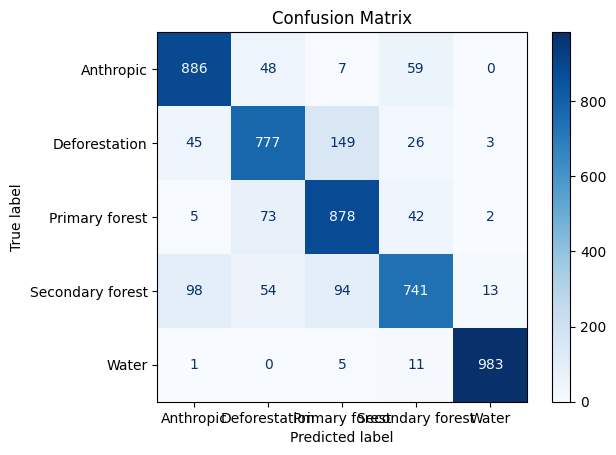

Precision: 0.85
Recall: 0.85
F1-score: 0.85
IoU (Jaccard Score): 0.75
                  Anthropic Deforestation Primary forest Secondary forest  \
Anthropic             886.0          48.0            7.0             59.0   
Deforestation          45.0         777.0          149.0             26.0   
Primary forest          5.0          73.0          878.0             42.0   
Secondary forest       98.0          54.0           94.0            741.0   
Water                   1.0           0.0            5.0             11.0   
Total                1035.0         952.0         1133.0            879.0   
Recall (producer)      88.6          77.7           87.8             74.1   
Overall Accuracy                                                            

                    Water   Total Precision (user) F1-Score  
Anthropic             0.0  1000.0             85.6    87.08  
Deforestation         3.0  1000.0            81.62    79.61  
Primary forest        2.0  1000.0            77.49

/tmp/ipykernel_447/255465410.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(total_row)


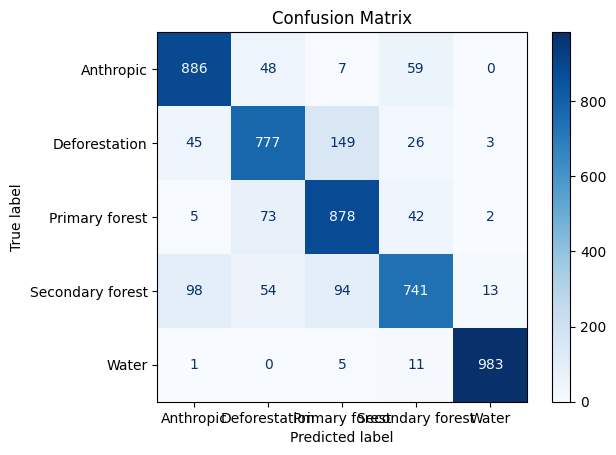

Precision: 0.85
Recall: 0.85
F1-score: 0.85
IoU (Jaccard Score): 0.75


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column
metrics_df['F1-Score'] = np.round(f1_scores * 100, 2)  # Add F1 score as a column

# Append a total predictions row
total_row = pd.Series(metrics_df.sum(axis=0), name='Total')
total_row['Precision (user)'] = ''
total_row['F1-Score'] = ''
metrics_df = metrics_df.append(total_row)

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([recall_row])])

# Add overall accuracy to the DataFrame
overall_accuracy_row = pd.Series([''] * (metrics_df.shape[1] - 1) + [overall_accuracy], index=metrics_df.columns, name='Overall Accuracy')
metrics_df = pd.concat([metrics_df, pd.DataFrame([overall_accuracy_row])])

# Reorder the columns to match the desired structure
columns_order = class_names + ['Total', 'Precision (user)', 'F1-Score']
metrics_df = metrics_df[columns_order]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
print(metrics_df)

# Save the DataFrame to a CSV file
# metrics_df.to_csv('Results_models/ViT_transfomer/st_model_performance_metrics10.csv', index=True)
# print("Metrics table saved to 'model_performance_metrics.csv'.")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column
metrics_df['F1-Score'] = np.round(f1_scores * 100, 2)  # Add F1 score as a column

# Append a total predictions row
total_row = pd.Series(metrics_df.sum(axis=0), name='Total')
total_row['Precision (user)'] = ''
total_row['F1-Score'] = ''
metrics_df = metrics_df.append(total_row)

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 3).tolist() + ['', '', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([recall_row])])

# Add overall accuracy to the DataFrame
overall_accuracy_row = pd.Series([''] * (metrics_df.shape[1] - 1) + [overall_accuracy], index=metrics_df.columns, name='Overall Accuracy')
metrics_df = pd.concat([metrics_df, pd.DataFrame([overall_accuracy_row])])

# Reorder the columns to match the desired structure
columns_order = class_names + ['Total', 'Precision (user)', 'F1-Score']
metrics_df = metrics_df[columns_order]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df.head()

# Save the DataFrame to a CSV file
metrics_df.to_csv('Results_models/ViT_transfomer/st_model_performance_metrics10_2.csv', index=True)
# print("Metrics table saved to 'model_performance_metrics.csv'.")


157/157 [==============================] - 1s 8ms/step


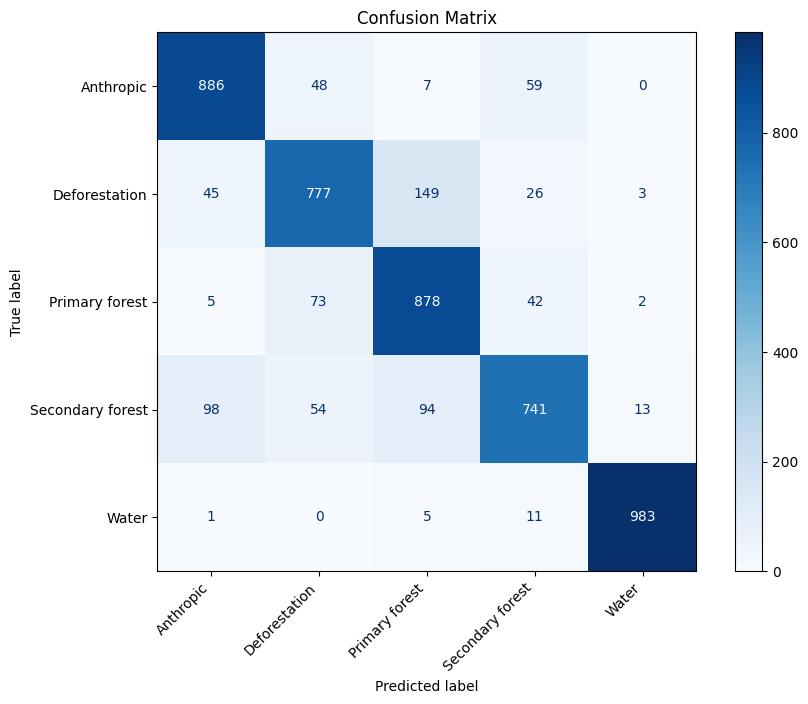

Precision: 0.85
Recall: 0.85
F1-score: 0.85
IoU (Jaccard Score): 0.75
                  Anthropic Deforestation Primary forest Secondary forest  \
Anthropic             886.0          48.0            7.0             59.0   
Deforestation          45.0         777.0          149.0             26.0   
Primary forest          5.0          73.0          878.0             42.0   
Secondary forest       98.0          54.0           94.0            741.0   
Water                   1.0           0.0            5.0             11.0   
Total                1035.0         952.0         1133.0            879.0   
Recall (producer)      88.6          77.7           87.8             74.1   
Precision (user)       85.6         81.62          77.49             84.3   
Overall Accuracy                                                            

                    Water   Total Precision (user) F1-Score  
Anthropic             0.0  1000.0             85.6    87.08  
Deforestation         3.0  1000.0  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column
metrics_df['F1-Score'] = np.round(f1_scores * 100, 2)  # Add F1 score as a column

# Append a total predictions row
total_row = pd.Series(metrics_df.sum(axis=0), name='Total')
total_row['Precision (user)'] = ''
total_row['F1-Score'] = ''
metrics_df = pd.concat([metrics_df, pd.DataFrame([total_row])])

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([recall_row])])

# Append precision (user) row at the bottom
precision_row = pd.Series(np.round(precision * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Precision (user)')
metrics_df = pd.concat([metrics_df, pd.DataFrame([precision_row])])

# Add overall accuracy to the DataFrame
overall_accuracy_row = pd.Series([''] * (metrics_df.shape[1] - 2) + [overall_accuracy, ''], index=metrics_df.columns, name='Overall Accuracy')
metrics_df = pd.concat([metrics_df, pd.DataFrame([overall_accuracy_row])])

# Reorder the columns to match the desired structure
columns_order = class_names + ['Total', 'Precision (user)', 'F1-Score']
metrics_df = metrics_df[columns_order]

# Display the confusion matrix with rotated labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 7))  # Adjust the size as needed
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to 45 degrees
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df

# Save the DataFrame to a CSV file
metrics_df.to_csv('Results_models/ViT_transfomer/st_model_performance_metrics10.csv', index=True)
# print("Metrics table saved to 'model_performance_metrics.csv'.")


157/157 [==============================] - 1s 9ms/step


/tmp/ipykernel_446/3550909515.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(recall_row)


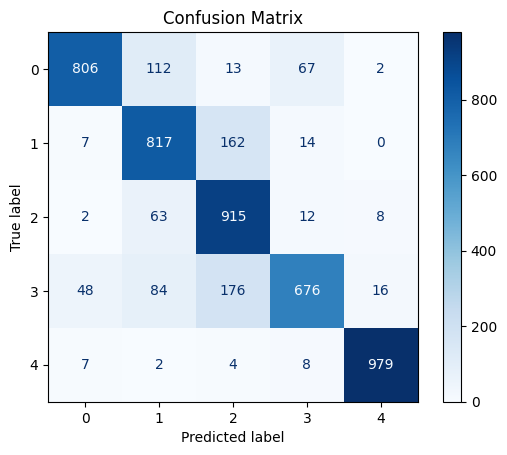

Precision: 0.85
Recall: 0.84
F1-score: 0.84
IoU (Jaccard Score): 0.73


0      1      2      3      4   Total Precision (user) F1 Score
0  806.0  112.0   13.0   67.0    2.0  1000.0            92.64     86.2
1    7.0  817.0  162.0   14.0    0.0  1000.0            75.79    78.63
2    2.0   63.0  915.0   12.0    8.0  1000.0            72.05    80.62
3   48.0   84.0  176.0  676.0   16.0  1000.0             87.0    76.08
4    7.0    2.0    4.0    8.0  979.0  1000.0            97.41    97.66

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, jaccard_score, accuracy_score

# Assuming 'model', 'X_test', and 'y_test' are correctly configured and defined
# Make predictions on the test set
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to predicted class indices
y_true = np.argmax(y_test, axis=1)       # Convert one-hot encoded labels to class indices

# Define class names for the confusion matrix display
class_names = ['0', '1', '2', '3', '4']

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])

# Calculate precision, recall, F1-score, and overall accuracy for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1_scores = f1_score(y_true, y_pred, average=None)
overall_accuracy = accuracy_score(y_true, y_pred) * 100  # multiplied by 100 for percentage

# Creating a DataFrame from the confusion matrix
metrics_df = pd.DataFrame(cm, index=class_names, columns=class_names)
metrics_df['Total'] = metrics_df.sum(axis=1)  # Total predictions per class
metrics_df['Precision (user)'] = np.round(precision * 100, 2)  # Add precision as a column
metrics_df['F1 Score'] = np.round(f1_scores * 100, 2)  # Add F1 score as a column

# Append a total predictions row and recall row
metrics_df.loc['Total'] = metrics_df.sum(axis=0)
metrics_df.loc['Total', ['Precision (user)', 'F1 Score']] = ''  # Set to empty for clarity

# Append a recall row at the bottom
recall_row = pd.Series(np.round(recall * 100, 2).tolist() + ['', '', ''], index=metrics_df.columns, name='Recall (producer)')
metrics_df = metrics_df.append(recall_row)

# Add overall accuracy to the DataFrame
metrics_df.loc['Overall Accuracy'] = ['', '', '', '', '', '', '', overall_accuracy]

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print calculated metrics
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1-score: {np.mean(f1_scores):.2f}')
print(f'IoU (Jaccard Score): {jaccard_score(y_true, y_pred, average="weighted"):.2f}')

# Print the complete metrics table including totals and recall
metrics_df.head()

# Save the DataFrame to a CSV file
# metrics_df.to_csv('Results_models/CNN_transfomer_5images/st_model_performance_metrics10_2.csv', index=True)
# print("Metrics table saved to 'model_performance_metrics.csv'.")


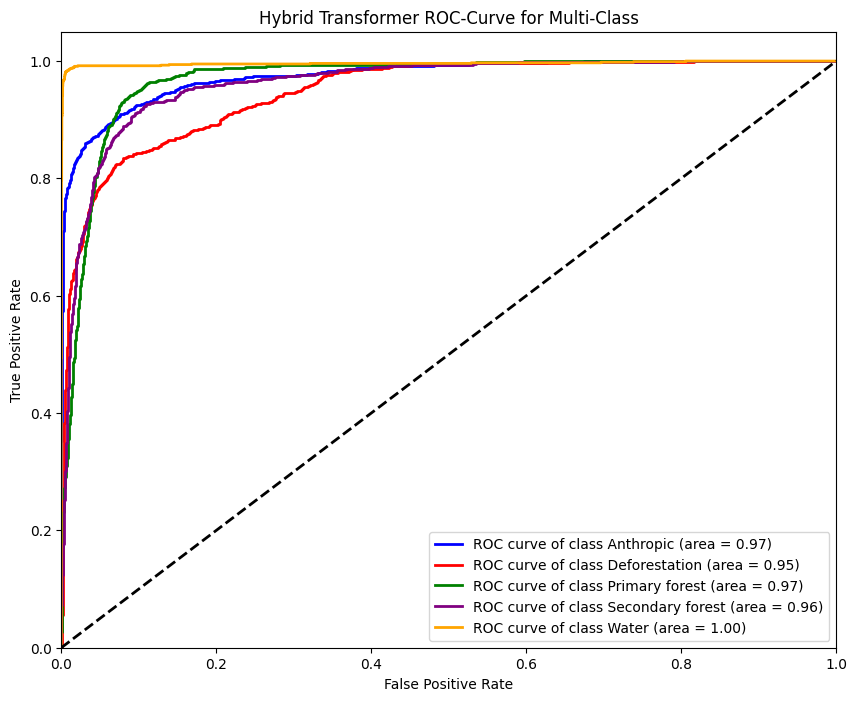

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Transformer ROC-Curve for Multi-Class')
plt.legend(loc="lower right")
plt.savefig('Results_models/CNN_transfomer_5images/CNN_ROC_curves.png')
plt.show()


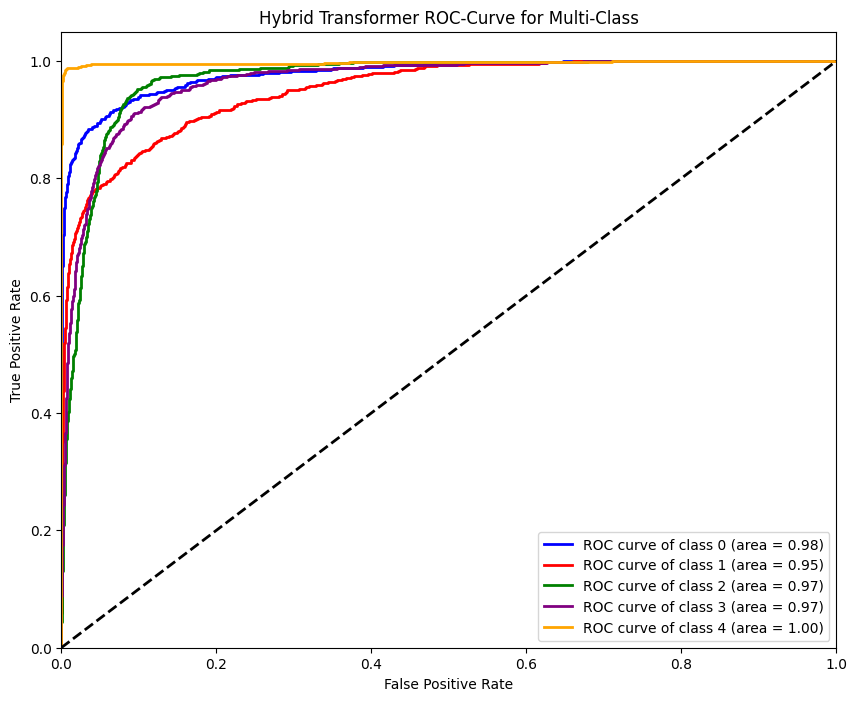

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Transformer ROC-Curve for Multi-Class')
plt.legend(loc="lower right")
# plt.savefig('Results_models/CNN_transfomer_5images/CNN_ROC_curves.png')
plt.show()


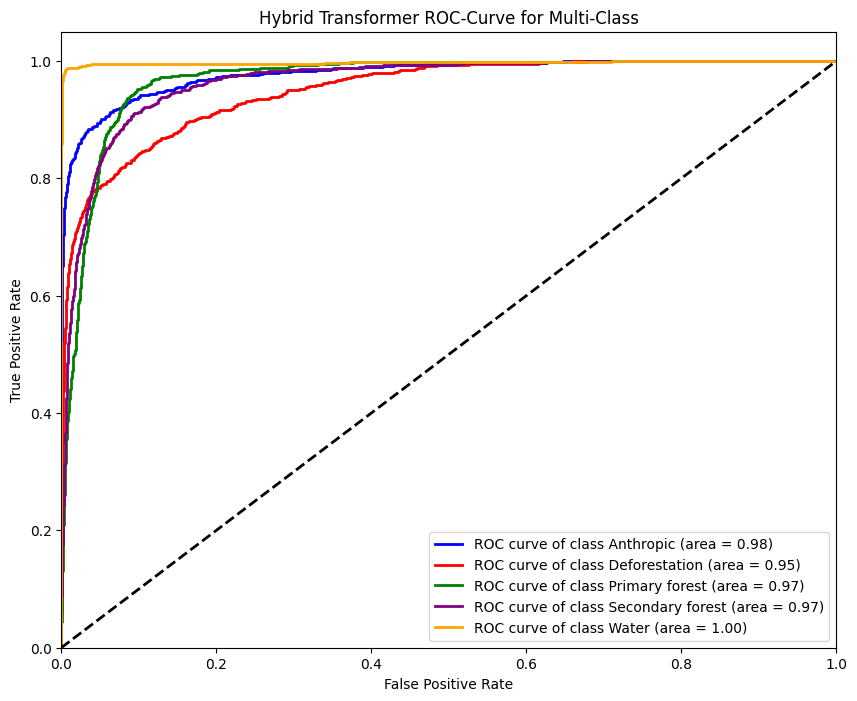

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Transformer ROC-Curve for Multi-Class')
plt.legend(loc="lower right")
# plt.savefig('Results_models/CNN_transfomer_5images/CNN_ROC_curves.png')
plt.show()


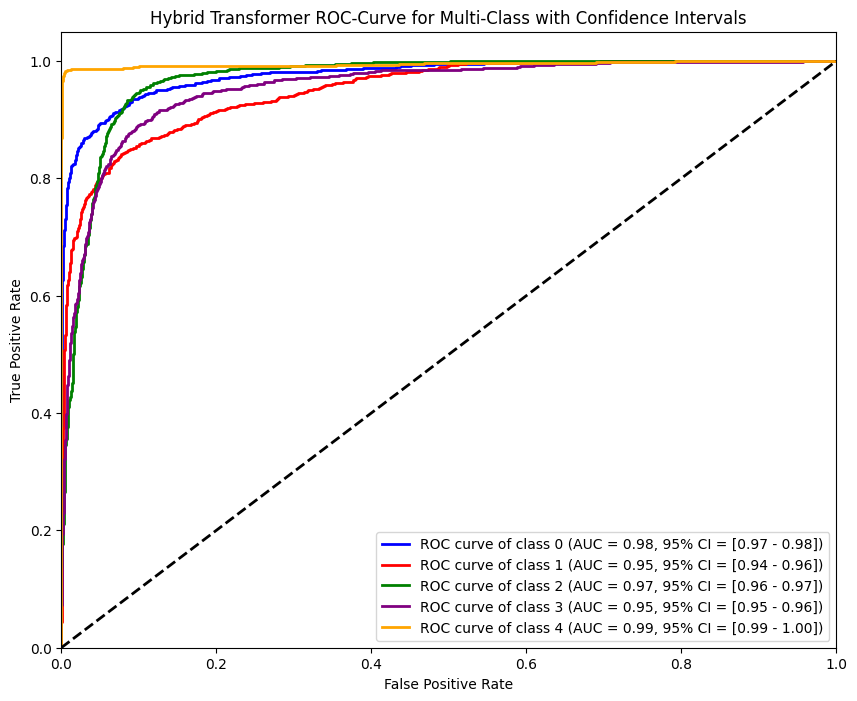

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' are available and 'y_test' is one-hot encoded
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Function to compute AUC with bootstrapping
def bootstrap_auc(y_true, y_pred, n_bootstraps=1000, seed=42):
    bootstrapped_aucs = []
    rng = np.random.RandomState(seed)
    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_aucs.append(score)
    
    sorted_scores = np.array(bootstrapped_aucs)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return confidence_lower, confidence_upper

# Calculate bootstrap confidence intervals for ROC-AUC
ci = dict()
for i in range(n_classes):
    ci[i] = bootstrap_auc(y_test_binarized[:, i], predictions[:, i])

# Plot all ROC curves with confidence intervals
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (AUC = {1:0.2f}, 95% CI = [{2:0.2f} - {3:0.2f}])'.format(i, roc_auc[i], ci[i][0], ci[i][1]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Transformer ROC-Curve for Multi-Class with Confidence Intervals')
plt.legend(loc="lower right")
# plt.savefig('Results_models/CNN_transfomer_5images/CNN_ROC_curves_with_CI.png')
plt.show()


   Class   ROC AUC  Bootstrap 95% CI Lower  Bootstrap 95% CI Upper  \
0      0  0.976548                0.971573                0.981385   
1      1  0.951467                0.944496                0.957679   
2      2  0.968253                0.963364                0.972510   
3      3  0.960341                0.953993                0.966105   
4      4  0.994753                0.991557                0.997471   

   CV Mean AUC  CV Std AUC  
0     0.975286    0.015909  
1     0.955466    0.027774  
2     0.967775    0.025833  
3     0.958691    0.016143  
4     0.995898    0.003202  


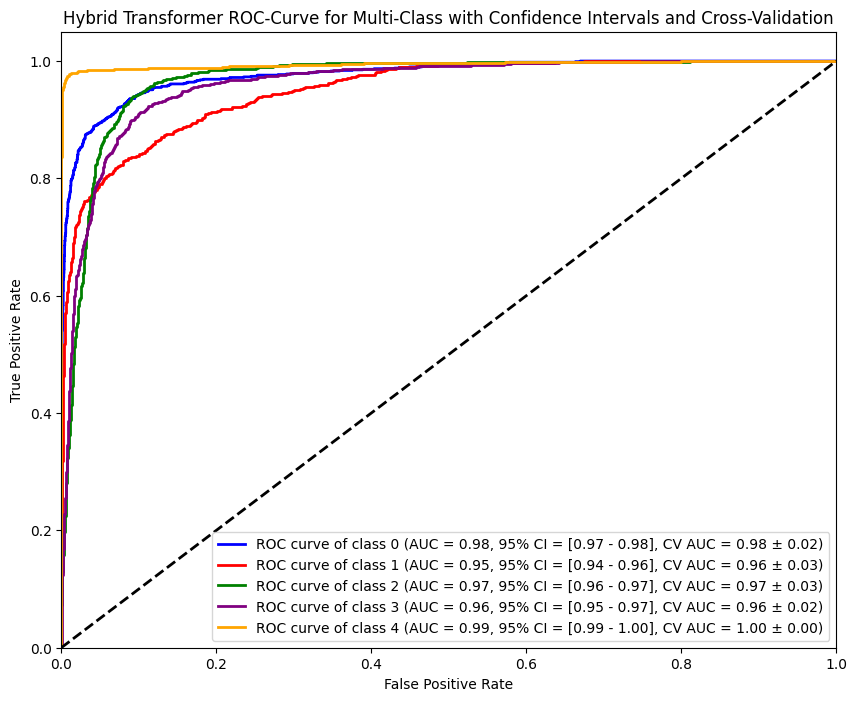

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'predictions' and 'y_test' are available
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Function to compute AUC with bootstrapping
def bootstrap_auc(y_true, y_pred, n_bootstraps=1000, seed=42):
    bootstrapped_aucs = []
    rng = np.random.RandomState(seed)
    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_aucs.append(score)
    
    sorted_scores = np.array(bootstrapped_aucs)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return confidence_lower, confidence_upper

# Function to compute AUC with cross-validation
def cross_val_auc(y_true, y_pred, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    aucs = []
    for train_index, test_index in skf.split(y_pred, y_true):
        auc_score = roc_auc_score(y_true[test_index], y_pred[test_index])
        aucs.append(auc_score)
    
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    return mean_auc, std_auc

# Calculate bootstrap confidence intervals for ROC-AUC
ci_bootstrap = dict()
for i in range(n_classes):
    ci_bootstrap[i] = bootstrap_auc(y_test_binarized[:, i], predictions[:, i])

# Calculate cross-validation mean and standard deviation for ROC-AUC
cv_results = dict()
for i in range(n_classes):
    cv_results[i] = cross_val_auc(y_test_binarized[:, i], predictions[:, i])

# Generate table
table_data = []
for i in range(n_classes):
    table_data.append({
        'Class': i,
        'ROC AUC': roc_auc[i],
        'Bootstrap 95% CI Lower': ci_bootstrap[i][0],
        'Bootstrap 95% CI Upper': ci_bootstrap[i][1],
        'CV Mean AUC': cv_results[i][0],
        'CV Std AUC': cv_results[i][1]
    })

df = pd.DataFrame(table_data)
print(df)

# Plot all ROC curves with confidence intervals and cross-validation results
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (AUC = {1:0.2f}, 95% CI = [{2:0.2f} - {3:0.2f}], CV AUC = {4:0.2f} ± {5:0.2f})'.format(
                 i, roc_auc[i], ci_bootstrap[i][0], ci_bootstrap[i][1], cv_results[i][0], cv_results[i][1]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Transformer ROC-Curve for Multi-Class with Confidence Intervals and Cross-Validation')
plt.legend(loc="lower right")
plt.savefig('Results_models/CNN_transfomer_5images/CNN_ROC_curves_with_CI_and_CV.png')
plt.show()

# Save the table to a CSV file
df.to_csv('Results_models/CNN_transfomer_5images/CNN_ROC_AUC_summary.csv', index=False)


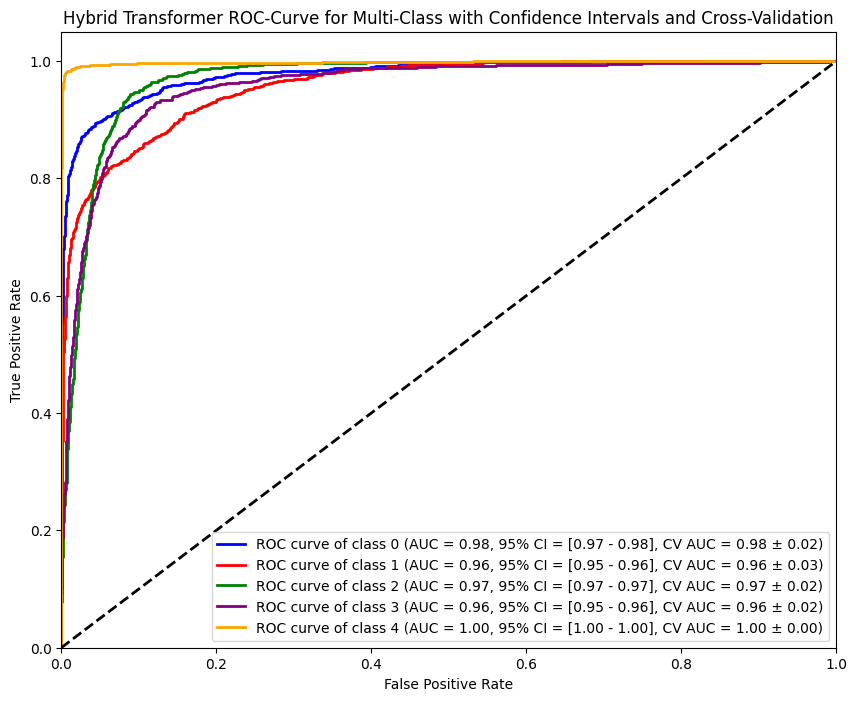

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'predictions' and 'y_test' are available
# Convert 'y_test' from one-hot encoding to class indices if necessary
y_true = np.argmax(y_test, axis=1)

# Binarize the output classes for ROC curve compatibility
n_classes = y_test.shape[1]
y_test_binarized = label_binarize(y_true, classes=range(n_classes))

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Function to compute AUC with bootstrapping
def bootstrap_auc(y_true, y_pred, n_bootstraps=1000, seed=42):
    bootstrapped_aucs = []
    rng = np.random.RandomState(seed)
    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_aucs.append(score)
    
    sorted_scores = np.array(bootstrapped_aucs)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return confidence_lower, confidence_upper

# Function to compute AUC with cross-validation
def cross_val_auc(y_true, y_pred, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    aucs = []
    for train_index, test_index in skf.split(y_pred, y_true):
        auc_score = roc_auc_score(y_true[test_index], y_pred[test_index])
        aucs.append(auc_score)
    
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    return mean_auc, std_auc

# Calculate bootstrap confidence intervals for ROC-AUC
ci_bootstrap = dict()
for i in range(n_classes):
    ci_bootstrap[i] = bootstrap_auc(y_test_binarized[:, i], predictions[:, i])

# Calculate cross-validation mean and standard deviation for ROC-AUC
cv_results = dict()
for i in range(n_classes):
    cv_results[i] = cross_val_auc(y_test_binarized[:, i], predictions[:, i])

# Plot all ROC curves with confidence intervals and cross-validation results
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label='ROC curve of class {0} (AUC = {1:0.2f}, 95% CI = [{2:0.2f} - {3:0.2f}], CV AUC = {4:0.2f} ± {5:0.2f})'.format(
                 i, roc_auc[i], ci_bootstrap[i][0], ci_bootstrap[i][1], cv_results[i][0], cv_results[i][1]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Hybrid Transformer ROC-Curve for Multi-Class with Confidence Intervals and Cross-Validation')
plt.legend(loc="lower right")
# plt.savefig('Results_models/CNN_transfomer_5images/CNN_ROC_curves_with_CI_and_CV.png')
plt.show()


In [ ]:
# Print the complete metrics table including totals and recall
metrics_df

# Save the DataFrame to a CSV file
metrics_df.to_csv('Results_models/ViT_transfomer/st_performance_metrics10.csv', index=True)

print("Metrics table saved to 'model_performance_metrics.csv'.")


Metrics table saved to 'model_performance_metrics.csv'.


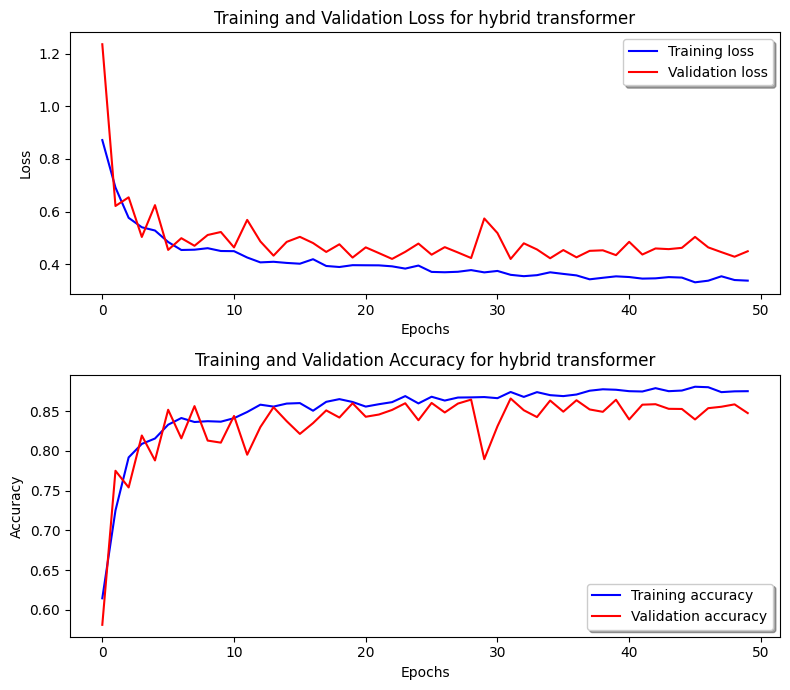

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history.history' contains your training history data
fig, ax = plt.subplots(2, 1, figsize=(8, 7))

# Plot for training and validation loss
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
ax[0].legend(loc='best', shadow=True)
ax[0].set_title('Training and Validation Loss for hybrid transformer')  # Add a title to the first subplot
ax[0].set_xlabel('Epochs')  # Optional: Add x-axis label if needed
ax[0].set_ylabel('Loss')    # Add y-axis label

# Plot for training and validation accuracy
ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)
ax[1].set_title('Training and Validation Accuracy for hybrid transformer')  # Add a title to the second subplot
ax[1].set_xlabel('Epochs')  # Add x-axis label
ax[1].set_ylabel('Accuracy')  # Add y-axis label

plt.tight_layout()  # Adjust layout to prevent overlap
# plt.savefig('Results_models/CNN_transfomer_5images/hy10_training_history.png')
plt.show()  # Display the figure


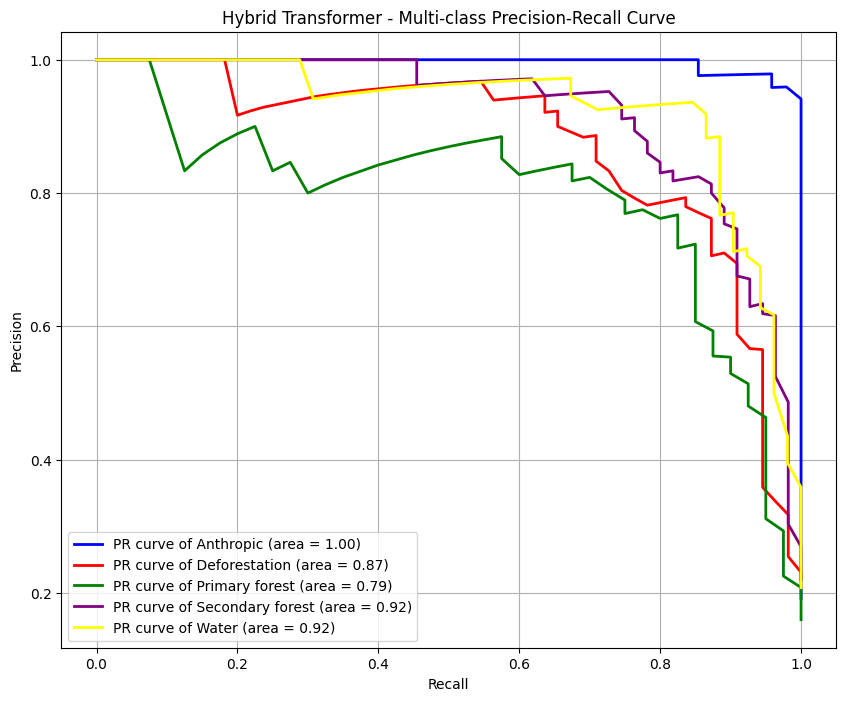

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Generate a synthetic multi-class classification dataset
X, y = make_classification(n_samples=1000, n_features=20,
                           n_classes=5, random_state=42, n_informative=3,
                           n_clusters_per_class=1)

# Binarize the labels for a multi-class setup
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a model using OneVsRestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train, y_train)

# Predict probabilities
y_scores = classifier.predict_proba(X_test)

# Define class names for the legend
class_names = ['Anthropic', 'Deforestation', 'Primary forest', 'Secondary forest', 'Water']

# Setup plot details
colors = ['blue', 'red', 'green', 'purple', 'yellow']
plt.figure(figsize=(10, 8))

# Compute Precision-Recall curve and area for each class
for i, color, class_name in zip(range(n_classes), colors, class_names):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_scores[:, i])
    average_precision = average_precision_score(y_test[:, i], y_scores[:, i])
    
    plt.plot(recall, precision, color=color, lw=2,
             label='PR curve of {0} (area = {1:0.2f})'.format(class_name, average_precision))

plt.title('Hybrid Transformer - Multi-class Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('Results_models/CNN_transfomer_5images/PR_curve_classes.png')
plt.show()


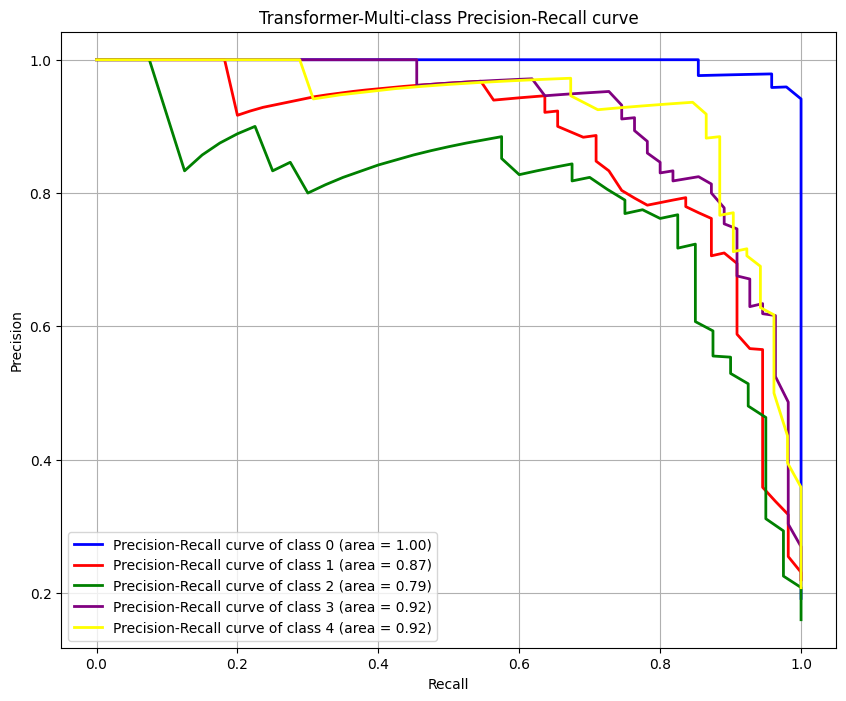

Bootstrap 95% CI for PR AUC:
Class 0: [0.9856 - 1.0000]
Class 1: [0.7785 - 0.9415]
Class 2: [0.6531 - 0.9083]
Class 3: [0.8563 - 0.9669]
Class 4: [0.8491 - 0.9766]
Cross-Validation Mean and Std for PR AUC:
Class 0: Mean PR AUC = 0.9830, Std PR AUC = 0.0128
Class 1: Mean PR AUC = 0.8429, Std PR AUC = 0.0520
Class 2: Mean PR AUC = 0.8688, Std PR AUC = 0.0517
Class 3: Mean PR AUC = 0.9190, Std PR AUC = 0.0237
Class 4: Mean PR AUC = 0.9485, Std PR AUC = 0.0217
   Class  Bootstrap Lower CI  Bootstrap Upper CI  CV Mean PR AUC  \
0      0            0.985580            1.000000        0.983048   
1      1            0.778518            0.941498        0.842900   
2      2            0.653131            0.908299        0.868821   
3      3            0.856296            0.966853        0.918996   
4      4            0.849131            0.976572        0.948482   

   CV Std PR AUC  
0       0.012764  
1       0.052014  
2       0.051668  
3       0.023701  
4       0.021660  


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd

# Generate a synthetic multi-class classification dataset
X, y = make_classification(n_samples=1000, n_features=20,
                           n_classes=5, random_state=42, n_informative=3,
                           n_clusters_per_class=1)

# Binarize the labels for a multi-class setup
y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a model using OneVsRestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train, y_train)

# Predict probabilities
y_scores = classifier.predict_proba(X_test)

# Setup plot details
colors = ['blue', 'red', 'green', 'purple', 'yellow']
plt.figure(figsize=(10, 8))

# Compute Precision-Recall curve and area for each class
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_scores[:, i])
    average_precision = average_precision_score(y_test[:, i], y_scores[:, i])
    
    plt.plot(recall, precision, color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision))

plt.title('Transformer-Multi-class Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('Results_models/CNN_transfomer_5images/st_PR_curve_classes.png')
plt.show()

# Quantify uncertainties using Bootstrap
def bootstrap_pr_auc(y_test, y_scores, n_classes, n_bootstraps=1000, random_seed=42):
    rng = np.random.RandomState(random_seed)
    pr_aucs = np.zeros((n_classes, n_bootstraps))

    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_scores), len(y_scores))
        for j in range(n_classes):
            if len(np.unique(y_test[indices, j])) < 2:
                continue
            precision, recall, _ = precision_recall_curve(y_test[indices, j], y_scores[indices, j])
            pr_aucs[j, i] = auc(recall, precision)

    ci_lower = np.percentile(pr_aucs, 2.5, axis=1)
    ci_upper = np.percentile(pr_aucs, 97.5, axis=1)
    return ci_lower, ci_upper

ci_lower, ci_upper = bootstrap_pr_auc(y_test, y_scores, n_classes)
print("Bootstrap 95% CI for PR AUC:")
for i in range(n_classes):
    print(f"Class {i}: [{ci_lower[i]:.4f} - {ci_upper[i]:.4f}]")

# Quantify uncertainties using Cross-Validation
def cross_val_pr_auc(model, X, y, cv=5):
    cv = StratifiedKFold(n_splits=cv)
    pr_aucs = np.zeros((n_classes, cv.n_splits))

    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X, np.argmax(y, axis=1))):
        model.fit(X[train_idx], y[train_idx])
        y_scores = model.predict_proba(X[test_idx])
        for j in range(n_classes):
            precision, recall, _ = precision_recall_curve(y[test_idx][:, j], y_scores[:, j])
            pr_aucs[j, fold_idx] = auc(recall, precision)

    mean_pr_auc = np.mean(pr_aucs, axis=1)
    std_pr_auc = np.std(pr_aucs, axis=1)
    return mean_pr_auc, std_pr_auc

mean_pr_auc, std_pr_auc = cross_val_pr_auc(classifier, X, y)
print("Cross-Validation Mean and Std for PR AUC:")
for i in range(n_classes):
    print(f"Class {i}: Mean PR AUC = {mean_pr_auc[i]:.4f}, Std PR AUC = {std_pr_auc[i]:.4f}")

# Create a DataFrame to store results
results = {
    'Class': range(n_classes),
    'Bootstrap Lower CI': ci_lower,
    'Bootstrap Upper CI': ci_upper,
    'CV Mean PR AUC': mean_pr_auc,
    'CV Std PR AUC': std_pr_auc
}

df_results = pd.DataFrame(results)
print(df_results)

# Save results to CSV
df_results.to_csv('Results_models/CNN_transfomer_5images/pr_auc_uncertainties.csv', index=False)


In [ ]:
# Correctly saving the model
model.save("Results_models/CNN_transfomer_5images/hy10_transformer_model.h5")

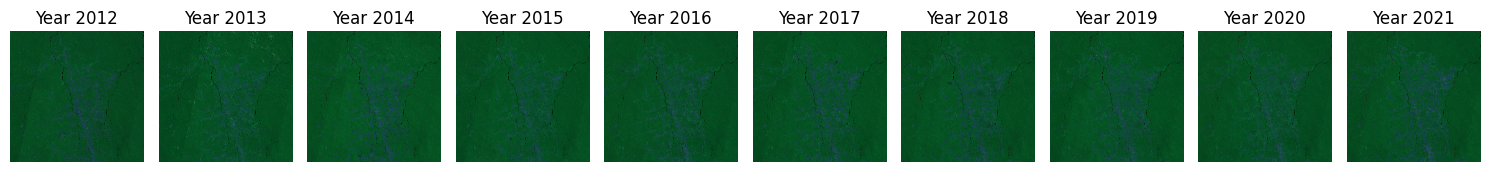

In [ ]:
import rasterio
import os
import numpy as np
from matplotlib import pyplot as plt

# Define the directory containing the satellite images
image_dir = './Images'

# Define the years of interest
years_of_interest = [2012, 2013,2014, 2015,2016, 2017,2018, 2019,2020, 2021]

# Define band indices for Landsat 5 and Landsat 8
landsat5_bands = [1, 2, 3, 4, 5]
landsat8_bands = [1, 2, 3, 4, 5]

# Generate image paths for the specified years
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

# Set up a matplotlib subplot grid, with images in a single row
fig, axes = plt.subplots(1, len(years_of_interest), figsize=(15, 3))

# Iterate over each image path and subplot axis
for ax, image_path in zip(axes, image_paths):
    with rasterio.open(image_path) as src:
        # Extract the year from the image path
        year = int(os.path.basename(image_path).split('_')[1].split('.')[0])
        bands_to_read = landsat5_bands if year < 2013 else landsat8_bands
        image = np.stack([src.read(band) for band in bands_to_read], axis=0)

        # Assuming Red, Green, and Blue channels are the last three bands
        rgb = np.dstack((image[-3], image[-2], image[-1]))

        # Display the image on the corresponding subplot axis
        ax.imshow(rgb)
        ax.axis('off')  # Turn off the axis
        ax.grid(True)  # Enable grid
        ax.set_title(f"Year {year}")  # Set title with the year

plt.tight_layout()  # Adjust layout
plt.show()  # Display all subplots


In [ ]:
# Correctly saving the model
model.save("Results_models/CNN_transfomer_5images/hy10_transformer_model.h5")

In [ ]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model("Results_models/CNN_transfomer_5images/hy10_transformer_model.h5")

# Display the model's architecture to verify it was loaded correctly
# loaded_model.summary()

In [ ]:
import rasterio
import os
import numpy as np
from matplotlib import pyplot as plt

# Define the image directory
image_dir = './Images'

# Define the years of interest
years_of_interest = [2012, 2013,2014, 2015,2016, 2017,2018, 2019,2020, 2021]

# Generate the paths for Landsat images for the specified years
image_paths = [os.path.join(image_dir, f'Landsat_{year}.tif') for year in years_of_interest]

# Define the Landsat bands
landsat_bands = [1, 2, 3, 4, 5]  # Band indices for Landsat 5, 8, etc.

# Initialize an empty list to store the stacked images
stacked_images = []

# Process each image
for image_path in image_paths:
    with rasterio.open(image_path) as src:
        # Extract the year from the image path
        year = int(os.path.basename(image_path).split('_')[1].split('.')[0])

        # Stack the bands without normalization
        image = np.stack([src.read(band) for band in landsat_bands], axis=0)

        # Append the raw bands to the list
        stacked_images.append(image)

# Stack the images along the first axis to create a single array
stacked_images_array = np.stack(stacked_images, axis=0)

# Check the shape of the stacked images array
print("Shape of stacked images array:", stacked_images_array.shape)


Shape of stacked images array: (10, 5, 7046, 7206)


In [ ]:
# Transpose the dimensions to bring the last two dimensions together
transposed_array = np.transpose(stacked_images_array, (2, 3, 0, 1))

# Reshape the transposed array
reshaped_array = transposed_array.reshape(-1, transposed_array.shape[3], transposed_array.shape[2])

# Check the shape of the reshaped array
print("Shape of reshaped array:", reshaped_array.shape)


Shape of reshaped array: (50773476, 5, 10)


In [ ]:
# # Reshape the array to the desired shape
# new_reshaped_array = reshaped_array.reshape(-1, 5, 10)

# # Check the shape of the new reshaped array
# print("Shape of newly reshaped array:", new_reshaped_array.shape)

In [ ]:
# flat_predicted = loaded_model.predict(reshaped_array, batch_size=30)
# flat_predicted.shape

In [ ]:
import tensorflow as tf

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Run prediction on CPU
with tf.device('/CPU:0'):
    flat_predicted = loaded_model.predict(reshaped_array, batch_size=32)
    flat_predicted.shape


Physical devices cannot be modified after being initialized
1586672/1586672 [==============================] - 16187s 10ms/step


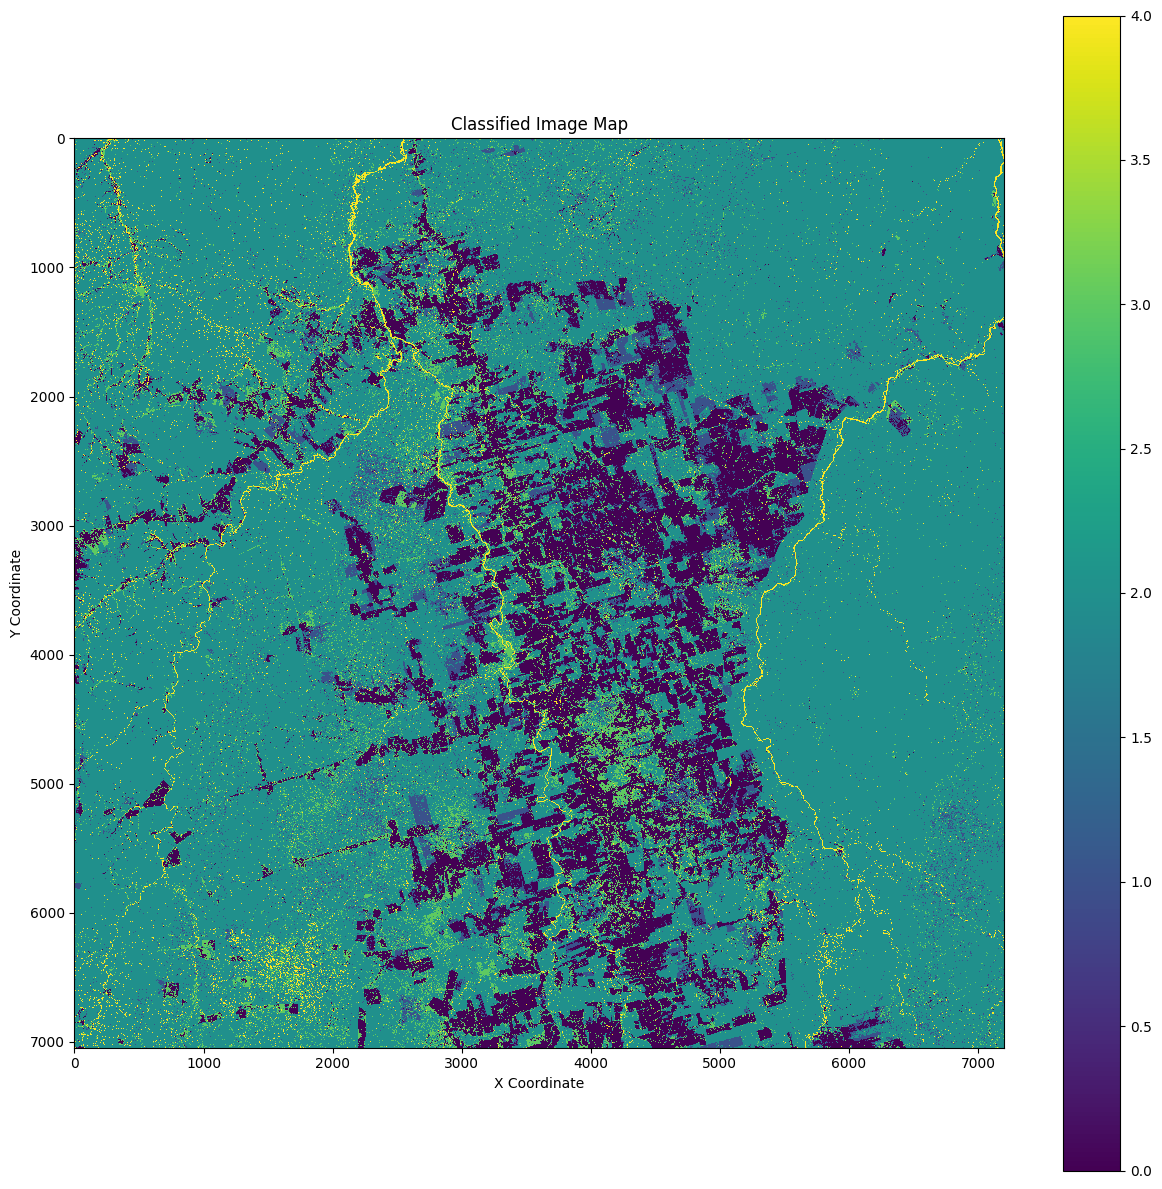

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume you've already computed predicted_classes from flat_predicted
predicted_classes = np.argmax(flat_predicted, axis=1)

# Reshape to the chosen dimensions
try:
    dimensions = (7046, 7206)  # Chosen from your provided possible dimensions
    classified_image = predicted_classes.reshape(dimensions)

    # Plot the reshaped array as an image
    plt.figure(figsize=(15, 15))  # Set figure size to something large for better visibility
    plt.imshow(classified_image, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Classified Image Map')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()
except Exception as e:
    print("Error in reshaping or plotting:", str(e))


In [ ]:
  import rasterio
import os

# Define the image directory and file names
image_dir = "./Images"
image_path_2021 = os.path.join(image_dir, "Landsat_2021.tif")

# Load the image using rasterio and keep it open
with rasterio.open(image_path_2021) as src:
    # Read the image data
    image_data = src.read()
    
    # Assuming 'classified_image' is your classified map with shape (height, width)
    
    # Reshape the classified image to (height, width)
    classified_image_reshaped = classified_image.reshape(1, *classified_image.shape)
    
    # Save the prediction results
    with rasterio.open("Results_models/CNN_transfomer_5images/NEW_st_10_predicted2021.tif", 'w', **src.profile) as dst:
        # Write the classified map to the output raster file
        dst.write(classified_image_reshaped[0], 1)
  

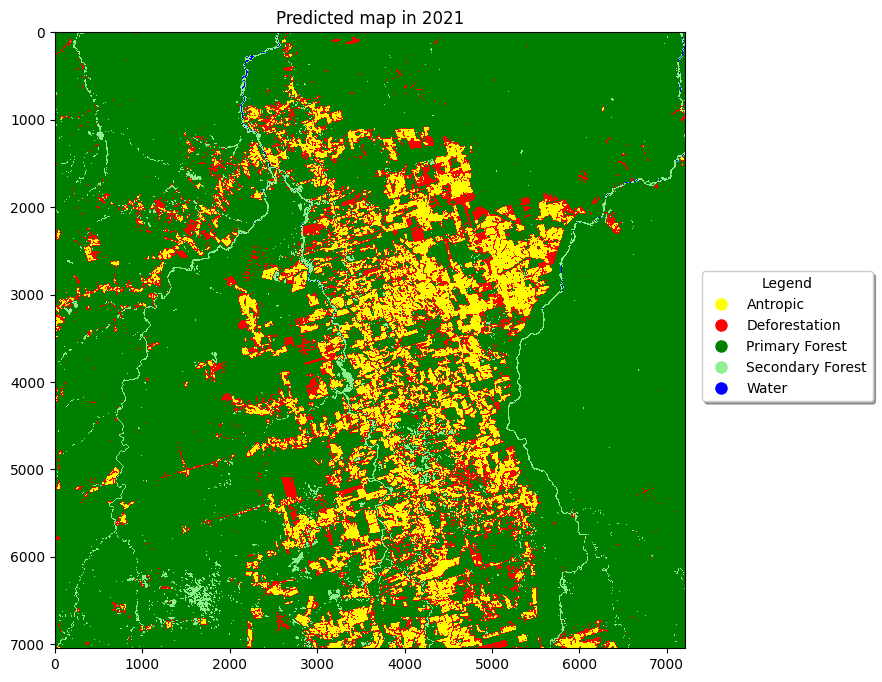

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the path to the classified image
classified_image_path = "Results_models/CNN_transfomer_5images/NEW_st_10_predicted2021.tif"

# Load the classified image using rasterio
with rasterio.open(classified_image_path) as src:
    # Read the image data (assuming the classification results are in the first band)
    classified_image = src.read(1)  # Reading the first band

# Class mapping dictionary
# Define class names for the confusion matrix
class_mapping = {0: "Antropic", 1: "Deforestation", 2: "Primary Forest", 3: "Secondary Forest", 4: "Water"}

# Define colors for each class
colors = ['yellow', 'red', 'green', 'lightgreen', 'blue']  # Example colors for each class
cmap = mcolors.ListedColormap(colors)

# Create a normalized colorbar
bounds = np.arange(-0.5, len(class_mapping) + 0.5)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the image
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figsize as needed

# Plot the image
im = ax.imshow(classified_image, cmap=cmap, norm=norm)
ax.set_title('Predicted map in 2021')

# Place grid values on left and bottom edges
ax.tick_params(axis='both', which='both', bottom=True, left=True)

# Add legend beside the map
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=colors[index], markersize=10) 
                   for index, label in class_mapping.items()]
ax_legend = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust position and size of the legend axis
ax_legend.legend(handles=legend_elements, loc='center', shadow=True, fancybox=True, title='Legend')
ax_legend.axis('off')  # Hide the axis for the legend

# Save the plot as a JPEG image
plt.savefig('10classified_map2021.png', format='png')
plt.show()


In [ ]:
import rasterio
import numpy as np
import matplotlib.colors as mcolors

# Define the path to the classified image
classified_image_path = "Results_models/CNN_transfomer_5images/NEW_st_10_predicted2021.tif"

# Load the classified image using rasterio
with rasterio.open(classified_image_path) as src:
    # Read the image data (assuming the classification results are in the first band)
    classified_image = src.read(1)  # Reading the first band
    # Read the metadata
    metadata = src.meta.copy()

# Class mapping dictionary
class_mapping = {0: "Antropic", 1: "Deforestation", 2: "Primary Forest", 3: "Secondary Forest", 4: "Water"}

# Define colors for each class (though this won't be used directly in the output file, it's useful for reference)
colors = ['yellow', 'red', 'green', 'lightgreen', 'blue']

# Update metadata for a single-band image
metadata.update({
    'count': 1,  # Single-band image
    'dtype': 'uint8'
})

# Define the path to save the new GeoTIFF
output_path = "Results_models/CNN_transfomer_5images/classified_map2021.tiff"

# Save the single-band classified image as a GeoTIFF
with rasterio.open(output_path, 'w', **metadata) as dst:
    dst.write(classified_image, 1)

print(f"Classified map saved as GeoTIFF at: {output_path}")


Classified map saved as GeoTIFF at: Results_models/CNN_transfomer_5images/classified_map2021.tiff


Unique class values in the image: [0. 1. 2. 3. 4.]


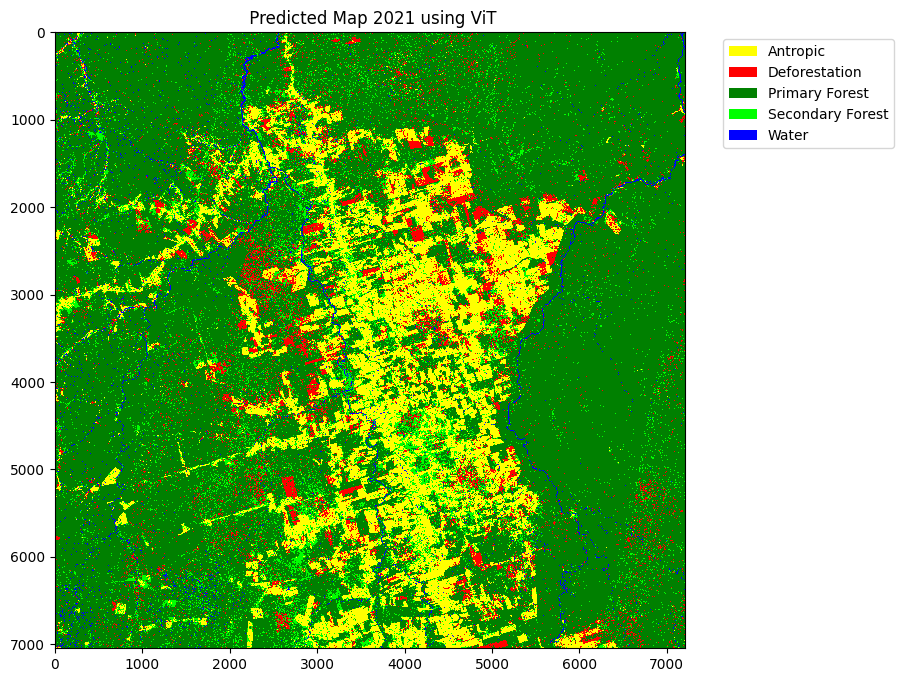

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def debug_unique_values(image):
    # This function will print the unique values found in the image
    unique_values = np.unique(image)
    print("Unique class values in the image:", unique_values)

# Load the classified image
with rasterio.open("Results_models/CNN_transfomer_5images/st_10_predicted2021.tif") as src:
    classified_image = src.read(1)

# Debug to check unique values in the classified image
debug_unique_values(classified_image)

# Define colors assuming indices are correct: 0 - Antropic, 1 - Deforestation, 2 - Primary Forest, 
# 3 - Secondary Forest, 4 - Water
colors = ['#FFFF00', '#FF0000', '#008000', '#00FF00', '#0000FF']  # Yellow, Red, Green, Lime, Blue
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(np.arange(-0.5, 5, 1), cmap.N)

# Plot the image
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(classified_image, cmap=cmap, norm=norm, interpolation='nearest')
ax.set_title(' Predicted Map 2021 using ViT')

# Define legend with custom colored patches
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FFFF00', label='Antropic'),
    Patch(facecolor='#FF0000', label='Deforestation'),
    Patch(facecolor='#008000', label='Primary Forest'),
    Patch(facecolor='#00FF00', label='Secondary Forest'),
    Patch(facecolor='#0000FF', label='Water')
]

# Add the legend to the plot
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('Vit10_classified_map2021.png', format='png')
plt.show()


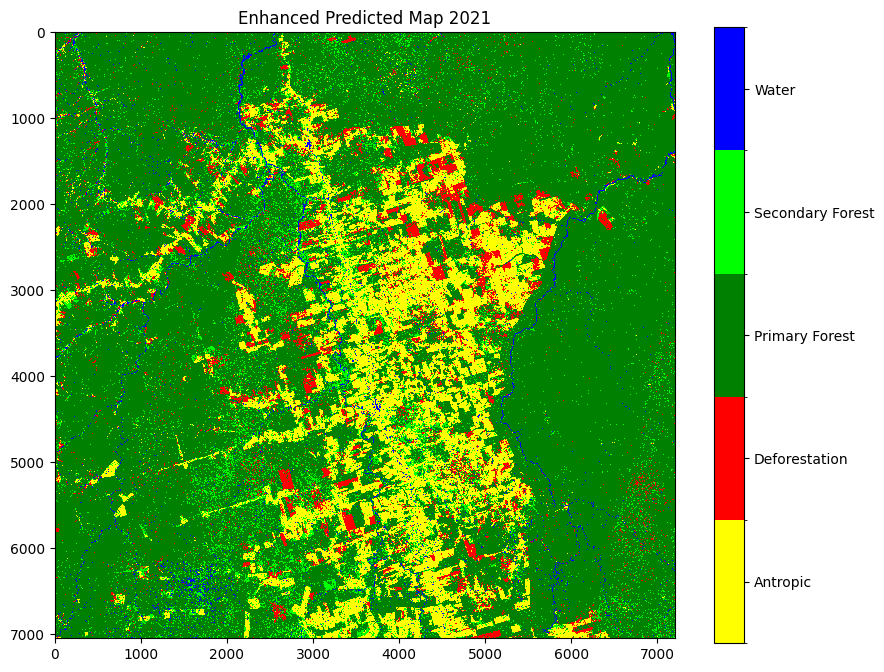

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the path to the classified image
classified_image_path = "Results_models/CNN_transfomer_5images/Final_CNN_predicted2021.tif"

# Load the classified image using rasterio
with rasterio.open(classified_image_path) as src:
    classified_image = src.read(1)

# Enhance visibility by manipulating the image display properties
# Adjust interpolation and aspect ratio
fig, ax = plt.subplots(figsize=(10, 8))
cmap = mcolors.ListedColormap(['yellow', 'red', 'green', 'lime', 'blue'])
norm = mcolors.BoundaryNorm(np.arange(-0.5, 5, 1), cmap.N)
im = ax.imshow(classified_image, cmap=cmap, norm=norm, interpolation='nearest')

ax.set_title('Enhanced Predicted Map 2021')
cbar = fig.colorbar(im, ax=ax, ticks=np.arange(0, 5))
cbar.ax.set_yticklabels(['Antropic', 'Deforestation', 'Primary Forest', 'Secondary Forest', 'Water'])  # Set text labels

plt.savefig('enhanced_classified_map2021.png', format='png')
plt.show()


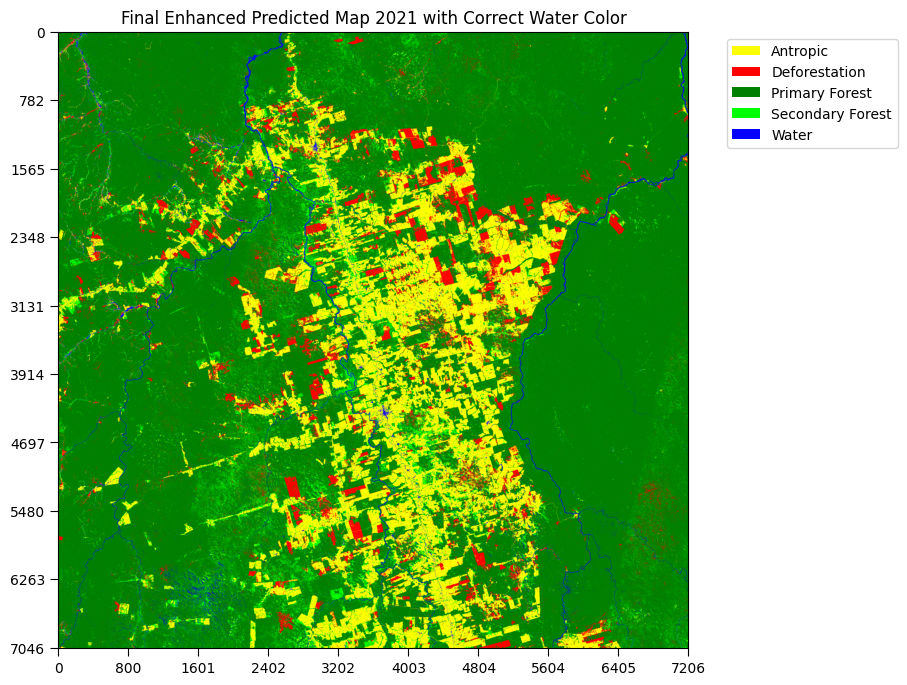

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the classified image
with rasterio.open("Results_models/CNN_transfomer_5images/Final_CNN_predicted2021.tif") as src:
    classified_image = src.read(1)

# Define your specific color mapping and class names
color_mapping = {
    0: ('Antropic', '#FFFF00'),  # Antropic - Yellow
    1: ('Deforestation', '#FF0000'),  # Deforestation - Red
    2: ('Primary Forest', '#008000'),  # Primary Forest - Green
    3: ('Secondary Forest', '#00FF00'),  # Secondary Forest - Lime
    4: ('Water', '#0000FF')  # Water - Blue
}

# Convert class indices to RGB values
rgb_image = np.zeros((*classified_image.shape, 3), dtype=float)
for k, (name, hex_color) in color_mapping.items():
    rgb_color = np.array([int(hex_color[i:i+2], 16) for i in (1, 3, 5)]) / 255.0
    mask = classified_image == k
    rgb_image[mask] = rgb_color

# Plot the RGB image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(rgb_image)
ax.set_title('Final Enhanced Predicted Map 2021 with Correct Water Color')

# Enable axes to set ticks and grid lines on borders
ax.axis('on')  # Enable axis

# Set more frequent ticks along the borders by dividing the image dimensions into more segments
num_ticks = 10  # Increase this number for more frequent ticks
ax.set_xticks(np.linspace(0, classified_image.shape[1], num_ticks, endpoint=True))
ax.set_yticks(np.linspace(0, classified_image.shape[0], num_ticks, endpoint=True))

ax.set_xticklabels([str(int(i)) for i in np.linspace(0, classified_image.shape[1], num_ticks, endpoint=True)])
ax.set_yticklabels([str(int(i)) for i in np.linspace(0, classified_image.shape[0], num_ticks, endpoint=True)])

ax.tick_params(axis='both', which='both', direction='out', length=6, labelsize=10)
ax.grid(False)  # Disable internal grid lines for cleaner look

# Create a legend with custom colored patches
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=hex_color, label=name) for name, hex_color in color_mapping.values()]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


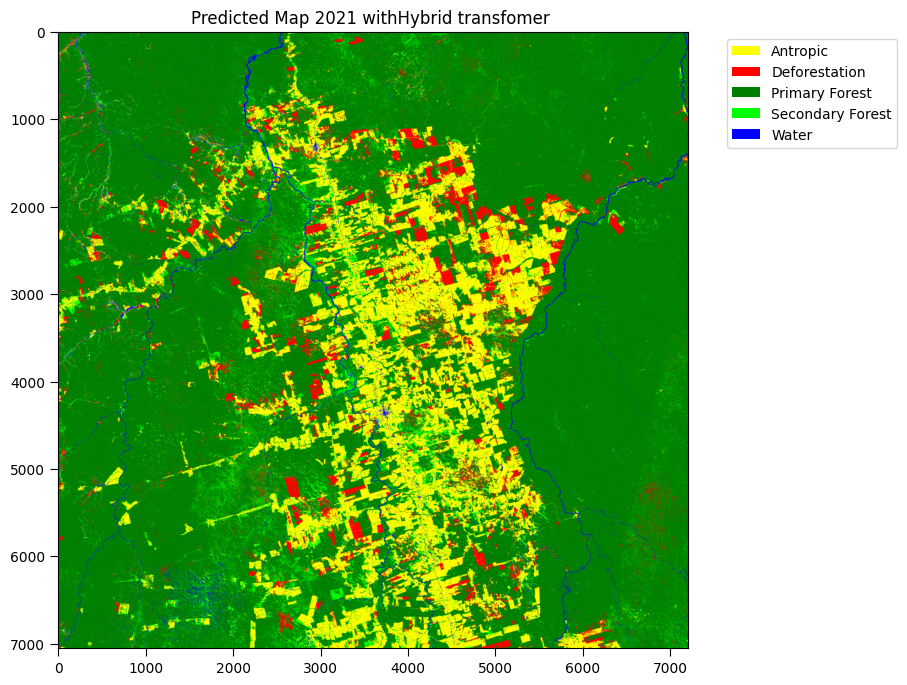

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load the classified image
with rasterio.open("Results_models/CNN_transfomer_5images/Final_CNN_predicted2021.tif") as src:
    classified_image = src.read(1)

# Define your specific color mapping and class names
color_mapping = {
    0: ('Antropic', '#FFFF00'),  # Antropic - Yellow
    1: ('Deforestation', '#FF0000'),  # Deforestation - Red
    2: ('Primary Forest', '#008000'),  # Primary Forest - Green
    3: ('Secondary Forest', '#00FF00'),  # Secondary Forest - Lime
    4: ('Water', '#0000FF')  # Water - Blue
}

# Convert class indices to RGB values
rgb_image = np.zeros((*classified_image.shape, 3), dtype=float)
for k, (name, hex_color) in color_mapping.items():
    rgb_color = np.array([int(hex_color[i:i+2], 16) for i in (1, 3, 5)]) / 255.0
    mask = classified_image == k
    rgb_image[mask] = rgb_color

# Plot the RGB image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(rgb_image)
ax.set_title('Predicted Map 2021 withHybrid transfomer ')

# Set ticks at 1000, 2000, 3000, etc. intervals
tick_intervals = np.arange(0, max(classified_image.shape[1], classified_image.shape[0]), 1000)
ax.set_xticks(tick_intervals)
ax.set_yticks(tick_intervals)

# Disable grid completely
ax.grid(False)
ax.tick_params(axis='both', which='both', direction='out', length=6, labelsize=10)

# Define labels for ticks to improve readability
ax.set_xticklabels([str(i) for i in tick_intervals])
ax.set_yticklabels([str(i) for i in tick_intervals])

# Create a legend with custom colored patches
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=hex_color, label=name) for name, hex_color in color_mapping.values()]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('hy_classified_map2021.png', format='png')
plt.show()


In [ ]:
import rasterio
import numpy as np
import pandas as pd

# Define the path to the classified image
classified_image_path = "Results_models/CNN_transfomer_5images/Final_CNN_predicted2021.tif"

# Load the classified image using rasterio
with rasterio.open(classified_image_path) as src:
    # Read the image data (assuming the classification results are in the first band)
    classified_image = src.read(1)  # Reading the first band

    # Convert float64 image data to int64 if necessary
    if classified_image.dtype == np.float64:
        classified_image = classified_image.astype(np.int64)

    # Calculate pixel size in hectares (assuming square pixels)
    pixel_size_m = src.res[0] * src.res[1]  # pixel width * pixel height in square meters
    pixel_size_ha = pixel_size_m / 10000  # convert square meters to hectares

    # Count each class occurrence
    class_counts = np.bincount(classified_image.flatten(), minlength=len(class_mapping))

    # Calculate area for each class in hectares
    class_areas_ha = class_counts * pixel_size_ha

    # Calculate total area and percentages
    total_area_ha = class_areas_ha.sum()
    class_percentages = (class_areas_ha / total_area_ha) * 100

    # Format the table
    table_header = ["Class", "No of Pixel", "Area (ha)", "Area (%)"]
    table_rows = [[class_mapping[i], class_counts[i], class_areas_ha[i], class_percentages[i]] for i in range(len(class_counts))]

    # Print table using pandas for a nicer format
    df = pd.DataFrame(table_rows, columns=table_header)
    print(df)

    # Save the DataFrame to a CSV file
    df.to_csv('Results_models/CNN_transfomer_5images/hy_class_statistics.csv', index=False)


              Class  No of Pixel  Area (ha)   Area (%)
0          Antropic      7263797   0.000053  14.306283
1     Deforestation      2593816   0.000019   5.108604
2    Primary Forest     36290929   0.000264  71.476156
3  Secondary Forest      3849095   0.000028   7.580917
4             Water       775839   0.000006   1.528040


### Plotting Time Series of Secondary Forest Area

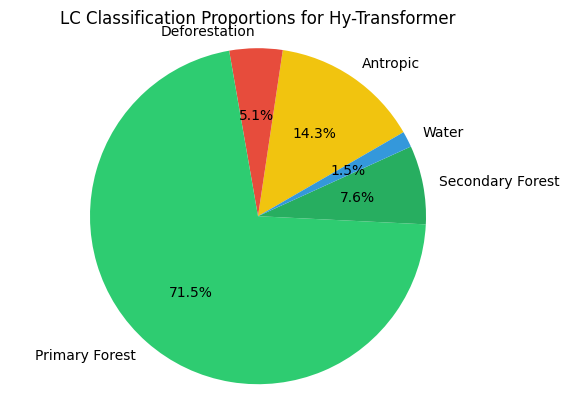

In [ ]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the classified image
classified_image_path = "Results_models/CNN_transfomer_5images/Final_CNN_predicted2021.tif"

# Load the classified image using rasterio
with rasterio.open(classified_image_path) as src:
    # Read the image data (assuming the classification results are in the first band)
    classified_image = src.read(1)  # Reading the first band

    # Convert float64 image data to int64 if necessary
    if classified_image.dtype == np.float64:
        classified_image = classified_image.astype(np.int64)

    # Calculate pixel size in hectares (assuming square pixels)
    pixel_size_m = src.res[0] * src.res[1]  # pixel width * pixel height in square meters
    pixel_size_ha = pixel_size_m / 10000  # convert square meters to hectares

    # Count each class occurrence
    class_counts = np.bincount(classified_image.flatten(), minlength=5)

    # Calculate area for each class in hectares
    class_areas_ha = class_counts * pixel_size_ha

    # Calculate total area and percentages
    total_area_ha = class_areas_ha.sum()
    class_percentages = (class_areas_ha / total_area_ha) * 100

    # Class labels
    class_labels = ["Antropic", "Deforestation", "Primary Forest", "Secondary Forest", "Water"]

# Create DataFrame for visualization
df = pd.DataFrame({
    'Class': class_labels,
    'Area (%)': class_percentages
})

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(df['Area (%)'], labels=df['Class'], autopct='%1.1f%%', startangle=30, colors=['#f1c40f', '#e74c3c', '#2ecc71', '#27ae60', '#3498db'])
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('LC Classification Proportions for Hy-Transformer')
# Save the pie chart as a PNG file
plt.savefig('Results_models/CNN_transfomer_5images/Hy_LC_classification2021.png', format='png')
plt.show()


In [ ]:
import rasterio
from rasterio.enums import Resampling

# Paths for your files
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"
predicted_map_path = "Results_models/CNN_transfomer_5images/Final_CNN_predicted2021.tif"
output_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"  # Output file path

# Open the deforestation raster to match the predicted map to it
with rasterio.open(deforestation_path) as defo_raster:
    # Read properties from the deforestation raster
    defo_transform = defo_raster.transform
    defo_crs = defo_raster.crs
    defo_width = defo_raster.width
    defo_height = defo_raster.height

    # Open the predicted raster
    with rasterio.open(predicted_map_path) as pred_raster:
        # Resample the predicted raster to match the deforestation raster
        pred_data_resampled = pred_raster.read(
            1,
            out_shape=(defo_height, defo_width),
            resampling=Resampling.nearest
        )

        # Define new metadata for the output raster
        out_meta = pred_raster.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": defo_height,
            "width": defo_width,
            "transform": defo_transform,
            "crs": defo_crs
        })

        # Write the resampled data to a new raster file
        with rasterio.open(output_path, "w", **out_meta) as out_raster:
            out_raster.write(pred_data_resampled, 1)


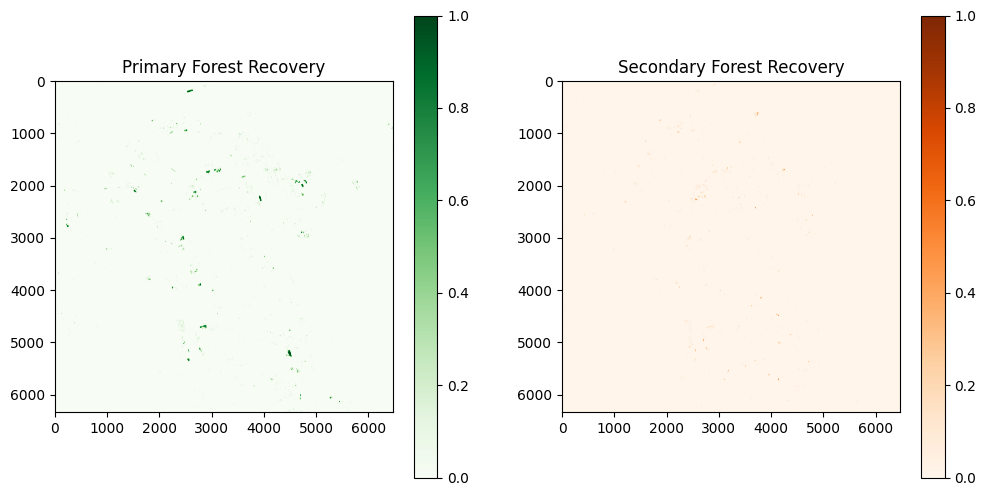

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load your raster datasets
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif" # Path to deforestation layer
resampled_predicted_map_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif" # Path to the resampled land cover prediction

# Open the raster files
with rasterio.open(deforestation_path) as defo_raster, rasterio.open(resampled_predicted_map_path) as pred_raster:
    defo_data = defo_raster.read(1)  # Read the first band where deforestation data is stored
    pred_data = pred_raster.read(1)  # Read the first band of predicted land cover

    # Define the class indices based on your classification
    ANTHROPIC = 0
    DEFORESTATION = 1
    PRIMARY_FOREST = 2
    SECONDARY_FOREST = 3
    WATER = 4

    # Create masks from the deforestation data
    defo_mask = (defo_data == DEFORESTATION)  # Mask where deforestation has occurred

    # Create masks from the predicted data
    primary_forest_mask = (pred_data == PRIMARY_FOREST)
    secondary_forest_mask = (pred_data == SECONDARY_FOREST)

    # Apply masks to identify areas
    recovery_primary = np.where(defo_mask & primary_forest_mask, 1, 0)  # 1 where primary forest regrowth
    recovery_secondary = np.where(defo_mask & secondary_forest_mask, 1, 0)  # 1 where secondary forest regrowth

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Primary Forest Recovery')
    plt.imshow(recovery_primary, cmap='Greens')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title('Secondary Forest Recovery')
    plt.imshow(recovery_secondary, cmap='Oranges')
    plt.colorbar()

    plt.show()


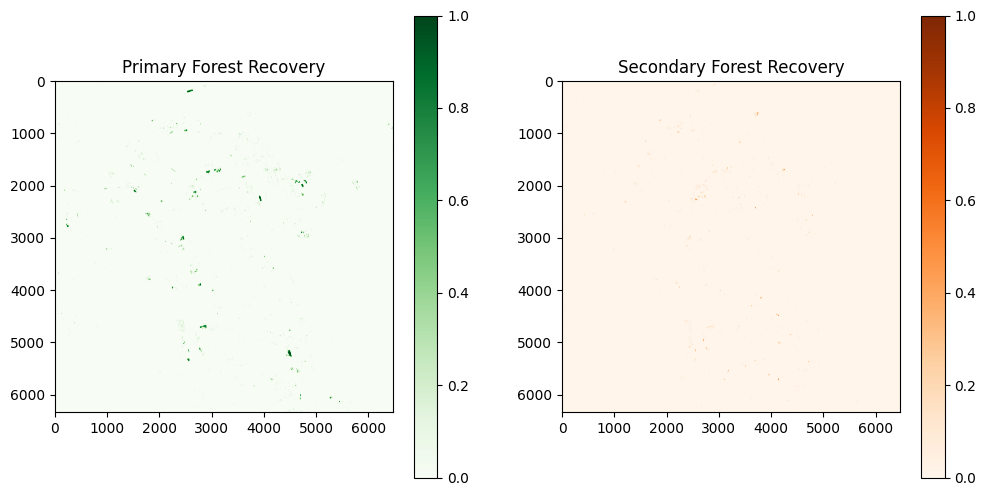

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Load your raster datasets
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"  # Path to deforestation layer
resampled_predicted_map_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"  # Path to the resampled land cover prediction

# Open the raster files
with rasterio.open(deforestation_path) as defo_raster, rasterio.open(resampled_predicted_map_path) as pred_raster:
    defo_data = defo_raster.read(1)  # Read the first band where deforestation data is stored
    pred_data = pred_raster.read(1)  # Read the first band of predicted land cover

    # Define the class indices based on your classification
    DEFORESTATION = 1
    PRIMARY_FOREST = 2
    SECONDARY_FOREST = 3

    # Create masks from the deforestation data
    defo_mask = (defo_data == DEFORESTATION)  # Mask where deforestation has occurred

    # Create masks from the predicted data
    primary_forest_mask = (pred_data == PRIMARY_FOREST)
    secondary_forest_mask = (pred_data == SECONDARY_FOREST)

    # Apply masks to identify areas of forest recovery
    recovery_primary = np.where(defo_mask & primary_forest_mask, 1, 0)  # 1 where primary forest regrowth
    recovery_secondary = np.where(defo_mask & secondary_forest_mask, 1, 0)  # 1 where secondary forest regrowth

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Primary Forest Recovery')
    plt.imshow(recovery_primary, cmap='Greens')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.title('Secondary Forest Recovery')
    plt.imshow(recovery_secondary, cmap='Oranges')
    plt.colorbar()

    plt.show()


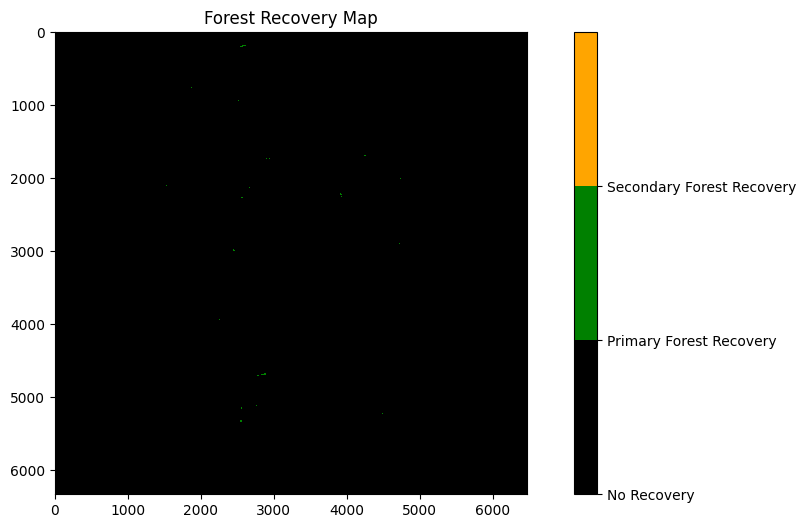

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load your raster datasets
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"  # Path to deforestation layer
resampled_predicted_map_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"  # Path to the resampled land cover prediction

# Open the raster files
with rasterio.open(deforestation_path) as defo_raster, rasterio.open(resampled_predicted_map_path) as pred_raster:
    defo_data = defo_raster.read(1)  # Read the first band where deforestation data is stored
    pred_data = pred_raster.read(1)  # Read the first band of predicted land cover

    # Define the class indices based on your classification
    DEFORESTATION = 1
    PRIMARY_FOREST = 2
    SECONDARY_FOREST = 3

    # Create masks from the deforestation data
    defo_mask = (defo_data == DEFORESTATION)  # Mask where deforestation has occurred

    # Create masks from the predicted data
    primary_forest_mask = (pred_data == PRIMARY_FOREST)
    secondary_forest_mask = (pred_data == SECONDARY_FOREST)

    # Apply masks to identify areas of forest recovery
    recovery_map = np.zeros_like(defo_data)
    recovery_map[defo_mask & primary_forest_mask] = 1  # 1 for primary forest recovery
    recovery_map[defo_mask & secondary_forest_mask] = 2  # 2 for secondary forest recovery

    # Define a colormap for the recovery map
    cmap = ListedColormap(['black', 'green', 'orange'])  # black for no recovery, green for primary, orange for secondary
    labels = ['No Recovery', 'Primary Forest Recovery', 'Secondary Forest Recovery']
    bounds = [0, 1, 2, 3]
    norm = plt.Normalize(vmin=0, vmax=3)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.title('Forest Recovery Map')
    img = plt.imshow(recovery_map, cmap=cmap, norm=norm)
    cbar = plt.colorbar(img, ticks=[0, 1, 2], boundaries=bounds)
    cbar.ax.set_yticklabels(labels)  # set labels of the colorbar
    plt.show()


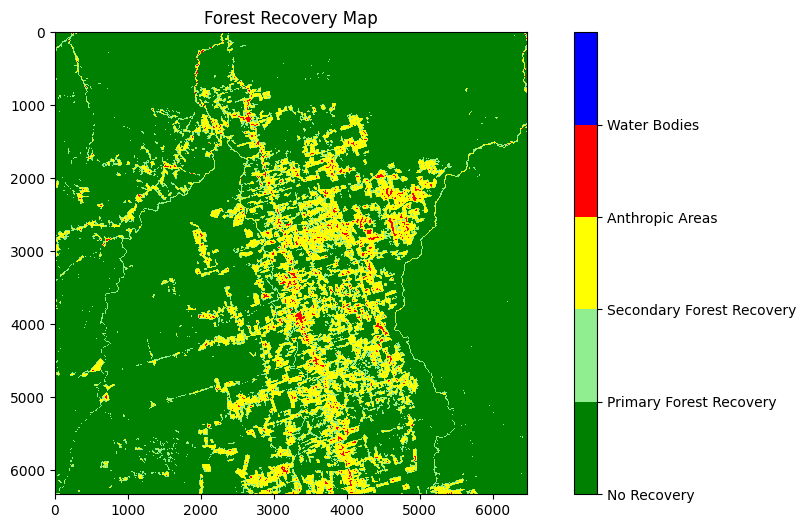

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load your raster datasets
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"  # Path to deforestation layer
resampled_predicted_map_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"  # Path to the resampled land cover prediction

# Open the raster files
with rasterio.open(deforestation_path) as defo_raster, rasterio.open(resampled_predicted_map_path) as pred_raster:
    defo_data = defo_raster.read(1)  # Read the first band where deforestation data is stored
    pred_data = pred_raster.read(1)  # Read the first band of predicted land cover

    # Define the class indices based on your classification
    ANTHROPIC = 0
    DEFORESTATION = 1
    PRIMARY_FOREST = 2
    SECONDARY_FOREST = 3
    WATER = 4

    # Create masks from the deforestation data
    defo_mask = (defo_data == DEFORESTATION)  # Mask where deforestation has occurred

    # Create masks from the predicted data
    primary_forest_mask = (pred_data == PRIMARY_FOREST)
    secondary_forest_mask = (pred_data == SECONDARY_FOREST)
    anthropic_mask = (pred_data == ANTHROPIC)
    water_mask = (pred_data == WATER)

    # Apply masks to identify areas of forest recovery
    recovery_map = np.zeros_like(defo_data)
    recovery_map[defo_mask & primary_forest_mask] = 1  # 1 for primary forest recovery
    recovery_map[defo_mask & secondary_forest_mask] = 2  # 2 for secondary forest recovery
    recovery_map[anthropic_mask] = 3  # 3 for anthropic areas
    recovery_map[water_mask] = 4  # 4 for water bodies

    # Define a colormap for the recovery map
    cmap = ListedColormap(['green', 'lightgreen', 'yellow', 'red', 'blue'])  # Colors for no recovery, primary, secondary, anthropic, water
    labels = ['No Recovery', 'Primary Forest Recovery', 'Secondary Forest Recovery', 'Anthropic Areas', 'Water Bodies']
    bounds = [0, 1, 2, 3, 4, 5]
    norm = plt.Normalize(vmin=0, vmax=5)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.title('Forest Recovery Map')
    img = plt.imshow(recovery_map, cmap=cmap, norm=norm)
    cbar = plt.colorbar(img, ticks=[0, 1, 2, 3, 4], boundaries=bounds)
    cbar.ax.set_yticklabels(labels)  # Set labels of the colorbar
    
    # Save the plot to a file
    plt.savefig("Forest_Recovery_Map.png", dpi=300)  # Save as PNG file with high resolution
    plt.show()


In [ ]:
import rasterio
import numpy as np
from rasterio.enums import Resampling
from matplotlib.colors import ListedColormap

# Load your raster datasets
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"  # Path to deforestation layer
resampled_predicted_map_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"  # Path to the resampled land cover prediction
output_tiff_path = "Results_models/CNN_transfomer_5images/Recovery_Map.tif"  # Output TIFF file path

# Open the raster files
with rasterio.open(deforestation_path) as defo_raster, rasterio.open(resampled_predicted_map_path) as pred_raster:
    defo_data = defo_raster.read(1)  # Read the first band where deforestation data is stored
    pred_data = pred_raster.read(1)  # Read the first band of predicted land cover

    # Define the class indices based on your classification
    ANTHROPIC = 0
    DEFORESTATION = 1
    PRIMARY_FOREST = 2
    SECONDARY_FOREST = 3
    WATER = 4

    # Create masks from the deforestation data
    defo_mask = (defo_data == DEFORESTATION)

    # Create masks from the predicted data
    primary_forest_mask = (pred_data == PRIMARY_FOREST)
    secondary_forest_mask = (pred_data == SECONDARY_FOREST)
    anthropic_mask = (pred_data == ANTHROPIC)
    water_mask = (pred_data == WATER)

    # Apply masks to identify areas of forest recovery
    recovery_map = np.zeros_like(defo_data, dtype=np.uint8)
    recovery_map[defo_mask & primary_forest_mask] = 1
    recovery_map[defo_mask & secondary_forest_mask] = 2
    recovery_map[anthropic_mask] = 3
    recovery_map[water_mask] = 4

    # Set the output file metadata
    out_meta = pred_raster.meta.copy()
    out_meta.update({
        "dtype": 'uint8',
        "count": 1,
        "compress": 'lzw'
    })

    # Write the recovery map to a new raster file using the metadata from the predicted raster
    with rasterio.open(output_tiff_path, "w", **out_meta) as out_raster:
        out_raster.write(recovery_map, 1)


In [ ]:
import rasterio
import numpy as np
from rasterio.enums import Resampling

# Load your raster datasets
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"  # Path to deforestation layer
resampled_predicted_map_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"  # Path to the resampled land cover prediction
output_tiff_path = "Results_models/CNN_transfomer_5images/Forest_Recovery_Map.tif"  # Output TIFF file path

# Open the raster files
with rasterio.open(deforestation_path) as defo_raster, rasterio.open(resampled_predicted_map_path) as pred_raster:
    defo_data = defo_raster.read(1)  # Read the first band where deforestation data is stored
    pred_data = pred_raster.read(1)  # Read the first band of predicted land cover

    # Define the class indices based on your classification
    DEFORESTATION = 1
    PRIMARY_FOREST = 2
    SECONDARY_FOREST = 3

    # Create masks from the deforestation data
    defo_mask = (defo_data == DEFORESTATION)  # Mask where deforestation has occurred

    # Create masks from the predicted data
    primary_forest_mask = (pred_data == PRIMARY_FOREST)
    secondary_forest_mask = (pred_data == SECONDARY_FOREST)

    # Apply masks to identify areas of forest recovery
    recovery_map = np.zeros_like(defo_data, dtype=np.uint8)
    recovery_map[defo_mask & primary_forest_mask] = 1  # 1 for primary forest recovery
    recovery_map[defo_mask & secondary_forest_mask] = 2  # 2 for secondary forest recovery

    # Set the output file metadata
    out_meta = pred_raster.meta.copy()
    out_meta.update({
        "dtype": 'uint8',
        "count": 1,
        "compress": 'lzw'
    })

    # Write the forest recovery map to a new raster file using the metadata from the predicted raster
    with rasterio.open(output_tiff_path, "w", **out_meta) as out_raster:
        out_raster.write(recovery_map, 1)


In [ ]:
import rasterio
import numpy as np

# Load your raster datasets
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"  # Path to deforestation layer
resampled_predicted_map_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"  # Path to the resampled land cover prediction
output_tiff_path = "Results_models/CNN_transfomer_5images/Forest_Recovery_After_Deforestation.tif"  # Output TIFF file path

# Open the raster files
with rasterio.open(deforestation_path) as defo_raster, rasterio.open(resampled_predicted_map_path) as pred_raster:
    defo_data = defo_raster.read(1)  # Read the first band where deforestation data is stored
    pred_data = pred_raster.read(1)  # Read the first band of predicted land cover

    # Define the class indices based on your classification
    ANTHROPIC = 0
    DEFORESTATION = 1
    PRIMARY_FOREST = 2
    SECONDARY_FOREST = 3
    WATER = 4

    # Create masks from the deforestation data
    defo_mask = (defo_data == DEFORESTATION)  # Mask where deforestation has occurred

    # Create masks from the predicted data
    primary_forest_recovery = (pred_data == PRIMARY_FOREST)
    secondary_forest_recovery = (pred_data == SECONDARY_FOREST)

    # Identify recovery in deforested areas
    forest_recovery_map = np.zeros_like(defo_data, dtype=np.uint8)
    forest_recovery_map[(defo_mask & primary_forest_recovery)] = 1  # 1 for primary forest recovery
    forest_recovery_map[(defo_mask & secondary_forest_recovery)] = 2  # 2 for secondary forest recovery

    # Set the output file metadata
    out_meta = pred_raster.meta.copy()
    out_meta.update({
        "dtype": 'uint8',
        "count": 1,
        "compress": 'lzw'
    })

    # Write the forest recovery map to a new raster file using the metadata from the predicted raster
    with rasterio.open(output_tiff_path, "w", **out_meta) as out_raster:
        out_raster.write(forest_recovery_map, 1)


In [ ]:
import rasterio
import numpy as np

# Load your raster datasets
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"  # Path to deforestation layer
resampled_predicted_map_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"  # Path to the resampled land cover prediction

# Open the raster files
with rasterio.open(deforestation_path) as defo_raster, rasterio.open(resampled_predicted_map_path) as pred_raster:
    defo_data = defo_raster.read(1)  # Read the first band where deforestation data is stored
    pred_data = pred_raster.read(1)  # Read the first band of predicted land cover

    # Define the class indices based on your classification
    DEFORESTATION = 1
    PRIMARY_FOREST = 2
    SECONDARY_FOREST = 3

    # Create masks from the deforestation data
    defo_mask = (defo_data == DEFORESTATION)  # Mask where deforestation has occurred

    # Create masks from the predicted data for secondary and primary forests
    secondary_forest_mask = (pred_data == SECONDARY_FOREST)
    primary_forest_mask = (pred_data == PRIMARY_FOREST)

    # Identify recovery in deforested areas
    secondary_recovery = np.where(defo_mask & secondary_forest_mask, 1, 0)  # 1 indicates secondary forest recovery
    primary_recovery = np.where(defo_mask & primary_forest_mask, 1, 0)  # 1 indicates primary forest recovery

    # Set the output file metadata
    out_meta = pred_raster.meta.copy()
    out_meta.update({
        "dtype": 'uint8',
        "count": 1,
        "compress": 'lzw'
    })

    # Save secondary forest recovery map to GeoTIFF
    with rasterio.open("Secondary_Forest_Recovery_After_Deforestation.tif", "w", **out_meta) as out_raster:
        out_raster.write(secondary_recovery.astype(rasterio.uint8), 1)

    # Save primary forest recovery map to GeoTIFF
    with rasterio.open("Primary_Forest_Recovery_After_Deforestation.tif", "w", **out_meta) as out_raster:
        out_raster.write(primary_recovery.astype(rasterio.uint8), 1)


In [ ]:
import rasterio
import numpy as np

# Define paths
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"
resampled_predicted_map_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"
output_dir = "Results_models/CNN_transfomer_5images"  # Directory to store output TIFF files

# Open the raster files
with rasterio.open(deforestation_path) as defo_raster, rasterio.open(resampled_predicted_map_path) as pred_raster:
    defo_data = defo_raster.read(1)  # Read the first band where deforestation data is stored
    pred_data = pred_raster.read(1)  # Read the first band of predicted land cover

    # Define the class indices based on your classification
    DEFORESTATION = 1
    PRIMARY_FOREST = 2
    SECONDARY_FOREST = 3

    # Create masks
    defo_mask = (defo_data == DEFORESTATION)  # Mask where deforestation has occurred
    secondary_forest_mask = (pred_data == SECONDARY_FOREST)
    primary_forest_mask = (pred_data == PRIMARY_FOREST)

    # Identify recovery in deforested areas
    secondary_recovery = np.where(defo_mask & secondary_forest_mask, 1, 0)  # 1 indicates secondary forest recovery
    primary_recovery = np.where(defo_mask & primary_forest_mask, 1, 0)  # 1 indicates primary forest recovery

    # Set the output file metadata
    out_meta = pred_raster.meta.copy()
    out_meta.update({
        "dtype": 'uint8',
        "count": 1,
        "compress": 'lzw'
    })

    # Save secondary forest recovery map to GeoTIFF
    secondary_output_path = f"{output_dir}/Secondary_Forest_Recovery_After_Deforestation.tif"
    with rasterio.open(secondary_output_path, "w", **out_meta) as out_raster:
        out_raster.write(secondary_recovery.astype(rasterio.uint8), 1)

    # Save primary forest recovery map to GeoTIFF
    primary_output_path = f"{output_dir}/Primary_Forest_Recovery_After_Deforestation.tif"
    with rasterio.open(primary_output_path, "w", **out_meta) as out_raster:
        out_raster.write(primary_recovery.astype(rasterio.uint8), 1)


In [ ]:
import rasterio
import numpy as np

# Define paths
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"
resampled_predicted_map_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"
output_dir = "Results_models/CNN_transfomer_5images"  # Directory to store output TIFF file

# Open the raster files
with rasterio.open(deforestation_path) as defo_raster, rasterio.open(resampled_predicted_map_path) as pred_raster:
    defo_data = defo_raster.read(1)  # Read the first band where deforestation data is stored
    pred_data = pred_raster.read(1)  # Read the first band of predicted land cover

    # Define the class indices based on your classification
    DEFORESTATION = 1
    PRIMARY_FOREST = 2
    SECONDARY_FOREST = 3

    # Create masks
    defo_mask = (defo_data == DEFORESTATION)  # Mask where deforestation has occurred
    secondary_forest_mask = (pred_data == SECONDARY_FOREST)
    primary_forest_mask = (pred_data == PRIMARY_FOREST)

    # Identify recovery in deforested areas
    secondary_recovery = defo_mask & secondary_forest_mask  # Secondary forest recovery
    primary_recovery = defo_mask & primary_forest_mask  # Primary forest recovery

    # Combine the recovery masks into one map
    combined_recovery_map = np.maximum(secondary_recovery, primary_recovery).astype(np.uint8)

    # Set the output file metadata
    out_meta = pred_raster.meta.copy()
    out_meta.update({
        "dtype": 'uint8',
        "count": 1,
        "compress": 'lzw'
    })

    # Save combined forest recovery map to GeoTIFF
    combined_output_path = f"{output_dir}/Combined_Forest_Recovery_After_Deforestation.tif"
    with rasterio.open(combined_output_path, "w", **out_meta) as out_raster:
        out_raster.write(combined_recovery_map, 1)


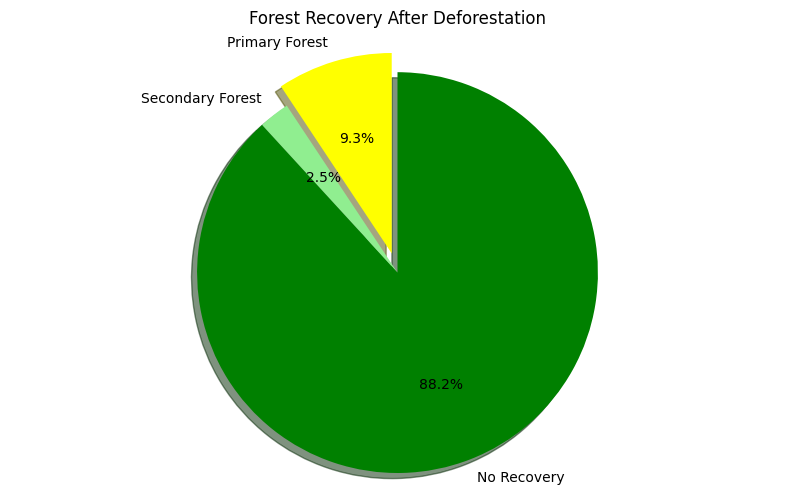

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define paths
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"
resampled_predicted_map_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"

# Open the raster files
with rasterio.open(deforestation_path) as defo_raster, rasterio.open(resampled_predicted_map_path) as pred_raster:
    defo_data = defo_raster.read(1)  # Read the first band where deforestation data is stored
    pred_data = pred_raster.read(1)  # Read the first band of predicted land cover

    # Define the class indices
    DEFORESTATION = 1
    PRIMARY_FOREST = 2
    SECONDARY_FOREST = 3

    # Create masks
    defo_mask = (defo_data == DEFORESTATION)
    secondary_forest_mask = (pred_data == SECONDARY_FOREST)
    primary_forest_mask = (pred_data == PRIMARY_FOREST)

    # Identify recovery areas
    secondary_recovery = defo_mask & secondary_forest_mask  # Secondary forest recovery
    primary_recovery = defo_mask & primary_forest_mask  # Primary forest recovery

    # Calculate recovery area counts
    secondary_recovery_count = np.sum(secondary_recovery)
    primary_recovery_count = np.sum(primary_recovery)
    non_recovery_count = np.sum(defo_mask) - secondary_recovery_count - primary_recovery_count

    # Labels and data for pie chart
    labels = 'Primary Forest', 'Secondary Forest', 'No Recovery'
    sizes = [primary_recovery_count, secondary_recovery_count, non_recovery_count]
    colors = ['yellow', 'lightgreen', 'green']
    explode = (0.1, 0, 0)  # only "explode" the 1st slice

    # Plot pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Forest Recovery After Deforestation')
    plt.show()


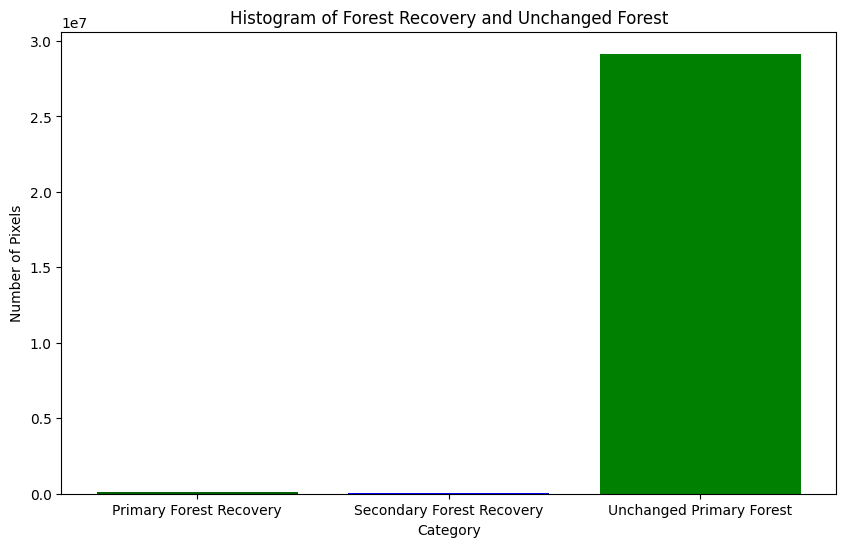

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define paths
deforestation_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"
resampled_predicted_map_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"

# Open the raster files
with rasterio.open(deforestation_path) as defo_raster, rasterio.open(resampled_predicted_map_path) as pred_raster:
    defo_data = defo_raster.read(1)  # Read the first band where deforestation data is stored
    pred_data = pred_raster.read(1)  # Read the first band of predicted land cover

    # Define the class indices
    DEFORESTATION = 1
    PRIMARY_FOREST = 2
    SECONDARY_FOREST = 3

    # Create masks
    defo_mask = (defo_data == DEFORESTATION)
    secondary_forest_mask = (pred_data == SECONDARY_FOREST)
    primary_forest_mask = (pred_data == PRIMARY_FOREST)

    # Identify recovery areas
    secondary_recovery = defo_mask & secondary_forest_mask  # Secondary forest recovery
    primary_recovery = defo_mask & primary_forest_mask  # Primary forest recovery

    # Calculate recovery area counts
    secondary_recovery_count = np.sum(secondary_recovery)
    primary_recovery_count = np.sum(primary_recovery)
    unchanged_primary_forest_count = np.sum(primary_forest_mask & ~defo_mask)  # Primary forest that was not deforested

    # Data for histogram
    categories = ['Primary Forest Recovery', 'Secondary Forest Recovery', 'Unchanged Primary Forest']
    counts = [primary_recovery_count, secondary_recovery_count, unchanged_primary_forest_count]
    colors = ['darkgreen', 'blue', 'green']  # Using 'darkgreen' for primary forest recovery

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.bar(categories, counts, color=colors)
    plt.xlabel('Category')
    plt.ylabel('Number of Pixels')
    plt.title('Histogram of Forest Recovery and Unchanged Forest')
    plt.show()


## checking uncertainties on reference data with deforestation 

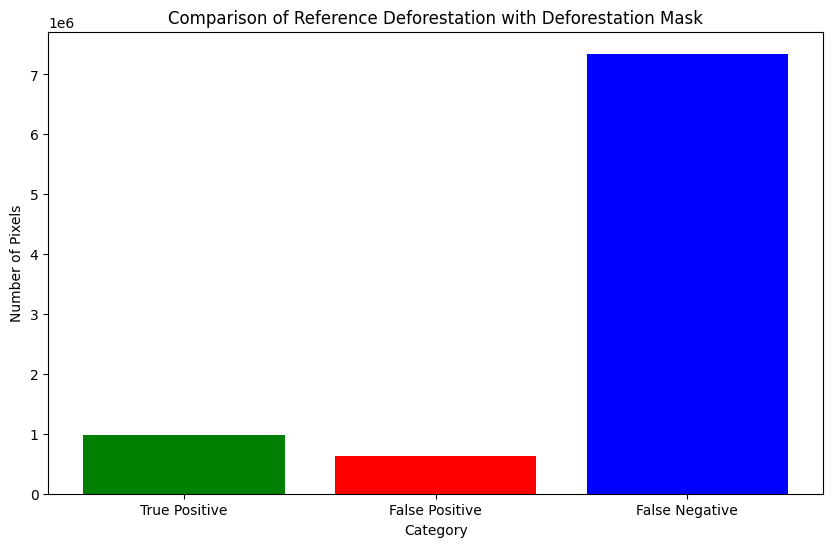

In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt

# Define paths
reference_path = "Results_models/CNN_transfomer_5images/Final_Reference_data.tif"
deforestation_mask_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"

# Open the raster files
with rasterio.open(reference_path) as ref_raster:
    # Read the reference data
    ref_data = ref_raster.read(1)  # Reference deforestation data

    # Define the shape of the reference data
    ref_transform = ref_raster.transform
    ref_shape = ref_data.shape

    with rasterio.open(deforestation_mask_path) as defo_mask_raster:
        # Resample the deforestation mask to match the reference data
        defo_mask_data = defo_mask_raster.read(
            1,
            out_shape=ref_shape,
            resampling=Resampling.nearest
        )

        # Define the class index for deforestation in the reference data
        DEFORESTATION = 1

        # Create masks
        reference_deforestation_mask = (ref_data == DEFORESTATION)
        deforestation_mask = (defo_mask_data == 1)

        # Comparison logic
        true_positive = np.logical_and(reference_deforestation_mask, deforestation_mask)
        false_positive = np.logical_and(np.logical_not(reference_deforestation_mask), deforestation_mask)
        false_negative = np.logical_and(reference_deforestation_mask, np.logical_not(deforestation_mask))

        # Count pixels in each category
        true_positive_count = np.sum(true_positive)
        false_positive_count = np.sum(false_positive)
        false_negative_count = np.sum(false_negative)

        # Data for visualization
        labels = ['True Positive', 'False Positive', 'False Negative']
        counts = [true_positive_count, false_positive_count, false_negative_count]
        colors = ['green', 'red', 'blue']

        # Plot histogram
        plt.figure(figsize=(10, 6))
        plt.bar(labels, counts, color=colors)
        plt.xlabel('Category')
        plt.ylabel('Number of Pixels')
        plt.title('Comparison of Reference Deforestation with Deforestation Mask')
        plt.show()


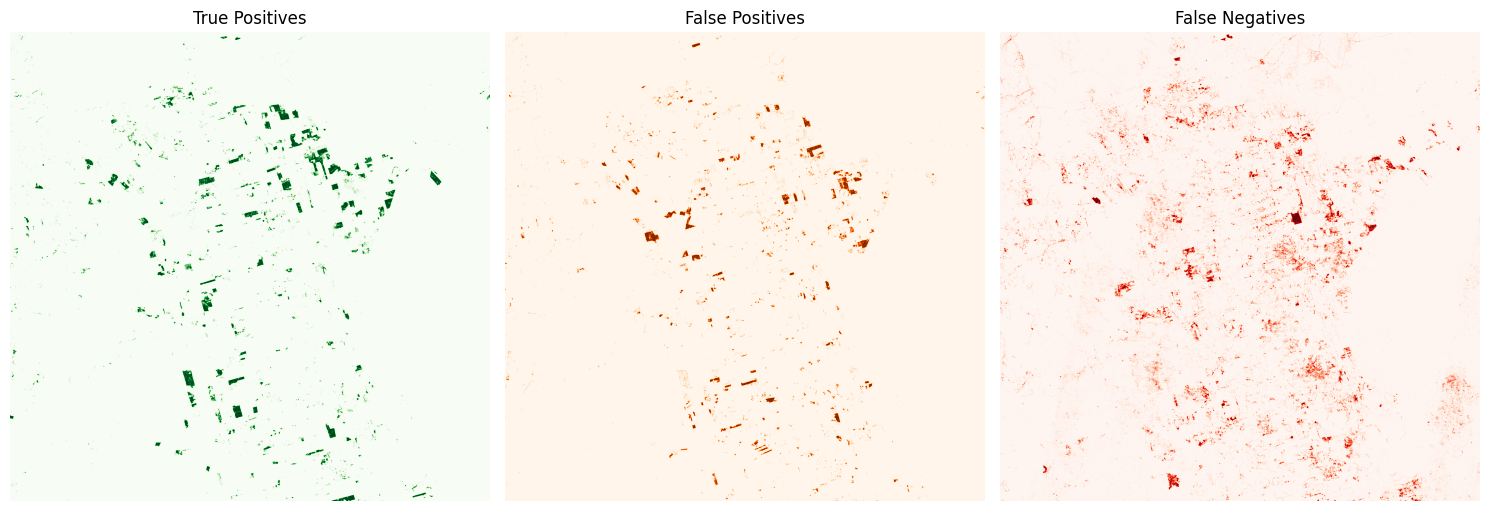

In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt

# Define paths
reference_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"
deforestation_mask_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"

# Open the raster files
with rasterio.open(reference_path) as ref_raster, rasterio.open(deforestation_mask_path) as defo_mask_raster:
    # Read reference data
    ref_data = ref_raster.read(1)

    # Resample deforestation mask to match reference data dimensions
    defo_mask_data = defo_mask_raster.read(
        1,
        out_shape=(ref_raster.height, ref_raster.width),
        resampling=Resampling.nearest
    )

    # Define deforestation class index in reference data
    DEFORESTATION = 1

    # Create masks for deforestation in both datasets
    ref_defo_mask = (ref_data == DEFORESTATION)
    mask_defo_mask = (defo_mask_data == 1)

    # Calculate true positives, false positives, and false negatives
    true_positive = ref_defo_mask & mask_defo_mask
    false_positive = (~ref_defo_mask) & mask_defo_mask
    false_negative = ref_defo_mask & (~mask_defo_mask)

    # Save results as new TIFF files
    output_meta = ref_raster.meta.copy()
    output_meta.update({
        'dtype': 'uint8',
        'count': 1
    })

    # File paths for output
    tp_path = "Results_models/CNN_transfomer_5images/True_Positives.tif"
    fp_path = "Results_models/CNN_transfomer_5images/False_Positives.tif"
    fn_path = "Results_models/CNN_transfomer_5images/False_Negatives.tif"

    with rasterio.open(tp_path, 'w', **output_meta) as tp_dst:
        tp_dst.write(true_positive.astype(np.uint8), 1)

    with rasterio.open(fp_path, 'w', **output_meta) as fp_dst:
        fp_dst.write(false_positive.astype(np.uint8), 1)

    with rasterio.open(fn_path, 'w', **output_meta) as fn_dst:
        fn_dst.write(false_negative.astype(np.uint8), 1)

    # Visualization of the results
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.title('True Positives')
    plt.imshow(true_positive, cmap='Greens')
    plt.axis('off')

    plt.subplot(132)
    plt.title('False Positives')
    plt.imshow(false_positive, cmap='Oranges')
    plt.axis('off')

    plt.subplot(133)
    plt.title('False Negatives')
    plt.imshow(false_negative, cmap='Reds')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


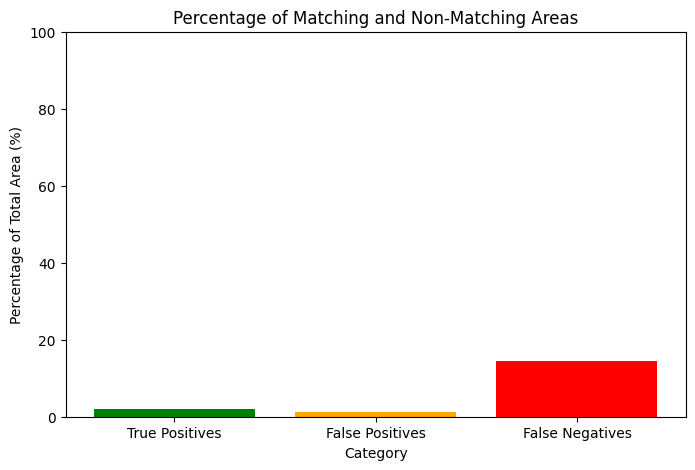

In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt

# Define paths
reference_path = "Results_models/CNN_transfomer_5images/Final_Reference_data.tif"
deforestation_mask_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"

# Open the raster files
with rasterio.open(reference_path) as ref_raster, rasterio.open(deforestation_mask_path) as defo_mask_raster:
    # Read reference data
    ref_data = ref_raster.read(1)

    # Resample deforestation mask to match reference data dimensions
    defo_mask_data = defo_mask_raster.read(
        1,
        out_shape=(ref_raster.height, ref_raster.width),
        resampling=Resampling.nearest
    )

    # Define deforestation class index in reference data
    DEFORESTATION = 1

    # Create masks for deforestation in both datasets
    ref_defo_mask = (ref_data == DEFORESTATION)
    mask_defo_mask = (defo_mask_data == 1)

    # Calculate true positives, false positives, and false negatives
    true_positive = ref_defo_mask & mask_defo_mask
    false_positive = (~ref_defo_mask) & mask_defo_mask
    false_negative = ref_defo_mask & (~mask_defo_mask)

    # Calculate total pixels and percentages
    total_pixels = ref_data.size
    true_positive_percent = np.sum(true_positive) / total_pixels * 100
    false_positive_percent = np.sum(false_positive) / total_pixels * 100
    false_negative_percent = np.sum(false_negative) / total_pixels * 100

    # Data for visualization
    labels = ['True Positives', 'False Positives', 'False Negatives']
    percentages = [true_positive_percent, false_positive_percent, false_negative_percent]
    colors = ['green', 'orange', 'red']

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.bar(labels, percentages, color=colors)
    plt.xlabel('Category')
    plt.ylabel('Percentage of Total Area (%)')
    plt.title('Percentage of Matching and Non-Matching Areas')
    plt.ylim(0, 100)  # Optional: Set a fixed y-axis to better illustrate percentage scales
    plt.show()


In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define paths
reference_path = "Results_models/CNN_transfomer_5images/Final_Reference_data.tif"
deforestation_mask_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"

# Open the raster files
with rasterio.open(reference_path) as ref_raster, rasterio.open(deforestation_mask_path) as defo_mask_raster:
    # Read reference data
    ref_data = ref_raster.read(1)

    # Resample deforestation mask to match reference data dimensions
    defo_mask_data = defo_mask_raster.read(
        1,
        out_shape=(ref_raster.height, ref_raster.width),
        resampling=Resampling.nearest
    )

    # Define deforestation class index in reference data
    DEFORESTATION = 1

    # Create masks for deforestation in both datasets
    ref_defo_mask = (ref_data == DEFORESTATION)
    mask_defo_mask = (defo_mask_data == 1)

    # Calculate true positives, false positives, and false negatives
    true_positive = ref_defo_mask & mask_defo_mask
    false_positive = (~ref_defo_mask) & mask_defo_mask
    false_negative = ref_defo_mask & (~mask_defo_mask)

    # Calculate total pixels and percentages
    total_pixels = ref_data.size
    true_positive_percent = np.sum(true_positive) / total_pixels * 100
    false_positive_percent = np.sum(false_positive) / total_pixels * 100
    false_negative_percent = np.sum(false_negative) / total_pixels * 100

    # Create DataFrame for the table
    data = {
        'Category': ['True Positives', 'False Positives', 'False Negatives'],
        'Percentage of Total Area': [true_positive_percent, false_positive_percent, false_negative_percent]
    }
    df = pd.DataFrame(data)

    # Display the DataFrame
    print(df)

# Optionally, you can save the DataFrame to a CSV or Excel file
df.to_csv('Matching_Summary.csv', index=False)
# df.to_excel('Matching_Summary.xlsx', index=False)  # Uncomment to save as Excel


          Category  Percentage of Total Area
0   True Positives                  1.917571
1  False Positives                  1.236788
2  False Negatives                 14.476115


In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def read_and_resample(path, reference_shape, reference_transform):
    with rasterio.open(path) as src:
        data = src.read(
            1,
            out_shape=reference_shape,
            resampling=Resampling.nearest
        )
        return data

# Read reference data
with rasterio.open("Results_models/CNN_transfomer_5images/Final_Reference_data.tif") as ref_raster:
    reference_data = ref_raster.read(1)
    reference_shape = (ref_raster.height, ref_raster.width)
    reference_transform = ref_raster.transform

# Resample predicted data to match reference data
predicted_data = read_and_resample("Results_models/CNN_transfomer_5images/Final_CNN_predicted2021.tif", reference_shape, reference_transform)

# Define masks
ref_secondary = (reference_data == 2)  # Assuming '2' is secondary forest
pred_secondary = (predicted_data == 2)
ref_deforest = (reference_data == 1)  # Assuming '1' is deforestation
pred_deforest = (predicted_data == 1)

# Flatten arrays for confusion matrix calculation
y_true_secondary = ref_secondary.flatten()
y_pred_secondary = pred_secondary.flatten()
y_true_deforest = ref_deforest.flatten()
y_pred_deforest = pred_deforest.flatten()

# Calculate confusion matrices and print reports
cm_secondary = confusion_matrix(y_true_secondary, y_pred_secondary)
cm_deforest = confusion_matrix(y_true_deforest, y_pred_deforest)

print("Classification Report for Secondary Forest:")
print(classification_report(y_true_secondary, y_pred_secondary))
print("Classification Report for Deforestation:")
print(classification_report(y_true_deforest, y_pred_deforest))


Classification Report for Secondary Forest:
              precision    recall  f1-score   support

       False       0.70      0.97      0.81  10386074
        True       0.99      0.89      0.94  40358902

    accuracy                           0.91  50744976
   macro avg       0.84      0.93      0.88  50744976
weighted avg       0.93      0.91      0.91  50744976

Classification Report for Deforestation:
              precision    recall  f1-score   support

       False       0.84      0.96      0.90  42426004
        True       0.32      0.10      0.15   8318972

    accuracy                           0.82  50744976
   macro avg       0.58      0.53      0.53  50744976
weighted avg       0.76      0.82      0.78  50744976



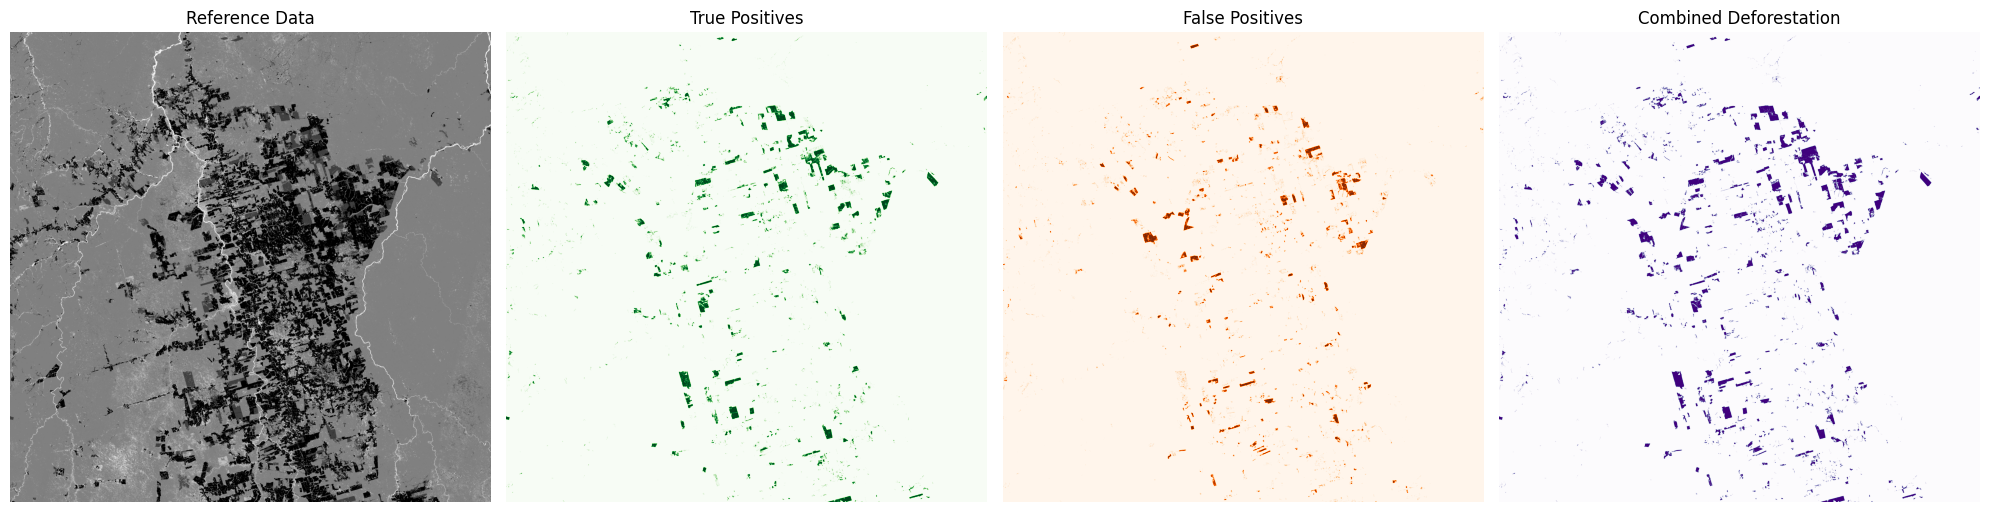

In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np
import matplotlib.pyplot as plt

# Define paths
reference_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"
deforestation_mask_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"

# Open the raster files
with rasterio.open(reference_path) as ref_raster, rasterio.open(deforestation_mask_path) as defo_mask_raster:
    # Read reference data
    ref_data = ref_raster.read(1)

    # Resample deforestation mask to match reference data dimensions
    defo_mask_data = defo_mask_raster.read(
        1,
        out_shape=(ref_raster.height, ref_raster.width),
        resampling=Resampling.nearest
    )

    # Create masks for deforestation in both datasets
    DEFORESTATION = 1
    ref_defo_mask = (ref_data == DEFORESTATION)
    mask_defo_mask = (defo_mask_data == 1)

    # Calculate true positives, false positives, and false negatives
    true_positive = ref_defo_mask & mask_defo_mask
    false_positive = (~ref_defo_mask) & mask_defo_mask
    false_negative = ref_defo_mask & (~mask_defo_mask)

    # Combine true positives and false positives
    combined_deforestation = true_positive | false_positive

    # Save results as new TIFF files with updated metadata for combined mask
    combined_path = "Results_models/CNN_transfomer_5images/Combined_Deforestation.tif"
    output_meta = ref_raster.meta.copy()
    output_meta.update({
        'dtype': 'uint8',
        'count': 1
    })

    with rasterio.open(combined_path, 'w', **output_meta) as combined_dst:
        combined_dst.write(combined_deforestation.astype(np.uint8), 1)

    # Optionally save the reference data as a TIFF file
    ref_output_path = "Results_models/CNN_transfomer_5images/Reference_Data.tif"
    with rasterio.open(ref_output_path, 'w', **ref_raster.meta) as ref_dst:
        ref_dst.write(ref_data, 1)

    # Visualization of the results
    plt.figure(figsize=(20, 5))
    plt.subplot(141)
    plt.title('Reference Data')
    plt.imshow(ref_data, cmap='gray')
    plt.axis('off')

    plt.subplot(142)
    plt.title('True Positives')
    plt.imshow(true_positive, cmap='Greens')
    plt.axis('off')

    plt.subplot(143)
    plt.title('False Positives')
    plt.imshow(false_positive, cmap='Oranges')
    plt.axis('off')

    plt.subplot(144)
    plt.title('Combined Deforestation')
    plt.imshow(combined_deforestation, cmap='Purples')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
import rasterio
from rasterio.enums import Resampling
import numpy as np

# Define paths
reference_path = "Results_models/CNN_transfomer_5images/Resampled_Predicted2021.tif"
deforestation_mask_path = "Results_models/CNN_transfomer_5images/Defoestation_claa1.tif"

# Open the raster files
with rasterio.open(reference_path) as ref_raster, rasterio.open(deforestation_mask_path) as defo_mask_raster:
    # Read reference data
    ref_data = ref_raster.read(1)

    # Resample deforestation mask to match reference data dimensions
    defo_mask_data = defo_mask_raster.read(
        1,
        out_shape=(ref_raster.height, ref_raster.width),
        resampling=Resampling.nearest
    )

    # Define deforestation class index in reference data
    DEFORESTATION = 1

    # Identify false positives
    ref_not_defo = ref_data != DEFORESTATION
    mask_defo = defo_mask_data == DEFORESTATION
    false_positive = ref_not_defo & mask_defo

    # Update the reference data for false positives
    ref_data[false_positive] = DEFORESTATION

    # Save the updated reference data with compression
    updated_ref_path = "Results_models/CNN_transfomer_5images/Updated_Reference.tif"
    output_meta = ref_raster.meta.copy()
    output_meta.update({
        'compress': 'lzw'
    })

    with rasterio.open(updated_ref_path, 'w', **output_meta) as updated_dst:
        updated_dst.write(ref_data, 1)


In [ ]:
import math

# Image dimensions
width = 7204
height = 7044
patch_size = 256

# Calculating number of patches that can fit in each dimension
num_patches_width = width // patch_size
num_patches_height = height // patch_size

# Total number of patches
total_patches = num_patches_width * num_patches_height

num_patches_width, num_patches_height, total_patches


(28, 27, 756)

In [ ]:
import math

# Image dimensions
width = 7204
height = 7044
patch_size = 256

# Calculating number of patches that can fit in each dimension
num_patches_width = width // patch_size
num_patches_height = height // patch_size

# Total number of patches
total_patches = num_patches_width * num_patches_height

num_patches_width, num_patches_height, total_patches


(28, 27, 756)